Toy example을 제외하고, 코드 구현, 결과를 통합해서 visualization하기 위한 script

다루고 있는 것으로는

# Code Implementation
- HVP
- IHVP-CG
- IHVP-NCG
- IHVP-SE

# Experimental Result

- TOP-k examples sorted by IF measure
- t-sne result
- interpretation of result
- TOP-k examples sorted by IF measure on specific class
- relabeling using IF measure


# Code Implementation

## HVP

Remark)

tensorflow에서는 gradient가 operator로 존재하며 이를 이용하면 hessian vector product를 automatic differentiation으로 구현할 수 있음. 그 결과 추가적인 error 없이 정확한 값을 얻을 수 있음.

반면 cntk에서는 gradient output이 값으로만 나오게 됨. 때문에 numerical differentiation을 이용해서 구현함. 그 결과 error가 조금 발생하게 됨.

In [1]:
import cntk as C
from cntk.device import try_set_default_device, gpu
try_set_default_device(gpu(0))

import numpy as np
import time
import os

from torch.utils.data import DataLoader

In [2]:
# Hessian Vector Product

def grad_inner_product(grad1, grad2):
    # inner product for dictionary-format gradients (output scalar value)
    
    val = 0
    
    assert(len(grad1)==len(grad2))
    
    for ks in grad1.keys():
        val += np.sum(np.multiply(grad1[ks],grad2[ks]))
        
    return val

def weight_update(w, v, r):
    # w: weights of neural network (tuple)
    # v: value for delta w (dictionary, e.g., gradient value)
    # r: hyperparameter for a gradient (scalar)

    for p in w:
        p.value += r * v[p]

def HVP(y, x, v):
    # Calculate Hessian vector product 
    # y: scalar function to be differentiated (function, e.g. cross entropy loss)
    # x: feed_dict value for the network (dictionary, e.g. {model.X: image_batch, model.y: label_batch})
    # v: vector to be producted (by Hessian) (numeric dictionary, e.g., g(z_test))
    ## w: variables to differentiate (numeric, e.g. neural network weight)
    
    # hyperparameter r
    r = 1e-2
    
    assert type(x)==dict, "Input of HVP is wrong. 'x' should be dictionary(feed dict format)"
    assert type(v)==dict, "Input of HVP is wrong. 'v' should be dictionary(weight:value format)"

    w = v.keys()
    
    # gradient for plus
    weight_update(w, v, +r)
    g_plus = y.grad(x, wrt=w)
  
    # gradient for minus
    weight_update(w, v, -2*r)
    g_minus = y.grad(x, wrt=w)
    
    # weight reconstruction
    weight_update(w, v, +r)
    
    hvp = {ks: (g_plus[ks] - g_minus[ks])/(2*r) for ks in g_plus.keys()}
       
    return hvp


## IHVP

논문에서 나온 conjugate gradient와 stochastic estimation 두 방법을 모두 구현함.

Remark)

원작자 코드에서는 conjugate gradient를 구현할 때 scipy의 ncg (Newton's conjugate gradient)를 사용해서 구현함. 하지만 ncg의 경우 update를 담당하는 outer loop 안에 update 수치를 찾기 위한 작은 inner loop를 하나 더 돌게 되는데, 적절한 해를 찾지 못할 경우 이 inner loop를 벗어나지 못할 가능성이 있음.
- 과거 버전에서는 while loop을 사용해서 진행되어 평생 벗어나지 못할 가능성이 있음.
- 최신 버전에서는 for loop을 사용해서 진행되어 cg_maxiter를 넘기면 벗어날 가능성이 있으나 이 값은 내부에서만 존재하는 hyperparameter라서 바꿔줄 수 없음. 내부에서 지정된 값은 20 * len(x0)인데, 우리의 경우 len(x0)가 80000이 넘어가기 때문에 사실상 며칠을 돌려도 끝나지 않음. (몇 십분 돌렸을 때 겨우 400번 정도 돌았음.)

때문에 scipy의 cg를 사용해서 구현함. 이 경우 maxiter를 이용하면 수렴하지 않더라도 학습을 중간에 끝낼 수 있음.

In [3]:
# Newton-Conjugate Gradient

from scipy.optimize import fmin_ncg

def dic2vec(dic):
    # convert a dictionary with matrix values to a 1D vector
    # e.g. gradient of network -> 1D vector
    vec = np.concatenate([val.reshape(-1) for val in dic.values()])
    
    return vec

def vec2dic(vec, fmt):
    # convert a 1D vector to a dictionary of format fmt
    # fmt = {key: val.shape for (key,val) in dict}
    fmt_idx = [np.prod(val) for val in fmt.values()]
    #lambda ls, idx: [ls[sum(idx[:i]):sum(idx[:i+1])] for i in range(len(idx))]
    vec_split = [vec[sum(fmt_idx[:i]):sum(fmt_idx[:i+1])] for i in range(len(fmt_idx))]
    dic = {key: vec_split[i].reshape(shape) for (i,(key,shape)) in enumerate(fmt.items())}

    return dic

def get_inverse_hvp_ncg(model, y, v, data_set, **kwargs):
    # return x, which is the solution of QP, whose value is H^-1 v
    # kwargs: hyperparameters for conjugate gradient
    batch_size = kwargs.pop('batch_size', 50)
    damping = kwargs.pop('damping', 0.0)
    avextol = kwargs.pop('avextol', 1e-8)
    maxiter = kwargs.pop('maxiter', 1e1)
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    t0 = time.time()
    get_inverse_hvp_ncg.cnt = 0

    def HVP_minibatch_val(y, v):
        # Calculate Hessian vector product w.r.t whole dataset
        # y: scalar function output of the neural network (e.g. model.loss)
        # v: vector to be producted by inverse hessian (i.e.H^-1 v) (numeric dictionary, e.g. v_test)
        
        ## model: neural network model (e.g. model)
        ## dataloader: training set dataloader
        ## damping: damp term to make hessian convex

        hvp_batch = {ks: [] for ks in v.keys()}

        for img, lb in dataloader:
            img = img.numpy(); lb = lb.numpy()
            x_feed = {model.X: img, model.y:lb}
            hvp = HVP(y,x_feed,v)
            # add hvp value
            [hvp_batch[ks].append(hvp[ks]/img.shape[0]) for ks in hvp.keys()]

        hvp_mean = {ks: np.mean(hvp_batch[ks], axis=0) + damping*v[ks] for ks in hvp_batch.keys()}

        return hvp_mean

    def get_fmin_loss(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)

        return 0.5 * grad_inner_product(hvp_val, x_dic) - grad_inner_product(v, x_dic)

    def get_fmin_grad(x):
        # x: 1D vector
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)
        hvp_flat = dic2vec(hvp_val)
        v_flat = dic2vec(v)

        return hvp_flat - v_flat
    
    def get_fmin_hvp(x, p):
        p_dic = vec2dic(p, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, p_dic)
        hvp_flat = dic2vec(hvp_val)

        return hvp_flat

    def ncg_callback(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        print('iteration: {}'.format(get_inverse_hvp_ncg.cnt), ', ', time.time()-t0, '(sec) elapsed')
        print('vector element-wise square: ', grad_inner_product(x_dic, x_dic))
        get_inverse_hvp_ncg.cnt += 1
        
        return 0
    
    fmin_loss_fn = get_fmin_loss
    fmin_grad_fn = get_fmin_grad
    fmin_hvp_fn = get_fmin_hvp
    
    fmin_results = fmin_ncg(\
            f = fmin_loss_fn, x0 = dic2vec(v), fprime = fmin_grad_fn,\
            fhess_p = fmin_hvp_fn, avextol = avextol, maxiter = maxiter, callback=ncg_callback)
    
    return vec2dic(fmin_results, {key: val.shape for (key, val) in v.items()})

In [4]:
# Conjugate Gradient

from scipy.optimize import fmin_cg

def dic2vec(dic):
    # convert a dictionary with matrix values to a 1D vector
    # e.g. gradient of network -> 1D vector
    vec = np.concatenate([val.reshape(-1) for val in dic.values()])
    
    return vec

def vec2dic(vec, fmt):
    # convert a 1D vector to a dictionary of format fmt
    # fmt = {key: val.shape for (key,val) in dict}
    fmt_idx = [np.prod(val) for val in fmt.values()]
    #lambda ls, idx: [ls[sum(idx[:i]):sum(idx[:i+1])] for i in range(len(idx))]
    vec_split = [vec[sum(fmt_idx[:i]):sum(fmt_idx[:i+1])] for i in range(len(fmt_idx))]
    dic = {key: vec_split[i].reshape(shape) for (i,(key,shape)) in enumerate(fmt.items())}

    return dic

def get_inverse_hvp_cg(model, y, v, data_set, **kwargs):
    # return x, which is the solution of QP, whose value is H^-1 v
    # kwargs: hyperparameters for conjugate gradient
    batch_size = kwargs.pop('batch_size', 50)
    damping = kwargs.pop('damping', 0.0)
    maxiter = kwargs.pop('maxiter', 5e1)
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    t0 = time.time()
    get_inverse_hvp_cg.cnt = 0

    def HVP_minibatch_val(y, v):
        # Calculate Hessian vector product w.r.t whole dataset
        # y: scalar function output of the neural network (e.g. model.loss)
        # v: vector to be producted by inverse hessian (i.e.H^-1 v) (numeric dictionary, e.g. v_test)
        
        ## model: neural network model (e.g. model)
        ## dataloader: training set dataloader
        ## damping: damp term to make hessian convex
        
        num_data = data_set.__len__()

        hvp_batch = {key: np.zeros_like(value) for key,value in v.items()}

        for img, lb in dataloader:
            img = img.numpy(); lb = lb.numpy()
            x_feed = {model.X: img, model.y:lb}
            hvp = HVP(y,x_feed,v)
            # add hvp value
            for ks in hvp.keys():
                hvp_batch[ks] += hvp[ks]/num_data
                
        return hvp_batch

    def fmin_loss_fn(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)

        return 0.5 * grad_inner_product(hvp_val, x_dic) - grad_inner_product(v, x_dic)

    def fmin_grad_fn(x):
        # x: 1D vector
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(y, x_dic)
        hvp_flat = dic2vec(hvp_val)
        v_flat = dic2vec(v)

        return hvp_flat - v_flat
    
    def cg_callback(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        print('iteration: {}'.format(get_inverse_hvp_cg.cnt), ', ', time.time()-t0, '(sec) elapsed')
        print('vector element-wise square: ', grad_inner_product(x_dic, x_dic))
        get_inverse_hvp_cg.cnt += 1
        
        return 0
    
    fmin_results = fmin_cg(f=fmin_loss_fn, x0=dic2vec(v), fprime=fmin_grad_fn, callback=cg_callback, maxiter=maxiter)
    
    return vec2dic(fmin_results, {key: val.shape for (key, val) in v.items()})

In [24]:
# Stochastic Estimation

def get_inverse_hvp_se(model, y, v, data_set, **kwargs):
    # Calculate inverse hessian vector product over the training set
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (e.g. v_test)
    # data_set: training set to be summed in Hessian
    # kwargs: hyperparameters for stochastic estimation
    
    # hyperparameters
    recursion_depth = kwargs.pop('recursion_depth', 50) # epoch
    scale = kwargs.pop('scale', 1e1) # similar to learning rate
    damping = kwargs.pop('damping', 0.0) # paper reference: 0.01
    batch_size = kwargs.pop('batch_size', 1)
    num_samples = kwargs.pop('num_samples', 1) # the number of samples(:stochatic estimation of IF) to be averaged
    tolerance = kwargs.pop('tolerance', 1e-2) # the difference btw l2 norms of current and previous vector used for early stopping
    verbose = kwargs.pop('verbose', False)
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    inv_hvps = []
    
    params = v.keys()
    
    for i in range(num_samples):
        # obtain num_samples inverse hvps
        cur_estimate = v
        prev_norm = 0
        
        for depth in range(recursion_depth):
            # epoch-scale recursion depth
            t1 = time.time()
            for img, lb in dataloader:
                img = img.numpy(); lb = lb.numpy()
                x_feed = {model.X: img, model.y:lb}
                hvp = HVP(y,x_feed,cur_estimate)
                # cur_estimate = v + (1-damping)*cur_estimate + 1/scale*(hvp/batch_size)
                cur_estimate = {ks: v[ks] + (1-damping/scale)*cur_estimate[ks] - (1/scale)*hvp[ks]/batch_size for ks in cur_estimate.keys()}
            
            if verbose:
                print('#w: \n', list(map(lambda x: x.value, params)), '\n#hvp: \n', hvp, '\n#ihvp: \n', cur_estimate)
            
            cur_norm = np.sqrt(grad_inner_product(cur_estimate,cur_estimate))
            print('Recursion depth: {}, norm: {}, time: {} \n'.format(depth, cur_norm,time.time()-t1))
            
            # divergence check
            if np.isnan(cur_norm):
                print('## The result has been diverged ##')
                break
            
            # convergence check
            if np.abs(cur_norm - prev_norm) <= tolerance:
                # change this to more precise one (<- scipy.fmin_cg also use gnorm)
                print('## Early stopped due to small change')
                break
            prev_norm = cur_norm
        
        inv_hvp = {ks: (1/scale)*cur_estimate[ks] for ks in cur_estimate.keys()}
        inv_hvps.append(inv_hvp)
    
    inv_hvp_val = {ks: np.mean([inv_hvps[i][ks] for i in range(num_samples)], axis=0) for ks in inv_hvps[0].keys()}
    
    return inv_hvp_val

## Toy Example for IHVP (CG, NCG, SE)

간단한 neural network를 사용해서 위 알고리즘이 잘 동작하는지 확인.

사실 network의 Hessian은 w에 대해서 locally convex함. 따라서 수렴하지 않거나 발산할 가능성이 있음. 

하지만 w를 고정시켜두고 이를 진행시켰을 때 만약 알고리즘이 locally convex한 경우에서도 잘 동작한다면, (1.25, -0.083) 값이 나와야 함.

세 알고리즘 모두 원하는 값에 잘 수렴함을 확인함.
(SE의 경우에는 scale에 따라서 발산할 때도 있음.)

이에 대한 자세한 결과는 ihvp_toy.ipynb를 참고

In [25]:
# toy example for inverse HVP (CG, NCG and SE)

class SimpleNet(object):
    def __init__(self):
        self.X = C.input_variable(shape=(1,))
        self.h = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.X)
        self.pred = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.h)
        self.y = C.input_variable(shape=(1,))
        self.loss = C.squared_error(self.pred, self.y)
        
class SimpleDataset(object):
    def __init__(self, images, labels):
        self._images, self._labels = images, labels
    
    def __getitem__(self, index):
        X = self._images[index]
        y = self._labels[index]
        
        return X, y
    
    def __len__(self):
        return len(self._images)


net = SimpleNet()

params = net.pred.parameters

x_feed = {net.X:np.array([[2.]],dtype=np.float32), net.y:np.array([[1.]],dtype=np.float32)}
v_feed = {p: np.ones_like(p.value) for p in params}

print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))
params[0].value = np.asarray([[1.]])
params[1].value = np.asarray([[1./3.]])
print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))

print('hvp', HVP(net.loss, x_feed, v_feed))

#images = np.asarray([[2.],[2.]], dtype=np.float32)
#labels = np.asarray([[1.],[1.]], dtype=np.float32)
images = np.asarray([[2.]], dtype=np.float32)
labels = np.asarray([[1.]], dtype=np.float32)

train_set = SimpleDataset(images,labels)

print('######## damping = 0.0, desired solution: [1.25, -0.08] ########'); t1 = time.time()
ihvp_ncg = get_inverse_hvp_ncg(net, net.loss, v_feed, train_set, **{'damping': 0.0}); t2 = time.time()
ihvp_cg = get_inverse_hvp_cg(net, net.loss, v_feed, train_set, **{'damping': 0.0}); t3 = time.time()
ihvp_se = get_inverse_hvp_se(net, net.loss, v_feed, train_set, **{'damping': 0.0, 'recursion_depth': 100}); t4 = time.time()
print('inverse hvp_ncg', ihvp_ncg, '\ntime: ', t2-t1)
print('inverse hvp_cg', ihvp_cg, '\ntime: ', t3-t2 )
print('inverse hvp_se', ihvp_se, '\ntime: ', t4-t3)

# print('inverse hvp_ncg', get_inverse_hvp_ncg(net, net.loss, v_feed, train_set, **{'damping': 0.1}))
# print('inverse hvp_cg', get_inverse_hvp_cg(net, net.loss, v_feed, train_set, **{'damping': 0.1}))
# print('inverse hvp_se', get_inverse_hvp_se(net, net.loss, v_feed, train_set, **{'scale':10, 'damping':0.1}))

w1 = 
 [[ 0.22057047]] 
w2 = 
 [[-0.6255576]] 
loss = 
 [ 1.62807143]
w1 = 
 [[ 1.]] 
w2 = 
 [[ 0.33333334]] 
loss = 
 [ 0.1111111]
hvp {Parameter('W', [], [1 x 1]): array([[ 2.22302079]], dtype=float32), Parameter('W', [], [1 x 1]): array([[ 9.33413506]], dtype=float32)}
######## damping = 0.0, desired solution: [1.25, -0.08] ########
iteration: 0 ,  0.6021561622619629 (sec) elapsed
vector element-wise square:  0.725185762087
iteration: 1 ,  1.2043378353118896 (sec) elapsed
vector element-wise square:  1.56326942006
iteration: 2 ,  1.8083915710449219 (sec) elapsed
vector element-wise square:  1.56095527625
iteration: 3 ,  2.5553295612335205 (sec) elapsed
vector element-wise square:  1.56935306871
iteration: 4 ,  4.155549049377441 (sec) elapsed
vector element-wise square:  1.56935306871
Optimization terminated successfully.
         Current function value: -0.583328
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 13
         Hessian evaluations: 7

# Experimental Result

Noisy EMNIST dataset을 사용해서 실험을 진행함.

이 데이터를 사용하는 이유는
- EMNIST dataset은 일반적으로 사용하는 typo이기 때문에 직관적으로 해석할 수 있음.
- noisy label 문제를 다루기 때문에 이와 연결지어 해석할 수 있음.
- 과거 학습된 network를 가지고 있음. (suawiki/noisy label 참고)

In [27]:
import os, sys
sys.path.append('../refer/boot_strapping')
import json

from datasets import dataset28 as dataset

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.misc
from torch.utils.data import DataLoader

In [28]:
def show_image_from_data(img):
    # show image from dataset
    # img: (C,W,H) numpy array
    img_show = np.squeeze(np.transpose(img, [1,2,0]))
    imshow(img_show)
    plt.show()

In [39]:
def IF_val(net, ihvp, data_set, cosine=False):
    # Calculate influence function w.r.t ihvp and data_set
    # This should be done in sample-wise, since the gradient operation will sum up over whole feed-dicted data
    
    # ihvp: inverse hessian vector product (dictionary)
    # data_set: data_set to be feed to the gradient operation (dataset)
    IF_list = []
    
    #params = net.logits.parameters
    params = ihvp.keys()
    
    dataloader = DataLoader(data_set, 1, shuffle=False, num_workers=6)
    
    t1 = time.time()
    for img, lb in dataloader:
        img = img.numpy(); lb = lb.numpy()
        gd = net.loss.grad({net.X:img, net.y:lb}, wrt=params)
        if cosine:
            nrm = np.sqrt(grad_inner_product(gd,gd))
            gd = {k: v/nrm for k,v in gd.items()}
        IF = -grad_inner_product(ihvp, gd) / len(dataloader)
        IF_list.append(IF)
    print('IF_val takes {} sec'.format(time.time()-t1))
        
    return IF_list

def visualize_topk_samples(measure, train_set, num_sample=5, mask=None, verbose='ALL', save_path='./result'):
    # 'ALL': show DISADV / ADV / INF / NEG examples
    # 'ADV': show ADV only
    # 'DIS': show DIS only

    axis = 0
    
    if mask == None:
        argsort = np.argsort(measure)
    else:
        assert(len(mask) == len(measure))
        argsort = list(filter(lambda idx: mask[idx], np.argsort(measure)))
    
    topk = argsort[-1:-num_sample-1:-1]
    botk = argsort[0:num_sample]
    
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)

    if verbose == 'DIS' or verbose == 'ALL':
        dis = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST DISADVANTAGEOUS EXAMPLES ##\n'.format(num_sample))
        for idx in topk:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            print(trainval_list[idx])
            dis.append(img)
            true_label += train_set.filename_list[idx].split('_')[1]
            noisy_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
        dis = np.squeeze(np.concatenate(dis, axis=axis))
        scipy.misc.imsave(save_path+'/disadvantageous_true_{}_noisy_{}.png'.format(true_label, noisy_label), dis)

    if verbose == 'ADV' or verbose == 'ALL':
        adv = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST ADVANTAGEOUS EXAMPLES ##\n'.format(num_sample))
        for idx in botk:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            print(trainval_list[idx])
            adv.append(img)
            true_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
            noisy_label += train_set.filename_list[idx].split('_')[1]
        adv = np.squeeze(np.concatenate(adv, axis=axis))
        scipy.misc.imsave(save_path+'/advantageous_true_{}_noisy_{}.png'.format(true_label, noisy_label), adv)

    if verbose == 'ALL':
        
        if mask == None:
            argsort_abs = np.argsort(np.abs(measure))
        else:
            assert(len(mask) == len(measure))
            argsort_abs = list(filter(lambda idx: mask[idx], np.argsort(np.abs(measure))))

        topk_abs = argsort_abs[-1:-num_sample-1:-1]
        botk_abs = argsort_abs[0:num_sample]
        
        inf = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST INFLUENTIAL EXAMPLES ##\n'.format(num_sample))
        for idx in topk_abs:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            inf.append(img)
            true_label += train_set.filename_list[idx].split('_')[1]
            noisy_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
        inf = np.squeeze(np.concatenate(inf, axis=axis))
        scipy.misc.imsave(save_path+'/influential_true_{}_noisy_{}.png'.format(true_label, noisy_label), inf)

        neg = []
        true_label = ''; noisy_label = ''
        print('\n## SHOW {}-MOST NEGLIGIBLE EXAMPLES ##\n'.format(num_sample))
        for idx in botk_abs:
            img, lb = train_set.__getitem__(idx)
            show_image_from_data(img)
            print('training set name: ', train_set.filename_list[idx])
            print('training set label: ', train_set.anno_dict['classes'][str(np.argmax(lb))])
            print('IF measure: ', measure[idx])
            neg.append(img)
            true_label += train_set.filename_list[idx].split('_')[1]
            noisy_label += train_set.anno_dict['classes'][str(np.argmax(lb))]
        neg = np.squeeze(np.concatenate(neg, axis=axis))
        scipy.misc.imsave(save_path+'/negligible_true_{}_noisy_{}.png'.format(true_label, noisy_label), neg)
        
    return 0

In [30]:
# emnist dataset
root_dir = '/Data/emnist/balanced/original'

# sample size
# trainval_list, anno_dict = dataset.read_data_subset(root_dir, mode='train1', sample_size=100)
trainval_list, anno_dict = dataset.read_data_subset(root_dir, mode='train1')
test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=500)

with open('/Data/emnist/balanced/original/annotation/annotation1_wp_0.3.json','r') as fid:
    noisy_anno_dict = json.load(fid)

#train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict)
#train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict)
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# emnist dataset: SANITY CHECK
print(len(test_set), type(test_set))
print(len(test_list))

500 <class 'datasets.dataset28.LazyDataset'>
500


In [31]:
test_set.__len__()

500

In [32]:
# emnist network
from models.nn import VGG as ConvNet

hp_d = dict() # hyperparameters for a network
net = ConvNet(test_set.__getitem__(0)[0].shape, len(anno_dict['classes']), **hp_d)
net.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.0.dnn')

# emnist network: SANITY CHECK
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = net.predict(test_set, **hp_d)
total_time = time.time() - start_time

print('Test error rate: {}'.format(test_score))
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))
print('Confusion matrix: \n{}'.format(confusion_matrix))

conv1.shape (64, 28, 28)
pool1.shape (64, 14, 14)
conv2.shape (128, 14, 14)
pool2.shape (128, 7, 7)
conv3.shape (256, 7, 7)
pool3.shape (256, 4, 4)
Test error rate: 0.12554431352459017
Total tack time(sec): 2.786620855331421
Tact time per image(sec): 0.0055732417106628416
Confusion matrix: 
[[10  0  0 ...,  0  0  0]
 [ 0  9  0 ...,  0  0  0]
 [ 0  0  8 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  4  0  0]
 [ 0  0  0 ...,  0 10  0]
 [ 0  0  0 ...,  0  0 10]]


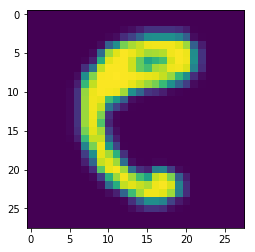

testfile name:  train_e_99502.png
ground truth label:  e
network prediction:  C
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))


/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:54: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Recursion depth: 0, norm: 33030.901490119824, time: 15.02779746055603 

Recursion depth: 1, norm: 60586.881942380896, time: 14.84317135810852 

Recursion depth: 2, norm: 83591.2011996478, time: 15.013752222061157 

Recursion depth: 3, norm: 102795.69632041996, time: 15.281217575073242 

Recursion depth: 4, norm: 118828.38963816686, time: 15.60018014907837 

Recursion depth: 5, norm: 132212.888554785, time: 15.559276342391968 

Recursion depth: 6, norm: 143386.60672461707, time: 15.59927248954773 

Recursion depth: 7, norm: 152714.73784805447, time: 15.552209615707397 

Recursion depth: 8, norm: 160502.13773031186, time: 15.519685983657837 

Recursion depth: 9, norm: 167003.276375046, time: 15.493954181671143 

Recursion depth: 10, norm: 172430.4355733059, time: 15.535463094711304 

Recursion depth: 11, norm: 176961.16233795483, time: 15.254961252212524 

Recursion depth: 12, norm: 180743.44586733982, time: 14.837663173675537 

Recursion depth: 13, norm: 183900.87014476032, time: 15.025

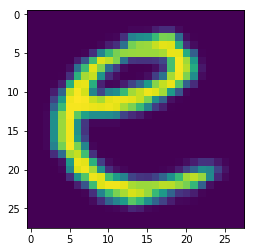

training set name:  train_e_89096.png
training set label:  C
IF measure:  0.0156703039053
train_e_89096.png


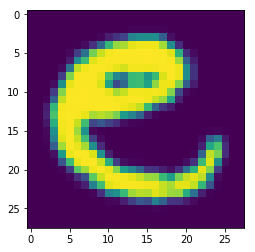

training set name:  train_e_3645.png
training set label:  C
IF measure:  0.0153199571878
train_e_3645.png


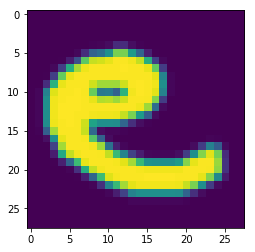

training set name:  train_e_48430.png
training set label:  C
IF measure:  0.0146975744067
train_e_48430.png


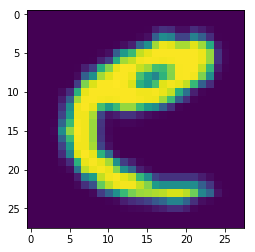

training set name:  train_e_59852.png
training set label:  R
IF measure:  0.0137615112442
train_e_59852.png


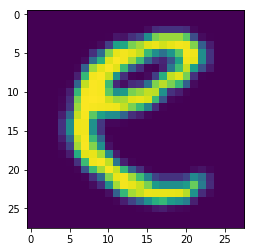

training set name:  train_e_46760.png
training set label:  r
IF measure:  0.0114128876134
train_e_46760.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:62: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


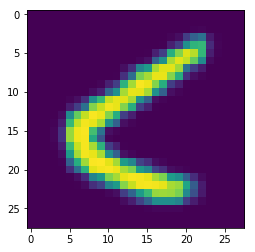

training set name:  train_e_81306.png
training set label:  e
IF measure:  -0.0170722680206
train_e_81306.png


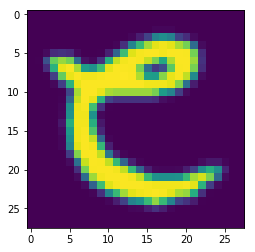

training set name:  train_e_12628.png
training set label:  e
IF measure:  -0.0169741294697
train_e_12628.png


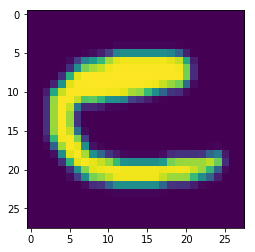

training set name:  train_e_91422.png
training set label:  e
IF measure:  -0.0169010615941
train_e_91422.png


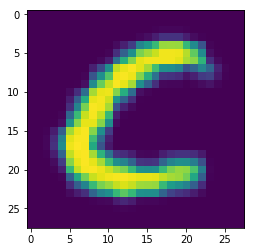

training set name:  train_C_88067.png
training set label:  e
IF measure:  -0.016707020998
train_C_88067.png


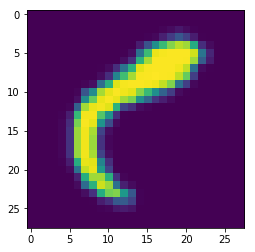

training set name:  train_e_82816.png
training set label:  e
IF measure:  -0.0162215221013
train_e_82816.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:79: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


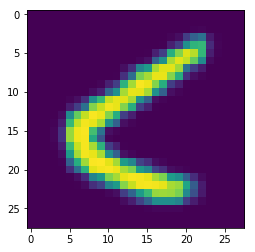

training set name:  train_e_81306.png
training set label:  e
IF measure:  -0.0170722680206


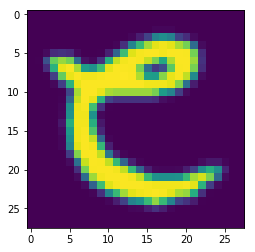

training set name:  train_e_12628.png
training set label:  e
IF measure:  -0.0169741294697


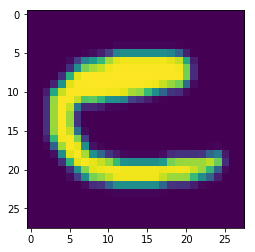

training set name:  train_e_91422.png
training set label:  e
IF measure:  -0.0169010615941


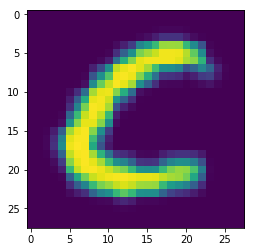

training set name:  train_C_88067.png
training set label:  e
IF measure:  -0.016707020998


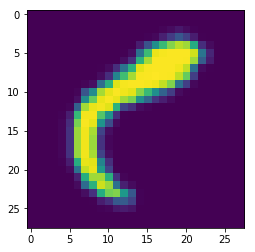

training set name:  train_e_82816.png
training set label:  e
IF measure:  -0.0162215221013

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:105: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


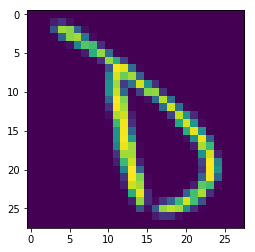

training set name:  train_D_1156.png
training set label:  D
IF measure:  -4.5902004089e-10


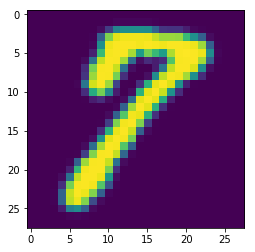

training set name:  train_7_94431.png
training set label:  7
IF measure:  9.53766452735e-10


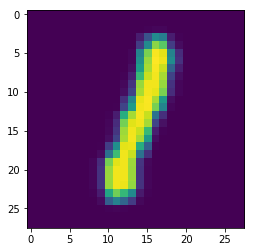

training set name:  train_L_67887.png
training set label:  n
IF measure:  1.40236342633e-09


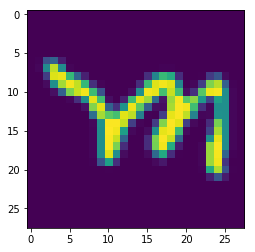

training set name:  train_M_48222.png
training set label:  9
IF measure:  1.63085687681e-09


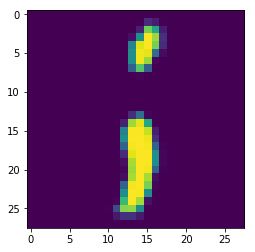

training set name:  train_J_58716.png
training set label:  J
IF measure:  -1.70730603429e-09


/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:120: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


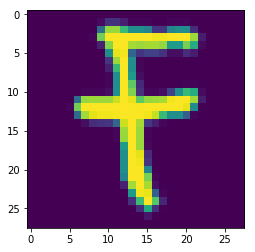

testfile name:  train_F_50837.png
ground truth label:  F
network prediction:  F
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 13076.479409611748, time: 14.929794311523438 

Recursion depth: 1, norm: 23981.741472680835, time: 15.128966808319092 

Recursion depth: 2, norm: 33085.70987223941, time: 15.455010890960693 

Recursion depth: 3, norm: 40686.00243019705, time: 15.417428493499756 

Recursion depth: 4, norm: 47030.77080220991, time: 15.367995738983154 

Recursion depth: 5, norm: 52327.470945001725, time: 16.487308740615845 

Recursion depth: 6, norm: 56749.417345026544, time: 16.25973081588745 

Recursion depth: 7, norm: 60440.857253185946, time: 15.88622498512268 

Recursion depth: 8, norm: 63522.47650241606, time: 15.791402101516724 

Recursion depth: 9, norm: 66095.13184040108, time: 15.488224506378174 

Recursion depth: 10, norm: 68242.86284660104, time: 15.049854755401611 

Recursion depth: 11, norm: 70035.61813463204, time: 14.710105895

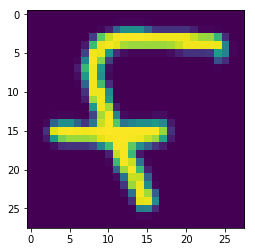

training set name:  train_f_43880.png
training set label:  f
IF measure:  0.00496761509026
train_f_43880.png


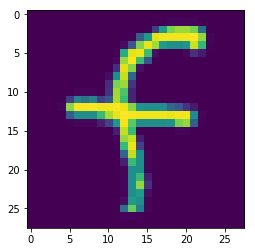

training set name:  train_f_84454.png
training set label:  f
IF measure:  0.00394748137564
train_f_84454.png


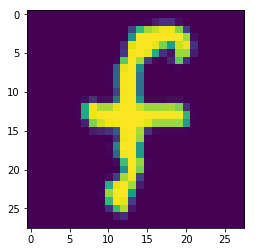

training set name:  train_f_90023.png
training set label:  f
IF measure:  0.00356191282312
train_f_90023.png


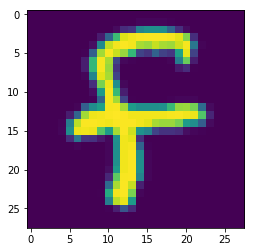

training set name:  train_f_105016.png
training set label:  f
IF measure:  0.00347973757972
train_f_105016.png


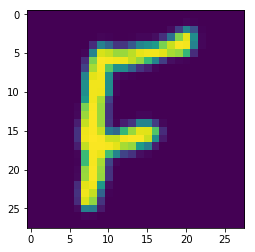

training set name:  train_f_88645.png
training set label:  f
IF measure:  0.00337474176541
train_f_88645.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



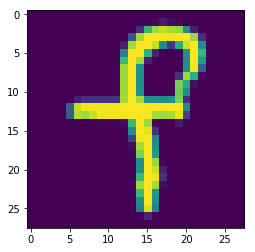

training set name:  train_F_91322.png
training set label:  F
IF measure:  -0.00505498539102
train_F_91322.png


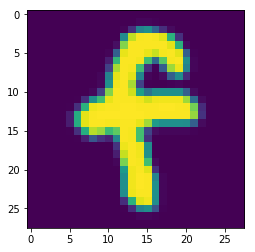

training set name:  train_F_2148.png
training set label:  F
IF measure:  -0.00504985947347
train_F_2148.png


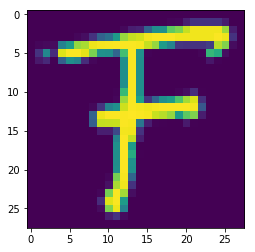

training set name:  train_F_22007.png
training set label:  F
IF measure:  -0.00500509401797
train_F_22007.png


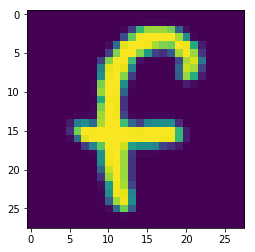

training set name:  train_f_69551.png
training set label:  F
IF measure:  -0.00494249174041
train_f_69551.png


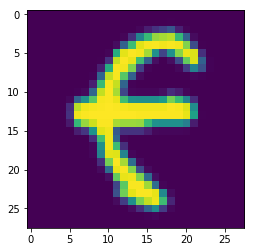

training set name:  train_F_108956.png
training set label:  F
IF measure:  -0.0048705491561
train_F_108956.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



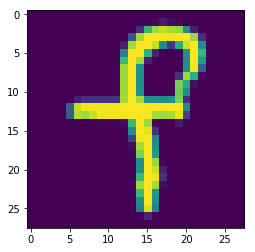

training set name:  train_F_91322.png
training set label:  F
IF measure:  -0.00505498539102


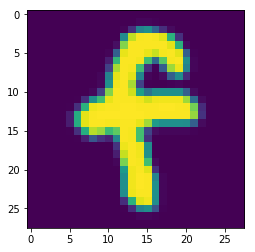

training set name:  train_F_2148.png
training set label:  F
IF measure:  -0.00504985947347


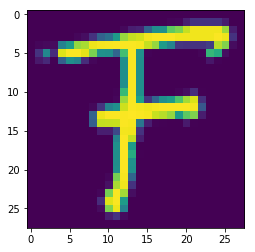

training set name:  train_F_22007.png
training set label:  F
IF measure:  -0.00500509401797


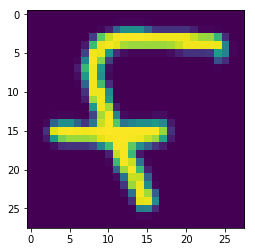

training set name:  train_f_43880.png
training set label:  f
IF measure:  0.00496761509026


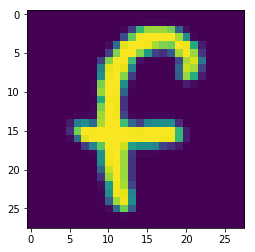

training set name:  train_f_69551.png
training set label:  F
IF measure:  -0.00494249174041

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



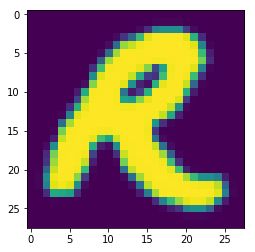

training set name:  train_R_17890.png
training set label:  R
IF measure:  -3.18101415972e-11


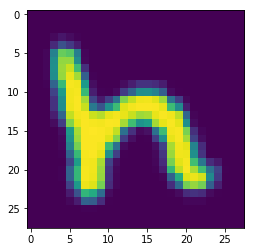

training set name:  train_h_108326.png
training set label:  h
IF measure:  -8.59317685567e-11


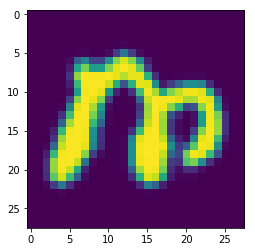

training set name:  train_M_42805.png
training set label:  a
IF measure:  -1.85701240988e-10


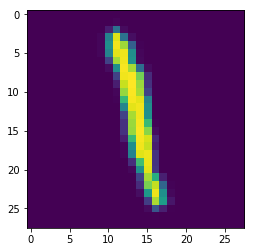

training set name:  train_1_80498.png
training set label:  1
IF measure:  4.62856689461e-10


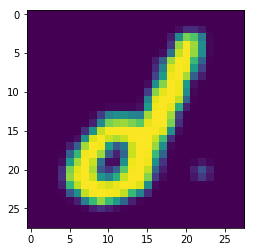

training set name:  train_d_105421.png
training set label:  d
IF measure:  -5.87943817509e-10


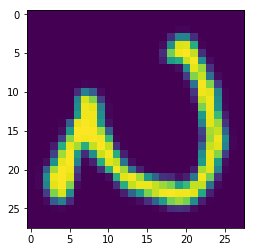

testfile name:  train_N_111767.png
ground truth label:  N
network prediction:  N
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 13756.423057748334, time: 14.667683124542236 

Recursion depth: 1, norm: 25229.279820280244, time: 14.741171598434448 

Recursion depth: 2, norm: 34806.94281138463, time: 14.675777435302734 

Recursion depth: 3, norm: 42802.71228555499, time: 14.849719762802124 

Recursion depth: 4, norm: 49477.80636810812, time: 14.805145502090454 

Recursion depth: 5, norm: 55050.15477271612, time: 14.909558057785034 

Recursion depth: 6, norm: 59702.23045875254, time: 14.78676462173462 

Recursion depth: 7, norm: 63585.61012524768, time: 14.849283218383789 

Recursion depth: 8, norm: 66827.76132716103, time: 14.683412075042725 

Recursion depth: 9, norm: 69534.18942865444, time: 15.056984424591064 

Recursion depth: 10, norm: 71793.69215676263, time: 14.724466323852539 

Recursion depth: 11, norm: 73679.92765672345, time: 14.9478707313

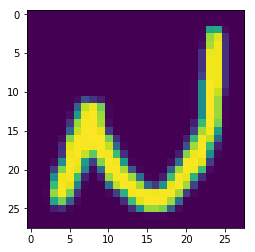

training set name:  train_N_77692.png
training set label:  K
IF measure:  0.00669584685395
train_N_77692.png


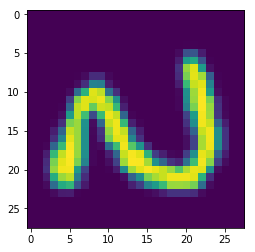

training set name:  train_N_29699.png
training set label:  d
IF measure:  0.00615614885134
train_N_29699.png


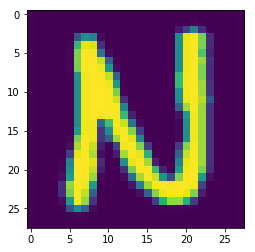

training set name:  train_N_11666.png
training set label:  8
IF measure:  0.00600166748813
train_N_11666.png


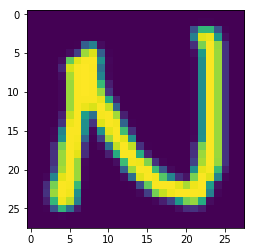

training set name:  train_N_109136.png
training set label:  C
IF measure:  0.00578832274686
train_N_109136.png


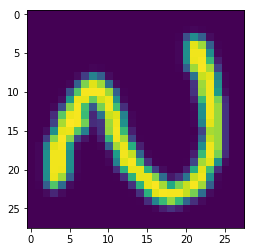

training set name:  train_N_96757.png
training set label:  8
IF measure:  0.00542311130739
train_N_96757.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



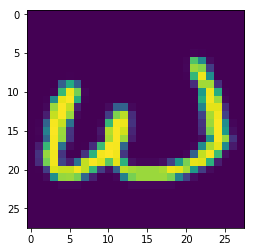

training set name:  train_W_73743.png
training set label:  N
IF measure:  -0.00643776266287
train_W_73743.png


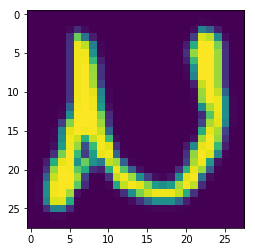

training set name:  train_N_66482.png
training set label:  N
IF measure:  -0.00631393339247
train_N_66482.png


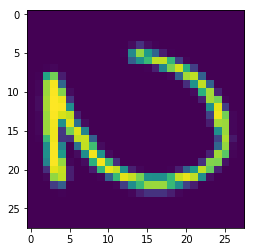

training set name:  train_N_102248.png
training set label:  N
IF measure:  -0.00606551463617
train_N_102248.png


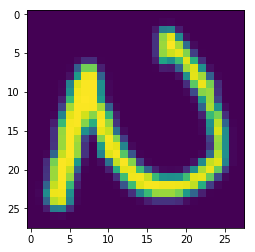

training set name:  train_N_7748.png
training set label:  N
IF measure:  -0.00605622664728
train_N_7748.png


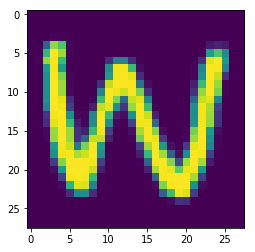

training set name:  train_W_27482.png
training set label:  N
IF measure:  -0.00587957994946
train_W_27482.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



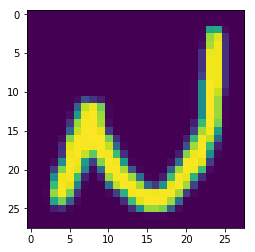

training set name:  train_N_77692.png
training set label:  K
IF measure:  0.00669584685395


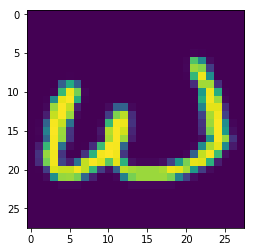

training set name:  train_W_73743.png
training set label:  N
IF measure:  -0.00643776266287


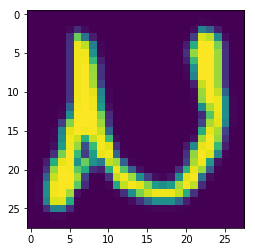

training set name:  train_N_66482.png
training set label:  N
IF measure:  -0.00631393339247


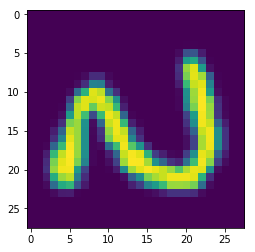

training set name:  train_N_29699.png
training set label:  d
IF measure:  0.00615614885134


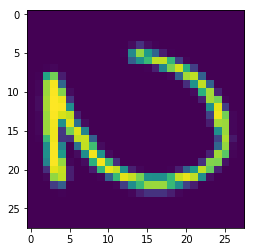

training set name:  train_N_102248.png
training set label:  N
IF measure:  -0.00606551463617

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



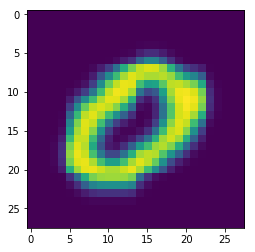

training set name:  train_O_1438.png
training set label:  O
IF measure:  -2.92431976191e-10


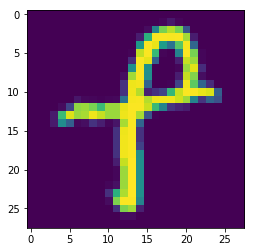

training set name:  train_F_30985.png
training set label:  F
IF measure:  3.05365264989e-10


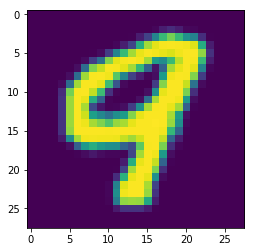

training set name:  train_q_94896.png
training set label:  g
IF measure:  -3.49746510083e-10


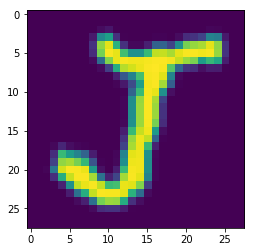

training set name:  train_J_98249.png
training set label:  3
IF measure:  -4.27072910684e-10


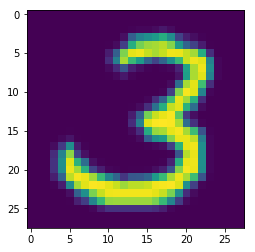

training set name:  train_3_37572.png
training set label:  3
IF measure:  -4.64304785636e-10


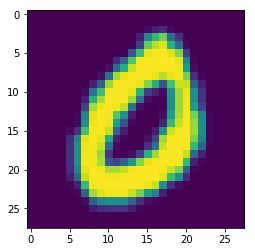

testfile name:  train_O_111780.png
ground truth label:  O
network prediction:  O
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 20760.82854199225, time: 14.994677782058716 

Recursion depth: 1, norm: 38078.59263418227, time: 14.90999984741211 

Recursion depth: 2, norm: 52535.764913057086, time: 14.935701608657837 

Recursion depth: 3, norm: 64605.045120330964, time: 14.82407832145691 

Recursion depth: 4, norm: 74680.62463584515, time: 14.930251121520996 

Recursion depth: 5, norm: 83092.10535303579, time: 14.836123704910278 

Recursion depth: 6, norm: 90114.2964240414, time: 14.765101432800293 

Recursion depth: 7, norm: 95976.09298153369, time: 14.78603982925415 

Recursion depth: 8, norm: 100869.7920291303, time: 14.852153539657593 

Recursion depth: 9, norm: 104955.10582148923, time: 14.944211959838867 

Recursion depth: 10, norm: 108365.63167351538, time: 14.867621183395386 

Recursion depth: 11, norm: 111212.97666189859, time: 15.0169234275

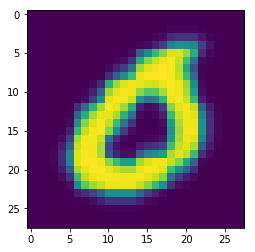

training set name:  train_0_21121.png
training set label:  0
IF measure:  0.0125644218256
train_0_21121.png


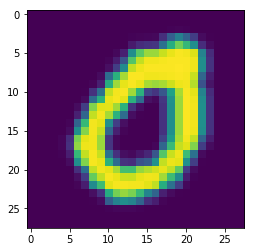

training set name:  train_0_33131.png
training set label:  0
IF measure:  0.0124936692839
train_0_33131.png


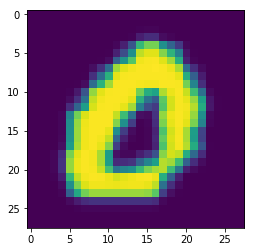

training set name:  train_0_14218.png
training set label:  0
IF measure:  0.0122515442629
train_0_14218.png


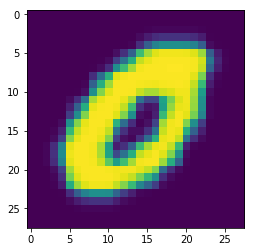

training set name:  train_0_104029.png
training set label:  0
IF measure:  0.0113858398394
train_0_104029.png


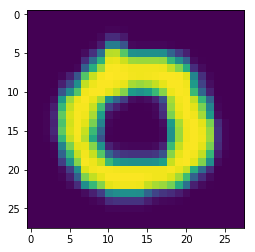

training set name:  train_0_63640.png
training set label:  0
IF measure:  0.0112876403522
train_0_63640.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



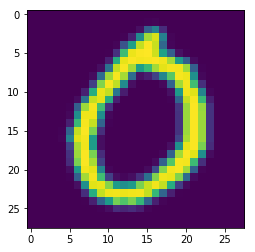

training set name:  train_O_2420.png
training set label:  O
IF measure:  -0.0154331811142
train_O_2420.png


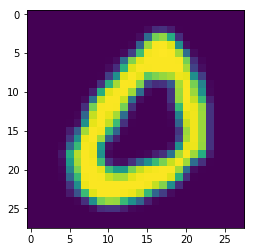

training set name:  train_O_53422.png
training set label:  O
IF measure:  -0.0138502822964
train_O_53422.png


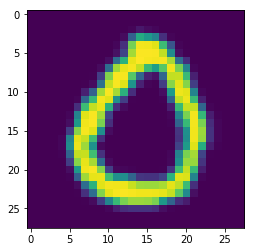

training set name:  train_O_84175.png
training set label:  O
IF measure:  -0.0133866157938
train_O_84175.png


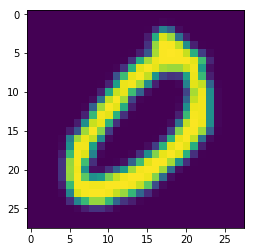

training set name:  train_O_77395.png
training set label:  O
IF measure:  -0.0128013793987
train_O_77395.png


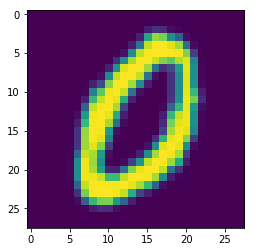

training set name:  train_O_1232.png
training set label:  O
IF measure:  -0.0126441434131
train_O_1232.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



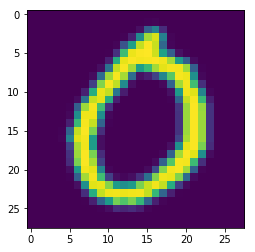

training set name:  train_O_2420.png
training set label:  O
IF measure:  -0.0154331811142


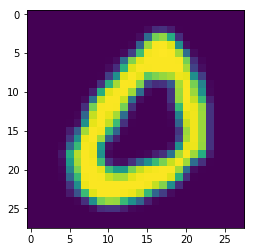

training set name:  train_O_53422.png
training set label:  O
IF measure:  -0.0138502822964


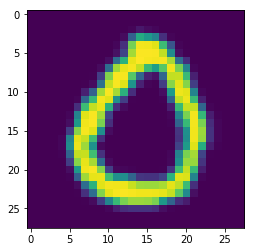

training set name:  train_O_84175.png
training set label:  O
IF measure:  -0.0133866157938


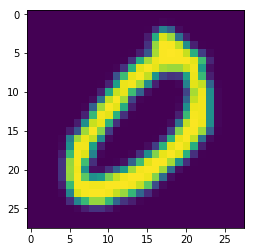

training set name:  train_O_77395.png
training set label:  O
IF measure:  -0.0128013793987


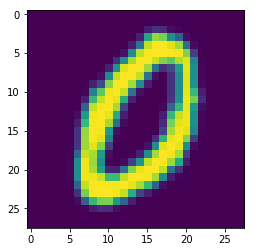

training set name:  train_O_1232.png
training set label:  O
IF measure:  -0.0126441434131

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



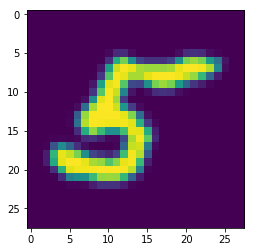

training set name:  train_5_82970.png
training set label:  5
IF measure:  -3.94521547031e-11


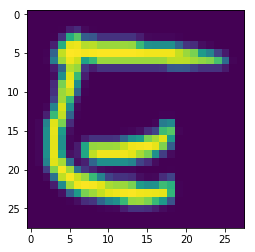

training set name:  train_E_28722.png
training set label:  E
IF measure:  7.15011192885e-11


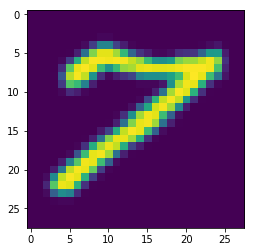

training set name:  train_7_60388.png
training set label:  7
IF measure:  -7.44571383272e-11


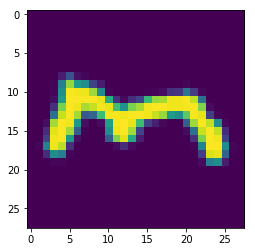

training set name:  train_M_6030.png
training set label:  M
IF measure:  5.89038275051e-10


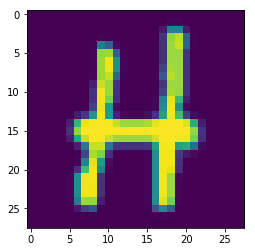

training set name:  train_H_5633.png
training set label:  H
IF measure:  -7.59604814667e-10


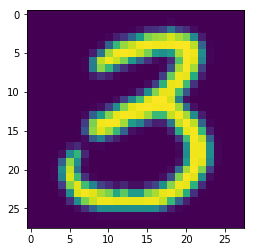

testfile name:  train_3_13588.png
ground truth label:  3
network prediction:  3
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 18514.626846091174, time: 14.633047103881836 

Recursion depth: 1, norm: 33957.959017364396, time: 14.636813402175903 

Recursion depth: 2, norm: 46850.655083467085, time: 14.677116394042969 

Recursion depth: 3, norm: 57613.628244539505, time: 14.798947095870972 

Recursion depth: 4, norm: 66598.82718937323, time: 14.690566062927246 

Recursion depth: 5, norm: 74099.64726636693, time: 14.88881778717041 

Recursion depth: 6, norm: 80361.39165669047, time: 14.723417520523071 

Recursion depth: 7, norm: 85588.86279183759, time: 14.745811462402344 

Recursion depth: 8, norm: 89952.91892984908, time: 14.900550603866577 

Recursion depth: 9, norm: 93596.07945849015, time: 14.666029214859009 

Recursion depth: 10, norm: 96637.45338118136, time: 14.793912172317505 

Recursion depth: 11, norm: 99176.47080331101, time: 14.933914661

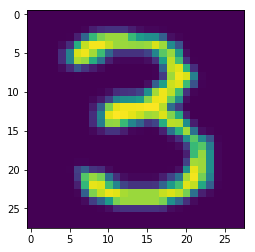

training set name:  train_3_70491.png
training set label:  8
IF measure:  0.00869995421657
train_3_70491.png


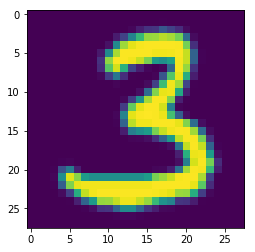

training set name:  train_3_51071.png
training set label:  Q
IF measure:  0.00742881941404
train_3_51071.png


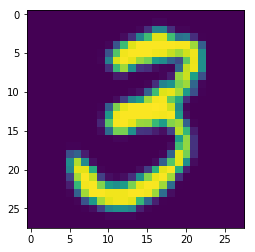

training set name:  train_3_99332.png
training set label:  B
IF measure:  0.00674237206261
train_3_99332.png


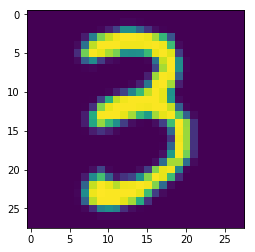

training set name:  train_3_101810.png
training set label:  8
IF measure:  0.00671750878294
train_3_101810.png


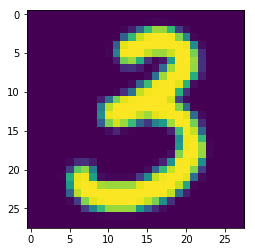

training set name:  train_3_98713.png
training set label:  I
IF measure:  0.00671010353464
train_3_98713.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



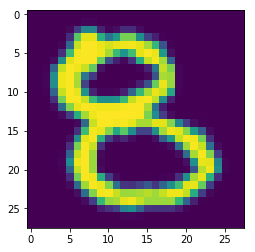

training set name:  train_8_93984.png
training set label:  3
IF measure:  -0.00873487544715
train_8_93984.png


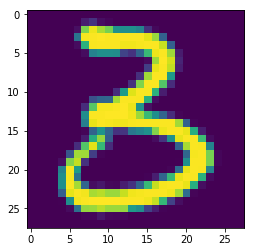

training set name:  train_3_39658.png
training set label:  3
IF measure:  -0.00810656578723
train_3_39658.png


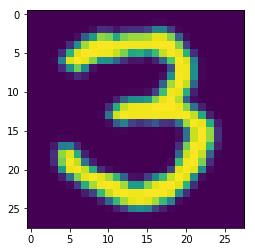

training set name:  train_3_29951.png
training set label:  3
IF measure:  -0.00808159710826
train_3_29951.png


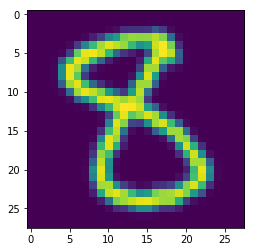

training set name:  train_8_82791.png
training set label:  3
IF measure:  -0.0080416230181
train_8_82791.png


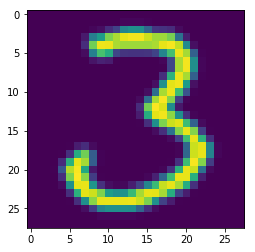

training set name:  train_3_21895.png
training set label:  3
IF measure:  -0.00800387485759
train_3_21895.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



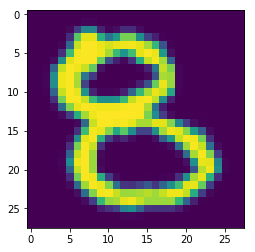

training set name:  train_8_93984.png
training set label:  3
IF measure:  -0.00873487544715


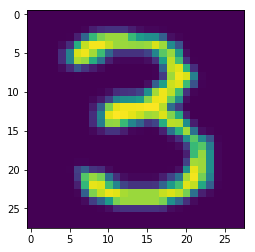

training set name:  train_3_70491.png
training set label:  8
IF measure:  0.00869995421657


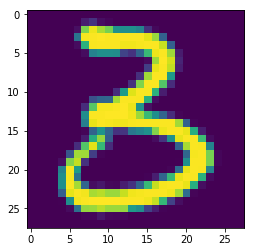

training set name:  train_3_39658.png
training set label:  3
IF measure:  -0.00810656578723


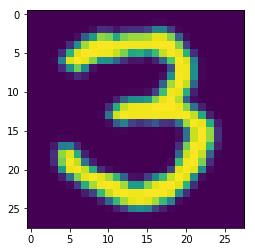

training set name:  train_3_29951.png
training set label:  3
IF measure:  -0.00808159710826


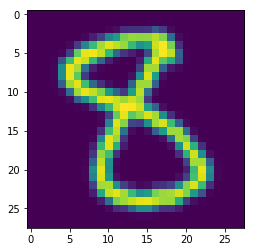

training set name:  train_8_82791.png
training set label:  3
IF measure:  -0.0080416230181

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



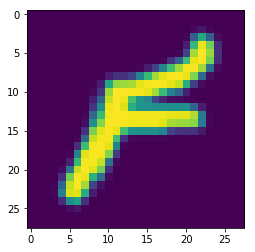

training set name:  train_F_53295.png
training set label:  F
IF measure:  -8.07682897711e-11


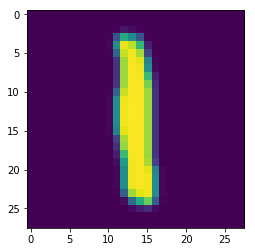

training set name:  train_L_40057.png
training set label:  L
IF measure:  3.28315976769e-10


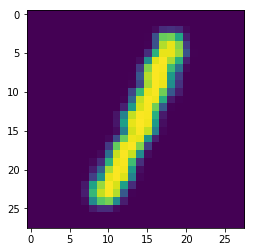

training set name:  train_1_42776.png
training set label:  1
IF measure:  4.36887713083e-10


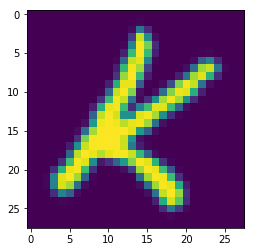

training set name:  train_K_108087.png
training set label:  K
IF measure:  -4.74347929257e-10


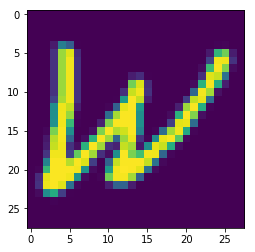

training set name:  train_W_85211.png
training set label:  W
IF measure:  -5.10023826482e-10


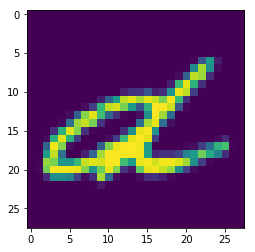

testfile name:  train_d_91856.png
ground truth label:  d
network prediction:  d
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 28592.705966732145, time: 14.903593301773071 

Recursion depth: 1, norm: 52445.87622492354, time: 14.671679735183716 

Recursion depth: 2, norm: 72358.60190053425, time: 14.754721641540527 

Recursion depth: 3, norm: 88982.31708603681, time: 15.050221920013428 

Recursion depth: 4, norm: 102859.95889557802, time: 14.936106443405151 

Recursion depth: 5, norm: 114445.39658719349, time: 14.877902507781982 

Recursion depth: 6, norm: 124117.46918141701, time: 14.722859621047974 

Recursion depth: 7, norm: 132191.864742124, time: 14.869647979736328 

Recursion depth: 8, norm: 138932.39275273425, time: 14.864415884017944 

Recursion depth: 9, norm: 144559.65809312084, time: 14.660494327545166 

Recursion depth: 10, norm: 149257.5861522623, time: 14.71657657623291 

Recursion depth: 11, norm: 153179.64351701568, time: 14.7356801

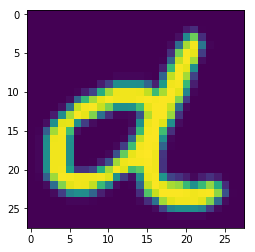

training set name:  train_d_110058.png
training set label:  t
IF measure:  0.0124410757412
train_d_110058.png


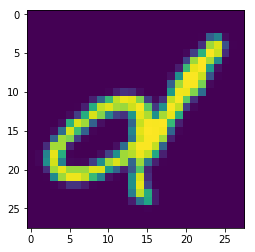

training set name:  train_d_58217.png
training set label:  Q
IF measure:  0.00882352130844
train_d_58217.png


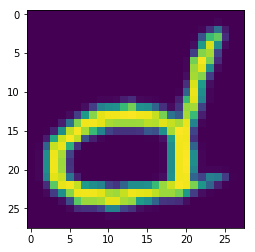

training set name:  train_d_63614.png
training set label:  E
IF measure:  0.00855395555602
train_d_63614.png


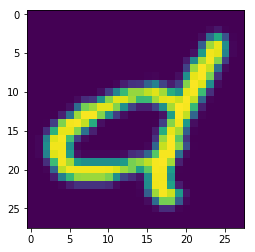

training set name:  train_d_61375.png
training set label:  3
IF measure:  0.00815919630811
train_d_61375.png


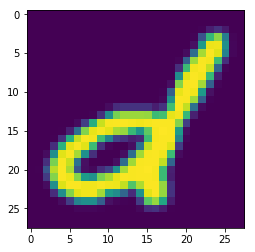

training set name:  train_d_17070.png
training set label:  J
IF measure:  0.00813933794803
train_d_17070.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



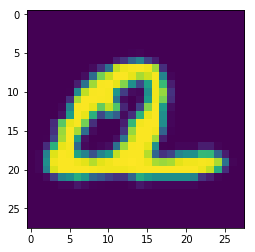

training set name:  train_a_111421.png
training set label:  d
IF measure:  -0.0132582984072
train_a_111421.png


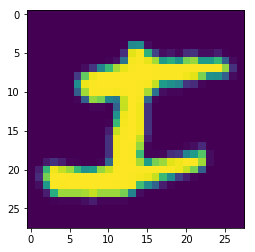

training set name:  train_I_63125.png
training set label:  d
IF measure:  -0.0129767970625
train_I_63125.png


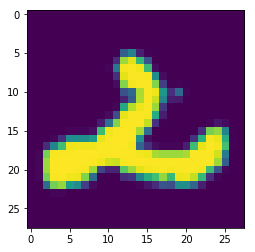

training set name:  train_2_68293.png
training set label:  d
IF measure:  -0.0119804383909
train_2_68293.png


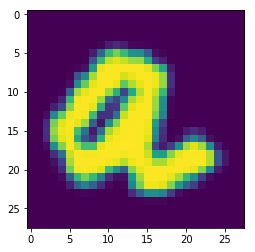

training set name:  train_a_47606.png
training set label:  d
IF measure:  -0.011352185757
train_a_47606.png


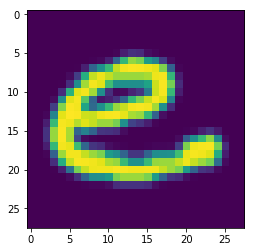

training set name:  train_e_99801.png
training set label:  d
IF measure:  -0.0108369904735
train_e_99801.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



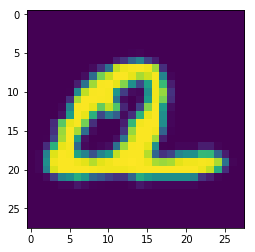

training set name:  train_a_111421.png
training set label:  d
IF measure:  -0.0132582984072


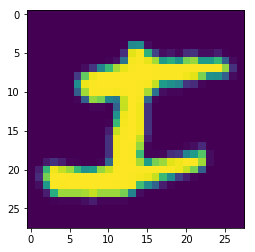

training set name:  train_I_63125.png
training set label:  d
IF measure:  -0.0129767970625


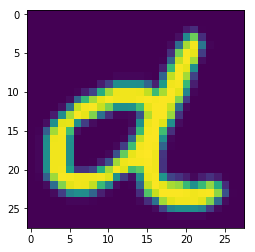

training set name:  train_d_110058.png
training set label:  t
IF measure:  0.0124410757412


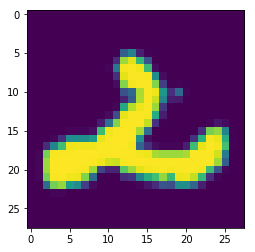

training set name:  train_2_68293.png
training set label:  d
IF measure:  -0.0119804383909


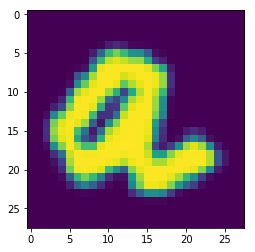

training set name:  train_a_47606.png
training set label:  d
IF measure:  -0.011352185757

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



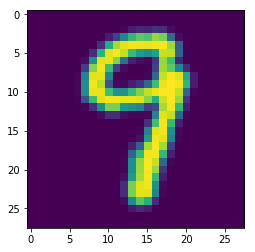

training set name:  train_9_62778.png
training set label:  9
IF measure:  1.58667478525e-10


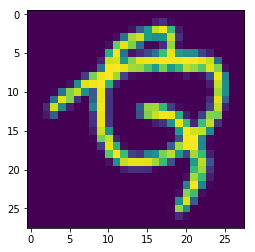

training set name:  train_Q_11753.png
training set label:  Q
IF measure:  -2.73312833358e-10


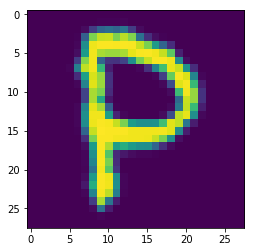

training set name:  train_P_45957.png
training set label:  P
IF measure:  -5.18791258652e-10


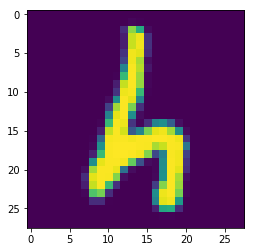

training set name:  train_h_57295.png
training set label:  h
IF measure:  -8.05966952122e-10


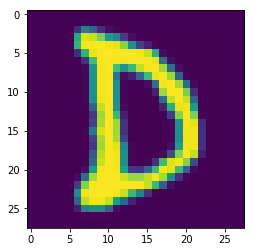

training set name:  train_D_62755.png
training set label:  D
IF measure:  -8.07590013145e-10


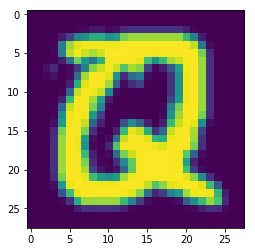

testfile name:  train_Q_53658.png
ground truth label:  Q
network prediction:  Q
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 17749.519146655777, time: 14.732285499572754 

Recursion depth: 1, norm: 32554.638738204423, time: 14.776583909988403 

Recursion depth: 2, norm: 44914.17676524863, time: 14.814723253250122 

Recursion depth: 3, norm: 55232.20721191577, time: 14.622661590576172 

Recursion depth: 4, norm: 63846.047876904646, time: 14.802603006362915 

Recursion depth: 5, norm: 71037.29863951754, time: 14.819084405899048 

Recursion depth: 6, norm: 77040.7267489086, time: 14.747965335845947 

Recursion depth: 7, norm: 82052.43138993505, time: 14.861887693405151 

Recursion depth: 8, norm: 86236.45086620854, time: 14.956110954284668 

Recursion depth: 9, norm: 89729.32885071637, time: 14.770478963851929 

Recursion depth: 10, norm: 92645.2880992876, time: 14.83554220199585 

Recursion depth: 11, norm: 95079.27215224146, time: 14.767727613449

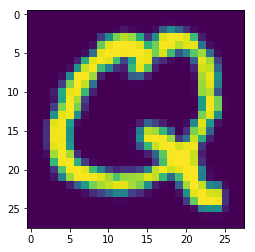

training set name:  train_q_24686.png
training set label:  0
IF measure:  0.00717779453976
train_q_24686.png


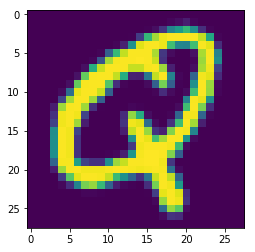

training set name:  train_Q_35174.png
training set label:  G
IF measure:  0.00682494578526
train_Q_35174.png


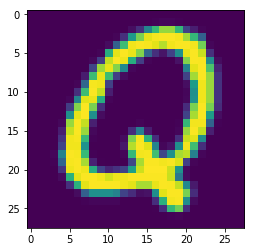

training set name:  train_Q_111958.png
training set label:  B
IF measure:  0.0066598884365
train_Q_111958.png


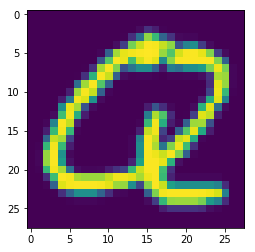

training set name:  train_Q_38335.png
training set label:  I
IF measure:  0.00653246907478
train_Q_38335.png


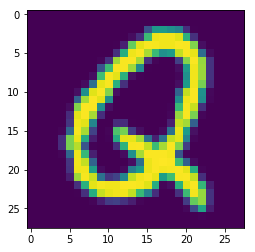

training set name:  train_Q_96372.png
training set label:  3
IF measure:  0.00650494340411
train_Q_96372.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



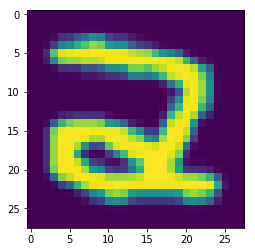

training set name:  train_a_82976.png
training set label:  Q
IF measure:  -0.00807221161453
train_a_82976.png


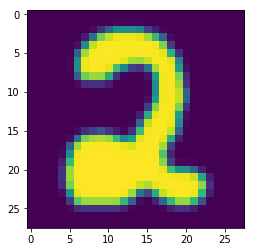

training set name:  train_2_17635.png
training set label:  Q
IF measure:  -0.00692026276432
train_2_17635.png


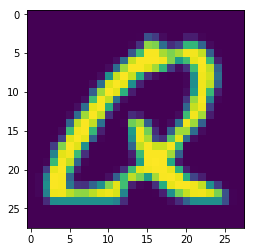

training set name:  train_Q_26863.png
training set label:  Q
IF measure:  -0.00677583026601
train_Q_26863.png


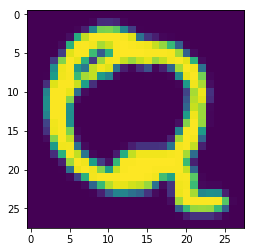

training set name:  train_Q_70193.png
training set label:  Q
IF measure:  -0.00644408889273
train_Q_70193.png


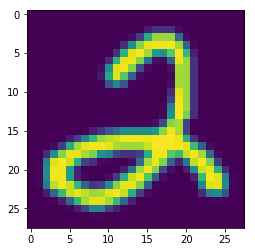

training set name:  train_2_8092.png
training set label:  Q
IF measure:  -0.00625359303985
train_2_8092.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



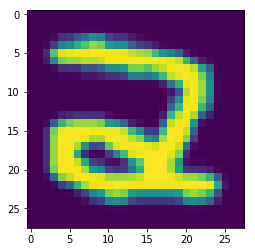

training set name:  train_a_82976.png
training set label:  Q
IF measure:  -0.00807221161453


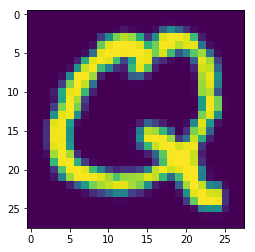

training set name:  train_q_24686.png
training set label:  0
IF measure:  0.00717779453976


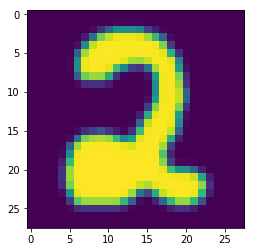

training set name:  train_2_17635.png
training set label:  Q
IF measure:  -0.00692026276432


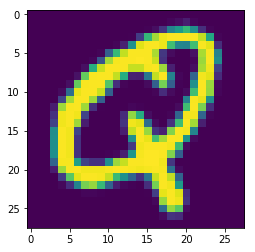

training set name:  train_Q_35174.png
training set label:  G
IF measure:  0.00682494578526


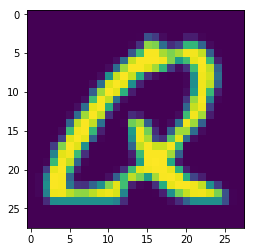

training set name:  train_Q_26863.png
training set label:  Q
IF measure:  -0.00677583026601

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



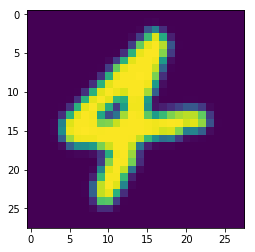

training set name:  train_4_64602.png
training set label:  4
IF measure:  1.91455730072e-10


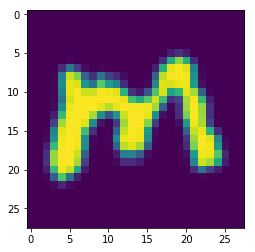

training set name:  train_M_111061.png
training set label:  M
IF measure:  2.53888671158e-10


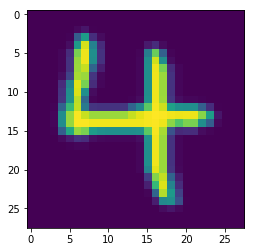

training set name:  train_4_43760.png
training set label:  4
IF measure:  2.59212440322e-10


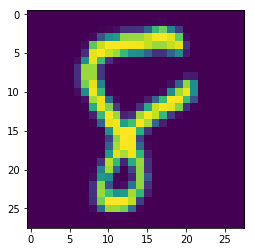

training set name:  train_8_106349.png
training set label:  8
IF measure:  -2.9412929649e-10


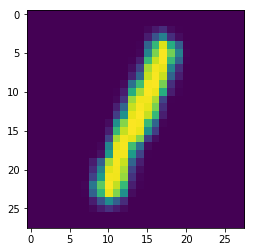

training set name:  train_L_4142.png
training set label:  L
IF measure:  -4.79749424741e-10


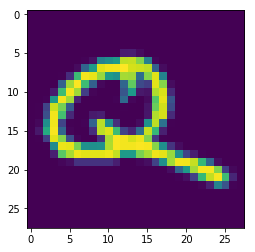

testfile name:  train_Q_78871.png
ground truth label:  Q
network prediction:  Q
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 30133.196129849883, time: 14.699735403060913 

Recursion depth: 1, norm: 55271.477730380975, time: 14.751144409179688 

Recursion depth: 2, norm: 76257.56733597002, time: 14.82153868675232 

Recursion depth: 3, norm: 93777.46268693774, time: 14.984629392623901 

Recursion depth: 4, norm: 108403.58170282013, time: 14.743009567260742 

Recursion depth: 5, norm: 120613.62939568645, time: 14.611233711242676 

Recursion depth: 6, norm: 130807.11742103333, time: 14.759333372116089 

Recursion depth: 7, norm: 139316.79615897, time: 14.837882280349731 

Recursion depth: 8, norm: 146420.8822538643, time: 14.702550649642944 

Recursion depth: 9, norm: 152351.39177572355, time: 14.808963775634766 

Recursion depth: 10, norm: 157302.54128907135, time: 14.863545656204224 

Recursion depth: 11, norm: 161435.86964488408, time: 14.7886037

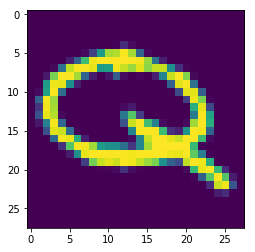

training set name:  train_Q_79694.png
training set label:  E
IF measure:  0.0144572068878
train_Q_79694.png


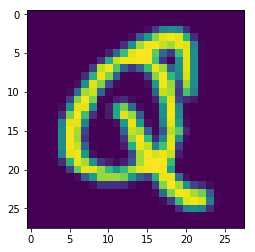

training set name:  train_Q_25370.png
training set label:  0
IF measure:  0.00942715371543
train_Q_25370.png


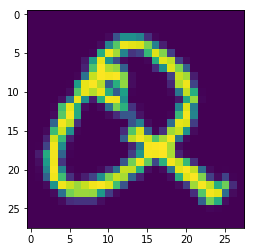

training set name:  train_Q_108735.png
training set label:  2
IF measure:  0.00939147937382
train_Q_108735.png


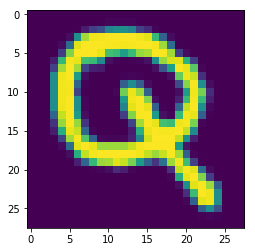

training set name:  train_q_90320.png
training set label:  q
IF measure:  0.0093618884894
train_q_90320.png


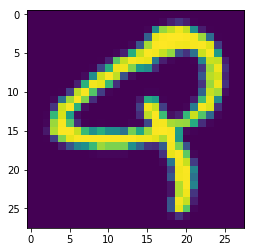

training set name:  train_Q_67332.png
training set label:  f
IF measure:  0.00927553553108
train_Q_67332.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



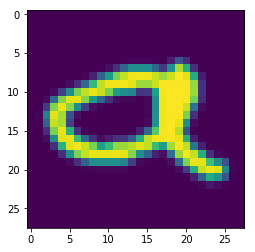

training set name:  train_a_1908.png
training set label:  Q
IF measure:  -0.0151013733964
train_a_1908.png


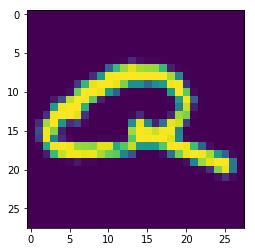

training set name:  train_Q_108340.png
training set label:  Q
IF measure:  -0.0133716473554
train_Q_108340.png


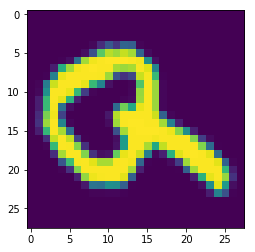

training set name:  train_Q_26285.png
training set label:  Q
IF measure:  -0.0130476968561
train_Q_26285.png


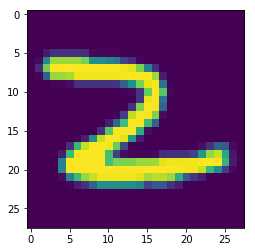

training set name:  train_Z_8863.png
training set label:  Q
IF measure:  -0.012837737154
train_Z_8863.png


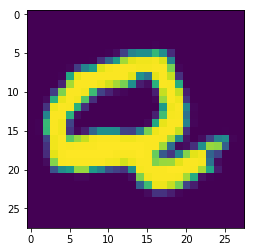

training set name:  train_Q_111228.png
training set label:  Q
IF measure:  -0.0123658179286
train_Q_111228.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



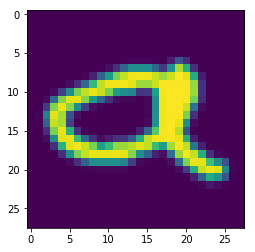

training set name:  train_a_1908.png
training set label:  Q
IF measure:  -0.0151013733964


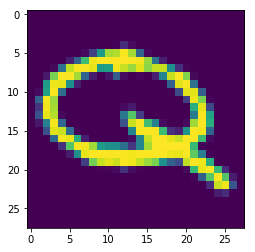

training set name:  train_Q_79694.png
training set label:  E
IF measure:  0.0144572068878


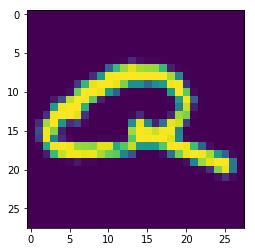

training set name:  train_Q_108340.png
training set label:  Q
IF measure:  -0.0133716473554


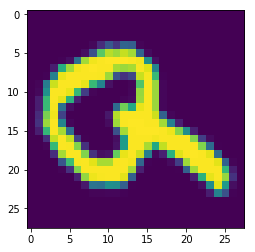

training set name:  train_Q_26285.png
training set label:  Q
IF measure:  -0.0130476968561


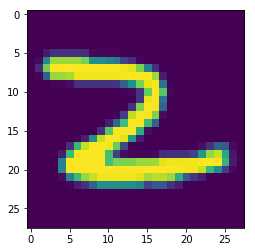

training set name:  train_Z_8863.png
training set label:  Q
IF measure:  -0.012837737154

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



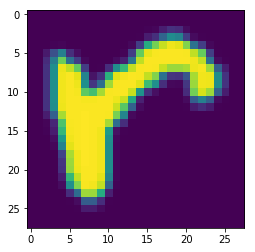

training set name:  train_r_64376.png
training set label:  r
IF measure:  6.99646537711e-11


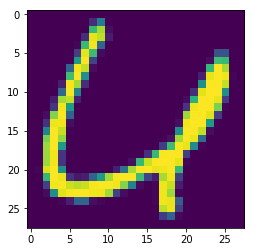

training set name:  train_U_78040.png
training set label:  U
IF measure:  1.99888874562e-10


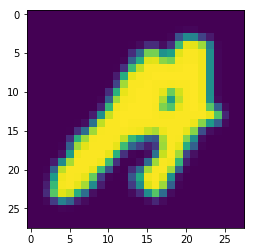

training set name:  train_A_70217.png
training set label:  A
IF measure:  4.21231503579e-10


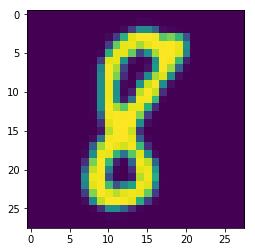

training set name:  train_8_111917.png
training set label:  Z
IF measure:  5.9113285425e-10


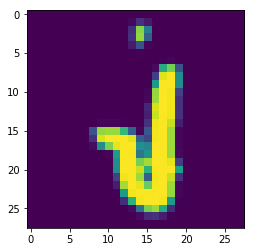

training set name:  train_J_22544.png
training set label:  J
IF measure:  6.97625008352e-10


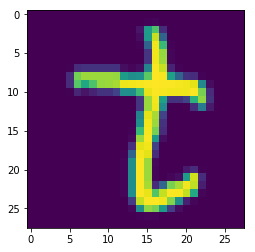

testfile name:  train_t_54202.png
ground truth label:  t
network prediction:  t
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 6225.092096771039, time: 14.743130445480347 

Recursion depth: 1, norm: 11412.056644591938, time: 14.991695642471313 

Recursion depth: 2, norm: 15742.044700220807, time: 14.698603630065918 

Recursion depth: 3, norm: 19356.458809819786, time: 14.660106420516968 

Recursion depth: 4, norm: 22374.003218020687, time: 14.650574684143066 

Recursion depth: 5, norm: 24893.19987215384, time: 15.258548736572266 

Recursion depth: 6, norm: 26996.14494701049, time: 14.658954381942749 

Recursion depth: 7, norm: 28751.67894228092, time: 14.909518241882324 

Recursion depth: 8, norm: 30217.277472912745, time: 14.934473991394043 

Recursion depth: 9, norm: 31440.624884454824, time: 14.715832710266113 

Recursion depth: 10, norm: 32462.1846403627, time: 14.643295764923096 

Recursion depth: 11, norm: 33314.91647895879, time: 14.6842579

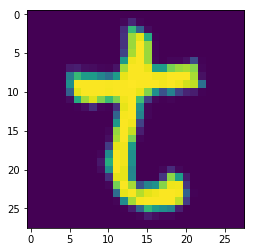

training set name:  train_t_98890.png
training set label:  S
IF measure:  0.00287916841157
train_t_98890.png


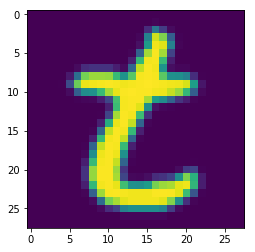

training set name:  train_t_55932.png
training set label:  a
IF measure:  0.00273143888207
train_t_55932.png


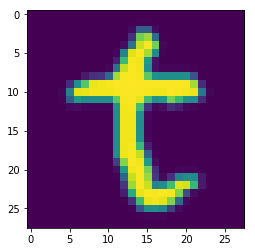

training set name:  train_t_17195.png
training set label:  W
IF measure:  0.00263762682386
train_t_17195.png


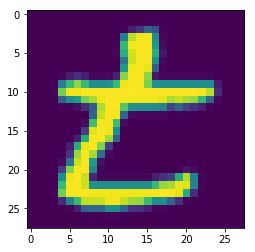

training set name:  train_t_17326.png
training set label:  d
IF measure:  0.00250435613545
train_t_17326.png


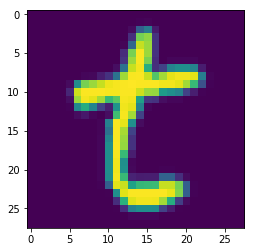

training set name:  train_t_52205.png
training set label:  I
IF measure:  0.00241123340126
train_t_52205.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



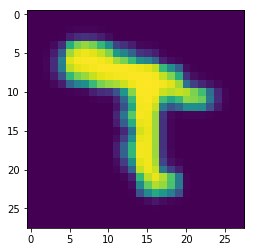

training set name:  train_t_35906.png
training set label:  t
IF measure:  -0.00240012120376
train_t_35906.png


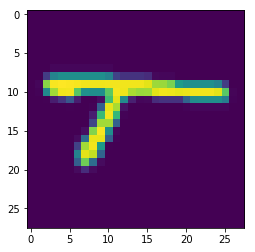

training set name:  train_t_98023.png
training set label:  t
IF measure:  -0.00194464087724
train_t_98023.png


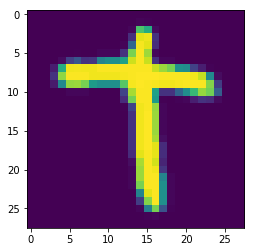

training set name:  train_t_107010.png
training set label:  t
IF measure:  -0.00192983739725
train_t_107010.png


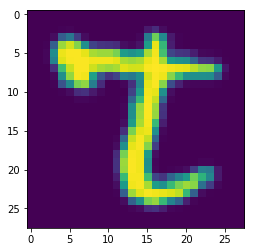

training set name:  train_t_14881.png
training set label:  t
IF measure:  -0.00180606623147
train_t_14881.png


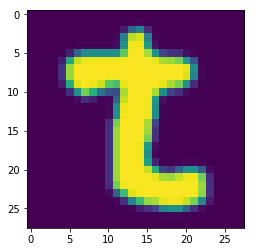

training set name:  train_t_38655.png
training set label:  t
IF measure:  -0.00171587196383
train_t_38655.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



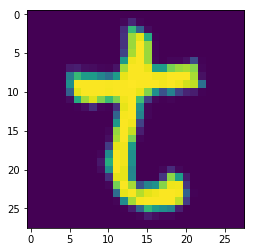

training set name:  train_t_98890.png
training set label:  S
IF measure:  0.00287916841157


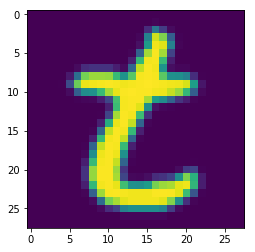

training set name:  train_t_55932.png
training set label:  a
IF measure:  0.00273143888207


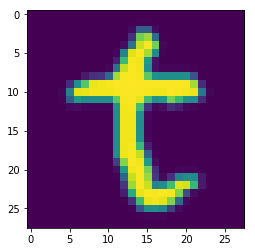

training set name:  train_t_17195.png
training set label:  W
IF measure:  0.00263762682386


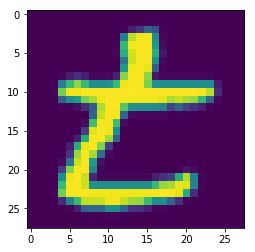

training set name:  train_t_17326.png
training set label:  d
IF measure:  0.00250435613545


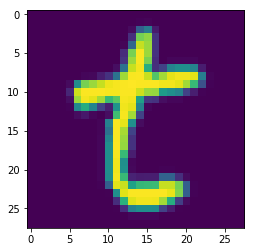

training set name:  train_t_52205.png
training set label:  I
IF measure:  0.00241123340126

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



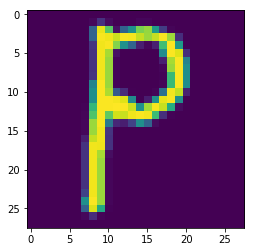

training set name:  train_P_107487.png
training set label:  P
IF measure:  9.46184105061e-11


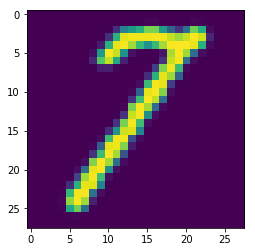

training set name:  train_7_88415.png
training set label:  7
IF measure:  -1.2401637542e-10


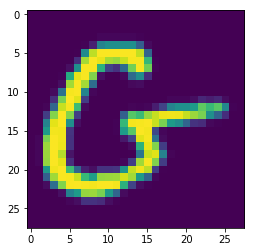

training set name:  train_G_33304.png
training set label:  G
IF measure:  1.29014081057e-10


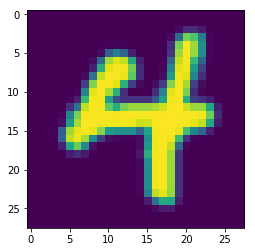

training set name:  train_4_36300.png
training set label:  4
IF measure:  2.17540812157e-10


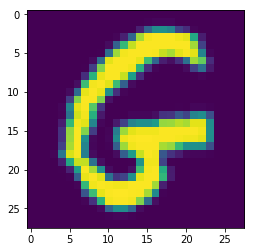

training set name:  train_G_90980.png
training set label:  G
IF measure:  -2.47096809838e-10


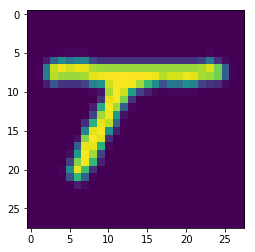

testfile name:  train_T_73395.png
ground truth label:  T
network prediction:  T
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 4080.9036314545274, time: 14.841015338897705 

Recursion depth: 1, norm: 7476.354207913607, time: 14.712906837463379 

Recursion depth: 2, norm: 10310.408359092768, time: 14.691596269607544 

Recursion depth: 3, norm: 12676.098222885857, time: 14.790619611740112 

Recursion depth: 4, norm: 14650.965954716092, time: 14.696869850158691 

Recursion depth: 5, norm: 16299.74774344683, time: 15.012971878051758 

Recursion depth: 6, norm: 17675.885654083926, time: 15.006014823913574 

Recursion depth: 7, norm: 18824.828052833578, time: 14.723792314529419 

Recursion depth: 8, norm: 19783.914877369443, time: 14.812156438827515 

Recursion depth: 9, norm: 20584.57876284453, time: 14.707886934280396 

Recursion depth: 10, norm: 21252.97274721233, time: 14.683817148208618 

Recursion depth: 11, norm: 21810.82429236685, time: 14.71031

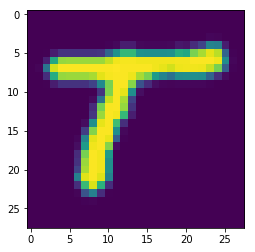

training set name:  train_T_45980.png
training set label:  6
IF measure:  0.00254181913886
train_T_45980.png


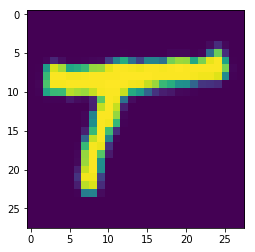

training set name:  train_t_39170.png
training set label:  X
IF measure:  0.00251273941777
train_t_39170.png


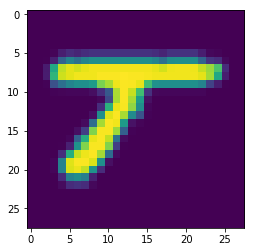

training set name:  train_T_78439.png
training set label:  d
IF measure:  0.00235621840396
train_T_78439.png


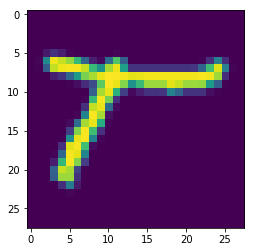

training set name:  train_T_3904.png
training set label:  Y
IF measure:  0.0022403227489
train_T_3904.png


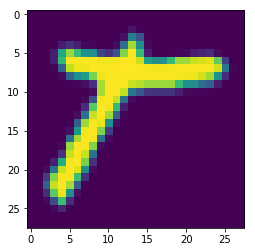

training set name:  train_T_95502.png
training set label:  J
IF measure:  0.00217887057414
train_T_95502.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



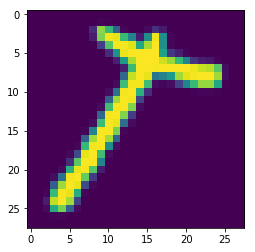

training set name:  train_T_39516.png
training set label:  T
IF measure:  -0.00149943276725
train_T_39516.png


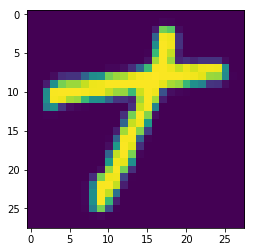

training set name:  train_T_19721.png
training set label:  T
IF measure:  -0.00144633129503
train_T_19721.png


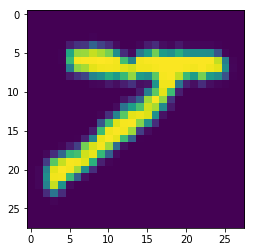

training set name:  train_T_51440.png
training set label:  T
IF measure:  -0.00142974881587
train_T_51440.png


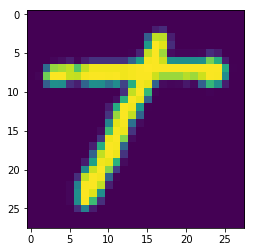

training set name:  train_T_83678.png
training set label:  T
IF measure:  -0.00140788673839
train_T_83678.png


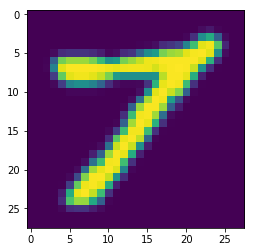

training set name:  train_T_54106.png
training set label:  T
IF measure:  -0.0013965100618
train_T_54106.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



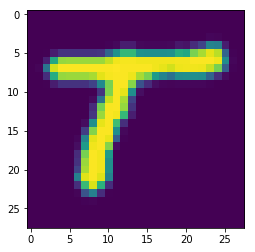

training set name:  train_T_45980.png
training set label:  6
IF measure:  0.00254181913886


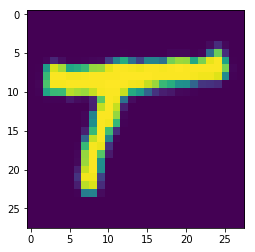

training set name:  train_t_39170.png
training set label:  X
IF measure:  0.00251273941777


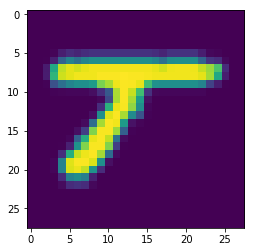

training set name:  train_T_78439.png
training set label:  d
IF measure:  0.00235621840396


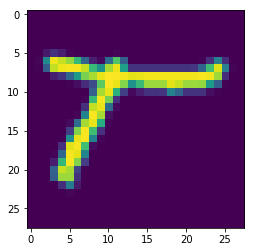

training set name:  train_T_3904.png
training set label:  Y
IF measure:  0.0022403227489


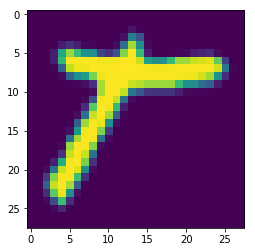

training set name:  train_T_95502.png
training set label:  J
IF measure:  0.00217887057414

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



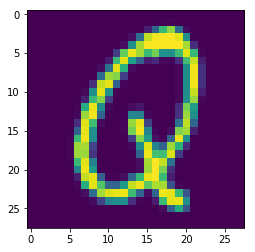

training set name:  train_Q_41000.png
training set label:  Q
IF measure:  -1.36798323654e-11


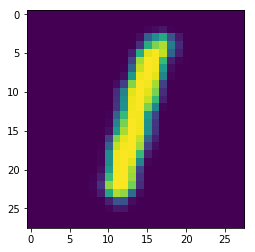

training set name:  train_1_10692.png
training set label:  1
IF measure:  -1.88942686556e-11


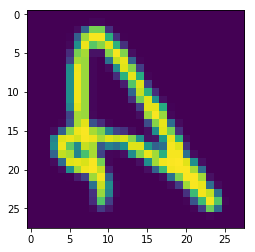

training set name:  train_A_81117.png
training set label:  A
IF measure:  2.94200975638e-11


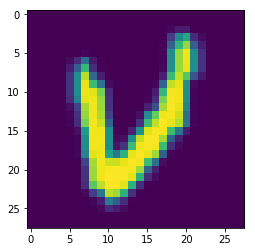

training set name:  train_V_43005.png
training set label:  V
IF measure:  -7.56277096109e-11


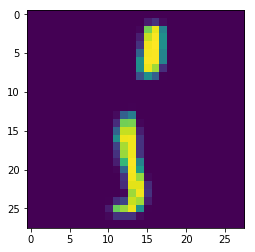

training set name:  train_J_27122.png
training set label:  J
IF measure:  7.8043675856e-11


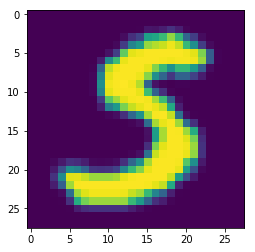

testfile name:  train_S_10301.png
ground truth label:  S
network prediction:  S
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 10005.616856140105, time: 14.70750904083252 

Recursion depth: 1, norm: 18348.593711440124, time: 14.612984657287598 

Recursion depth: 2, norm: 25313.713452395717, time: 14.961538076400757 

Recursion depth: 3, norm: 31128.18303603665, time: 14.783324003219604 

Recursion depth: 4, norm: 35982.08012330582, time: 14.684008121490479 

Recursion depth: 5, norm: 40034.2007694671, time: 14.748003959655762 

Recursion depth: 6, norm: 43417.01686838929, time: 14.656808853149414 

Recursion depth: 7, norm: 46240.62538774752, time: 14.67123794555664 

Recursion depth: 8, norm: 48598.081577362704, time: 14.727609395980835 

Recursion depth: 9, norm: 50565.95721431564, time: 15.015730619430542 

Recursion depth: 10, norm: 52208.91652773499, time: 14.936288356781006 

Recursion depth: 11, norm: 53580.60947301738, time: 14.71703648567

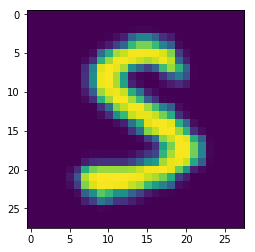

training set name:  train_S_85096.png
training set label:  R
IF measure:  0.00587297389218
train_S_85096.png


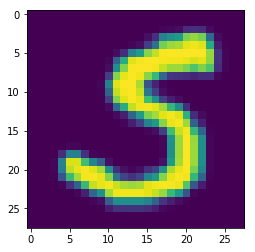

training set name:  train_S_78340.png
training set label:  V
IF measure:  0.00549123775188
train_S_78340.png


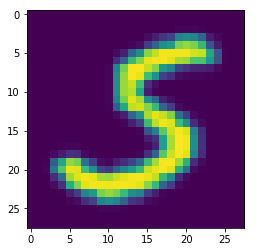

training set name:  train_h_69694.png
training set label:  h
IF measure:  0.00542871838977
train_h_69694.png


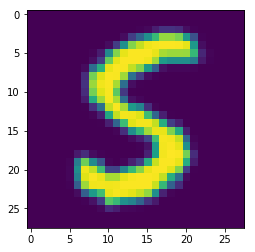

training set name:  train_S_101953.png
training set label:  U
IF measure:  0.00482385244405
train_S_101953.png


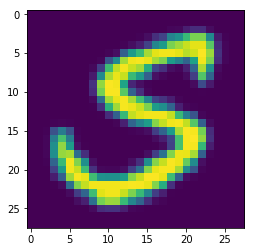

training set name:  train_S_20515.png
training set label:  F
IF measure:  0.00481903570182
train_S_20515.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



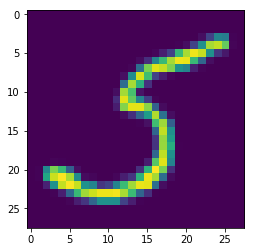

training set name:  train_5_70781.png
training set label:  S
IF measure:  -0.00403280760168
train_5_70781.png


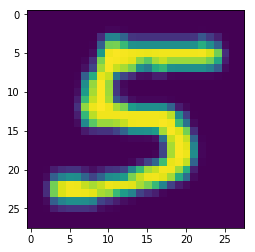

training set name:  train_5_38525.png
training set label:  S
IF measure:  -0.00401188254568
train_5_38525.png


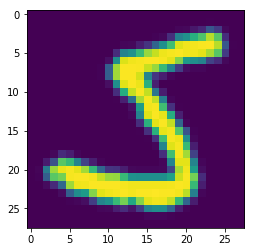

training set name:  train_S_50522.png
training set label:  S
IF measure:  -0.00387582954891
train_S_50522.png


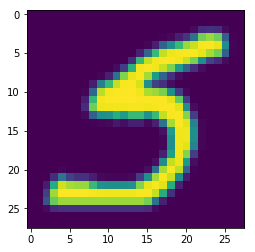

training set name:  train_S_104269.png
training set label:  S
IF measure:  -0.00384165519941
train_S_104269.png


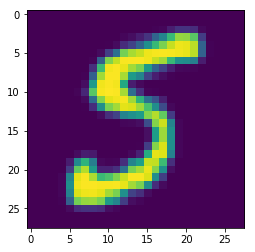

training set name:  train_S_105598.png
training set label:  S
IF measure:  -0.0036763350301
train_S_105598.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



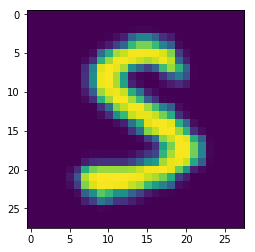

training set name:  train_S_85096.png
training set label:  R
IF measure:  0.00587297389218


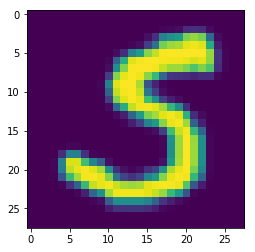

training set name:  train_S_78340.png
training set label:  V
IF measure:  0.00549123775188


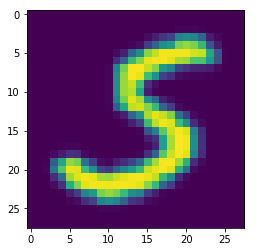

training set name:  train_h_69694.png
training set label:  h
IF measure:  0.00542871838977


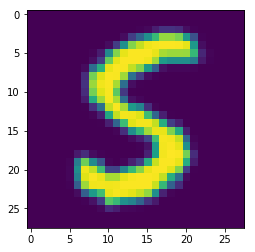

training set name:  train_S_101953.png
training set label:  U
IF measure:  0.00482385244405


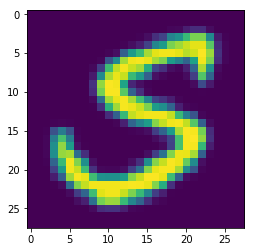

training set name:  train_S_20515.png
training set label:  F
IF measure:  0.00481903570182

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



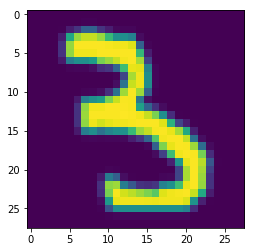

training set name:  train_3_78702.png
training set label:  a
IF measure:  1.07041076082e-10


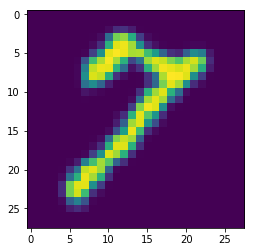

training set name:  train_7_8631.png
training set label:  7
IF measure:  2.46564658682e-10


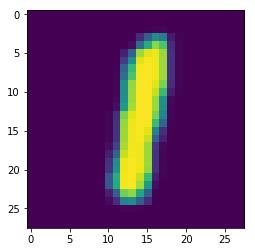

training set name:  train_I_57302.png
training set label:  a
IF measure:  -2.74503239367e-10


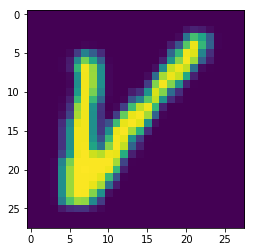

training set name:  train_V_42389.png
training set label:  V
IF measure:  2.8042882311e-10


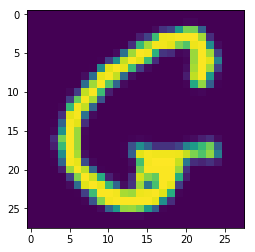

training set name:  train_G_60493.png
training set label:  G
IF measure:  -2.83268817071e-10


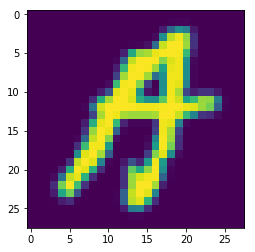

testfile name:  train_A_23922.png
ground truth label:  A
network prediction:  A
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 6456.355569683837, time: 14.76038908958435 

Recursion depth: 1, norm: 11835.036437813573, time: 15.011827230453491 

Recursion depth: 2, norm: 16325.406437321859, time: 14.66764235496521 

Recursion depth: 3, norm: 20074.20977118402, time: 14.665447473526001 

Recursion depth: 4, norm: 23203.606226996268, time: 14.763300657272339 

Recursion depth: 5, norm: 25815.926477176836, time: 14.715719223022461 

Recursion depth: 6, norm: 27997.041138306027, time: 14.83118486404419 

Recursion depth: 7, norm: 29817.632862117007, time: 14.822772741317749 

Recursion depth: 8, norm: 31337.423360496632, time: 14.822232723236084 

Recursion depth: 9, norm: 32606.15069852619, time: 14.79379391670227 

Recursion depth: 10, norm: 33665.436409246206, time: 14.83244800567627 

Recursion depth: 11, norm: 34549.633413395284, time: 14.70825886

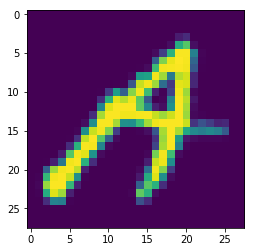

training set name:  train_A_85526.png
training set label:  D
IF measure:  0.00279448357219
train_A_85526.png


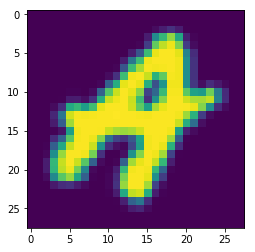

training set name:  train_A_21761.png
training set label:  4
IF measure:  0.00255757668815
train_A_21761.png


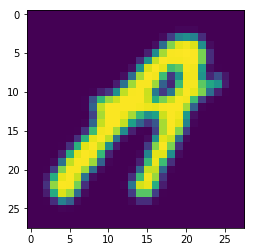

training set name:  train_A_15148.png
training set label:  5
IF measure:  0.00249706737908
train_A_15148.png


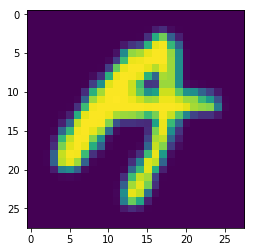

training set name:  train_A_36362.png
training set label:  Y
IF measure:  0.00247784902124
train_A_36362.png


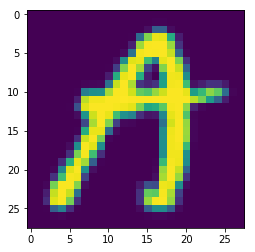

training set name:  train_A_23976.png
training set label:  0
IF measure:  0.00237420410684
train_A_23976.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



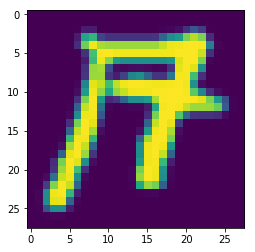

training set name:  train_A_18400.png
training set label:  A
IF measure:  -0.00212818557753
train_A_18400.png


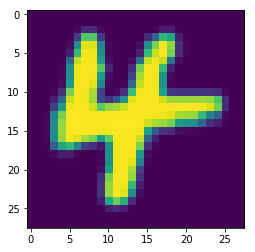

training set name:  train_4_53291.png
training set label:  A
IF measure:  -0.00206994707465
train_4_53291.png


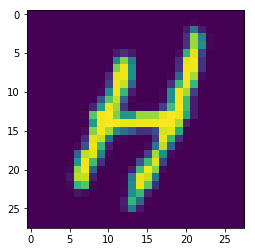

training set name:  train_H_56069.png
training set label:  A
IF measure:  -0.00203466995732
train_H_56069.png


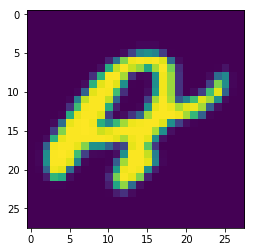

training set name:  train_A_384.png
training set label:  A
IF measure:  -0.00188992992572
train_A_384.png


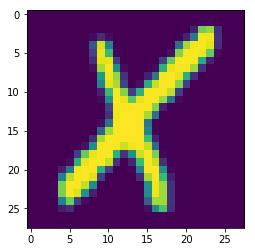

training set name:  train_X_110848.png
training set label:  A
IF measure:  -0.00187924969545
train_X_110848.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



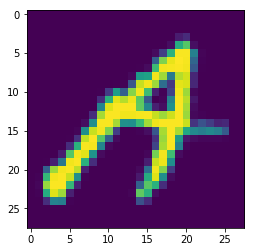

training set name:  train_A_85526.png
training set label:  D
IF measure:  0.00279448357219


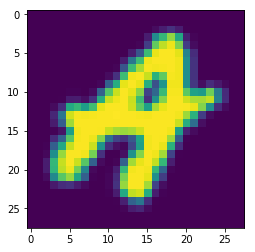

training set name:  train_A_21761.png
training set label:  4
IF measure:  0.00255757668815


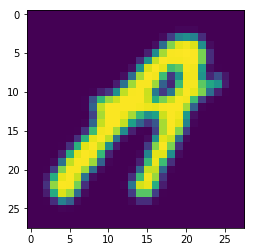

training set name:  train_A_15148.png
training set label:  5
IF measure:  0.00249706737908


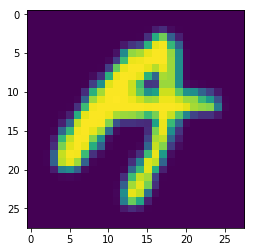

training set name:  train_A_36362.png
training set label:  Y
IF measure:  0.00247784902124


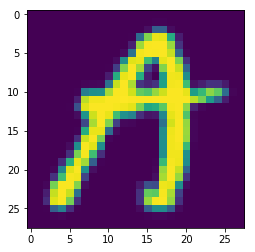

training set name:  train_A_23976.png
training set label:  0
IF measure:  0.00237420410684

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



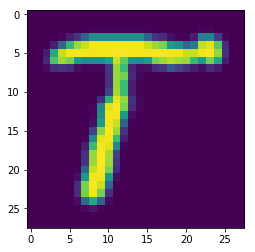

training set name:  train_T_93433.png
training set label:  T
IF measure:  5.00844541569e-11


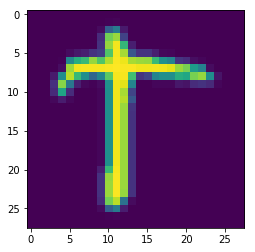

training set name:  train_T_99197.png
training set label:  T
IF measure:  -2.05753502809e-10


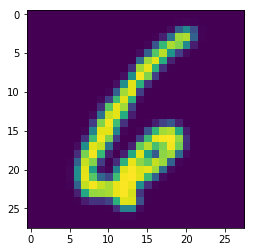

training set name:  train_6_31232.png
training set label:  6
IF measure:  2.85188350791e-10


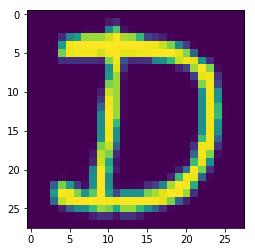

training set name:  train_D_28431.png
training set label:  D
IF measure:  3.76704924779e-10


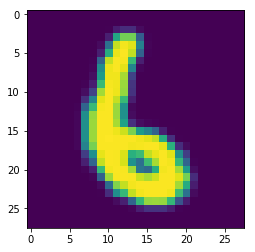

training set name:  train_6_103294.png
training set label:  6
IF measure:  -4.74929102822e-10


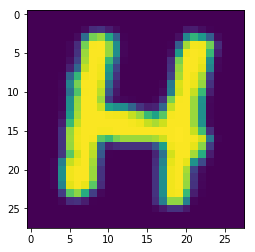

testfile name:  train_H_73655.png
ground truth label:  H
network prediction:  H
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 8363.070822726393, time: 14.872582912445068 

Recursion depth: 1, norm: 15334.158717141936, time: 14.844139814376831 

Recursion depth: 2, norm: 21153.47475445819, time: 14.813467741012573 

Recursion depth: 3, norm: 26011.645100079695, time: 14.853851556777954 

Recursion depth: 4, norm: 30067.441028461333, time: 14.790668725967407 

Recursion depth: 5, norm: 33453.13378444537, time: 15.006281614303589 

Recursion depth: 6, norm: 36279.39871159664, time: 14.805720090866089 

Recursion depth: 7, norm: 38638.93165901459, time: 14.852404117584229 

Recursion depth: 8, norm: 40608.63641209835, time: 14.936485528945923 

Recursion depth: 9, norm: 42252.975170394806, time: 14.719887256622314 

Recursion depth: 10, norm: 43625.83540174331, time: 14.671494483947754 

Recursion depth: 11, norm: 44771.81833195967, time: 14.69146323

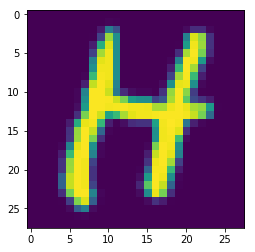

training set name:  train_H_19814.png
training set label:  A
IF measure:  0.00391323597349
train_H_19814.png


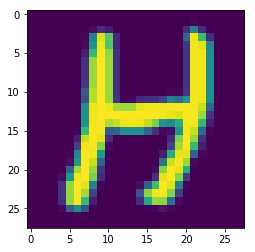

training set name:  train_H_15824.png
training set label:  R
IF measure:  0.0039033091026
train_H_15824.png


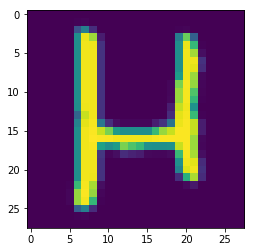

training set name:  train_H_29468.png
training set label:  N
IF measure:  0.00370318051956
train_H_29468.png


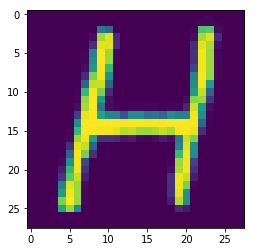

training set name:  train_H_37652.png
training set label:  f
IF measure:  0.00369874235137
train_H_37652.png


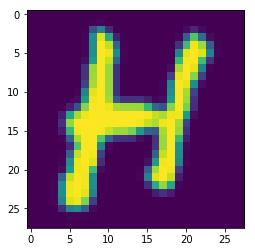

training set name:  train_H_71949.png
training set label:  f
IF measure:  0.00361304174422
train_H_71949.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



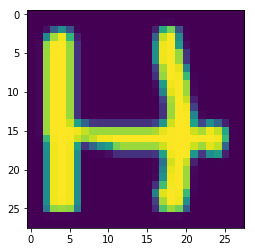

training set name:  train_H_6904.png
training set label:  H
IF measure:  -0.00357883246153
train_H_6904.png


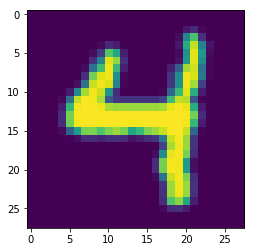

training set name:  train_4_96112.png
training set label:  H
IF measure:  -0.00338417883196
train_4_96112.png


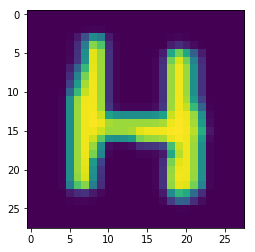

training set name:  train_H_107661.png
training set label:  H
IF measure:  -0.00324315538115
train_H_107661.png


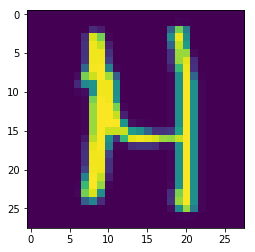

training set name:  train_H_67888.png
training set label:  H
IF measure:  -0.00319535837159
train_H_67888.png


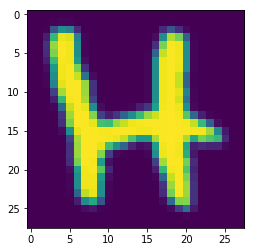

training set name:  train_H_63323.png
training set label:  H
IF measure:  -0.003191569038
train_H_63323.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



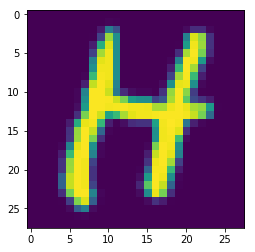

training set name:  train_H_19814.png
training set label:  A
IF measure:  0.00391323597349


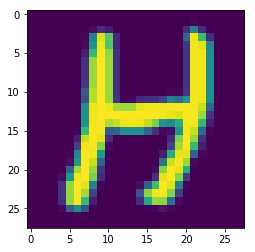

training set name:  train_H_15824.png
training set label:  R
IF measure:  0.0039033091026


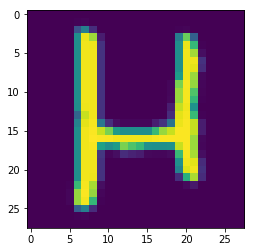

training set name:  train_H_29468.png
training set label:  N
IF measure:  0.00370318051956


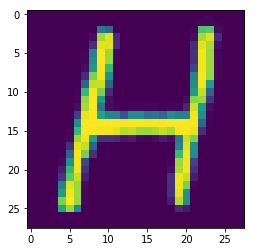

training set name:  train_H_37652.png
training set label:  f
IF measure:  0.00369874235137


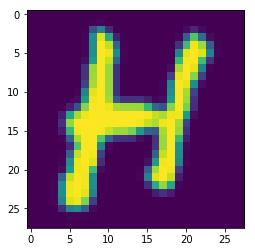

training set name:  train_H_71949.png
training set label:  f
IF measure:  0.00361304174422

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



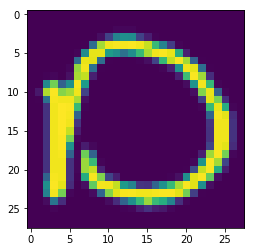

training set name:  train_D_97244.png
training set label:  Y
IF measure:  -1.2805685401e-10


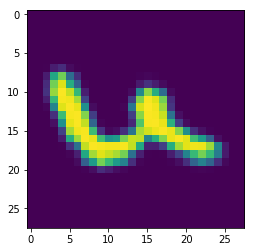

training set name:  train_U_55958.png
training set label:  U
IF measure:  1.77384363463e-10


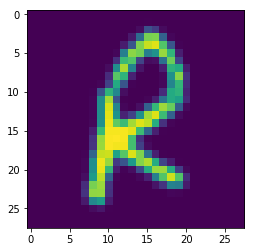

training set name:  train_R_28367.png
training set label:  R
IF measure:  -1.78375132159e-10


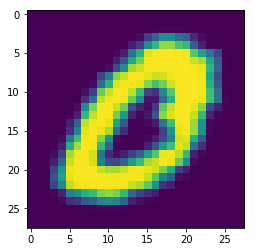

training set name:  train_0_104151.png
training set label:  d
IF measure:  2.24860631927e-10


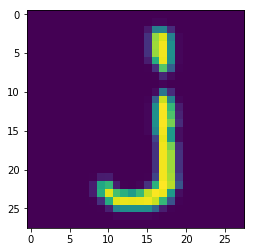

training set name:  train_J_21388.png
training set label:  J
IF measure:  3.13614414186e-10


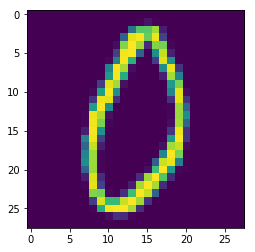

testfile name:  train_O_39312.png
ground truth label:  O
network prediction:  0
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 32330.76884331704, time: 14.748557090759277 

Recursion depth: 1, norm: 59302.591815198095, time: 14.75807785987854 

Recursion depth: 2, norm: 81818.95640986874, time: 14.825604915618896 

Recursion depth: 3, norm: 100616.3163905338, time: 14.692382574081421 

Recursion depth: 4, norm: 116308.57694942364, time: 14.819434642791748 

Recursion depth: 5, norm: 129408.7964243544, time: 15.112401247024536 

Recursion depth: 6, norm: 140345.4371613128, time: 14.678022384643555 

Recursion depth: 7, norm: 149475.48898732528, time: 14.798093318939209 

Recursion depth: 8, norm: 157097.68037752816, time: 14.895472049713135 

Recursion depth: 9, norm: 163460.66364725184, time: 14.982771396636963 

Recursion depth: 10, norm: 168772.50555703675, time: 14.763550758361816 

Recursion depth: 11, norm: 173206.95870547465, time: 14.991651

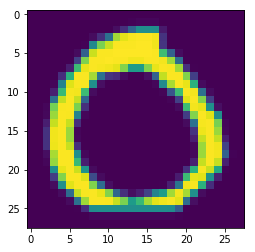

training set name:  train_0_66833.png
training set label:  0
IF measure:  0.0106377817849
train_0_66833.png


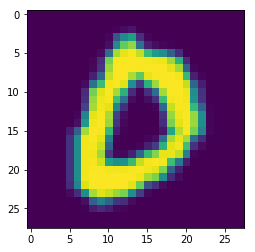

training set name:  train_0_56716.png
training set label:  0
IF measure:  0.0103682592617
train_0_56716.png


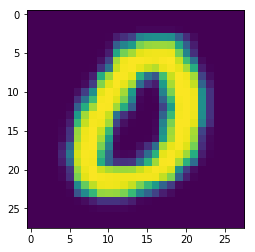

training set name:  train_0_70853.png
training set label:  0
IF measure:  0.0100239537022
train_0_70853.png


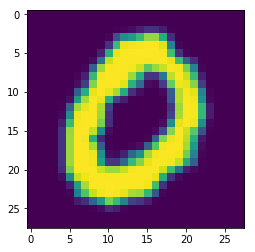

training set name:  train_0_94837.png
training set label:  0
IF measure:  0.00982025674683
train_0_94837.png


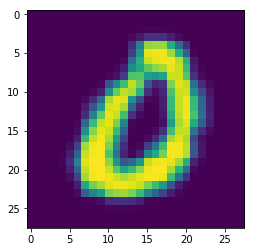

training set name:  train_0_107181.png
training set label:  0
IF measure:  0.00968060691095
train_0_107181.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



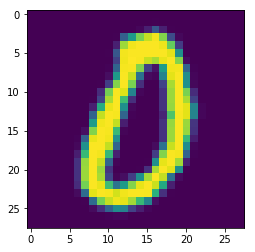

training set name:  train_O_88260.png
training set label:  O
IF measure:  -0.0227193660559
train_O_88260.png


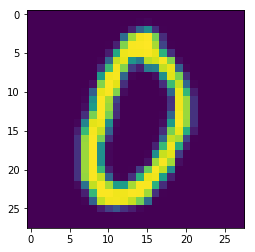

training set name:  train_O_1152.png
training set label:  O
IF measure:  -0.0203139018611
train_O_1152.png


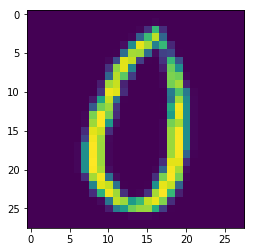

training set name:  train_O_63214.png
training set label:  O
IF measure:  -0.0190033179437
train_O_63214.png


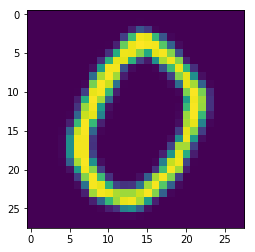

training set name:  train_O_53609.png
training set label:  O
IF measure:  -0.0189548664905
train_O_53609.png


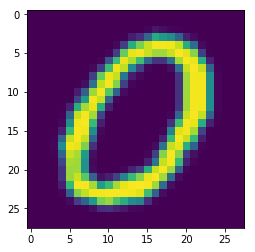

training set name:  train_O_61088.png
training set label:  O
IF measure:  -0.0187670970217
train_O_61088.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



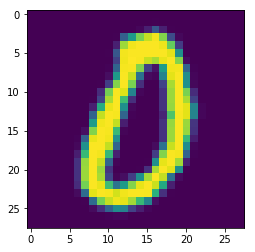

training set name:  train_O_88260.png
training set label:  O
IF measure:  -0.0227193660559


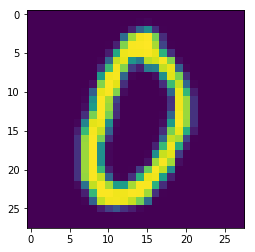

training set name:  train_O_1152.png
training set label:  O
IF measure:  -0.0203139018611


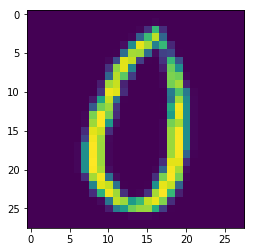

training set name:  train_O_63214.png
training set label:  O
IF measure:  -0.0190033179437


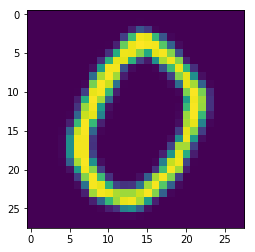

training set name:  train_O_53609.png
training set label:  O
IF measure:  -0.0189548664905


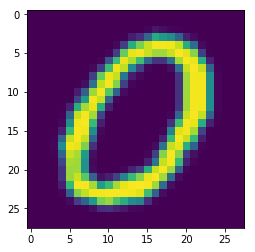

training set name:  train_O_61088.png
training set label:  O
IF measure:  -0.0187670970217

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



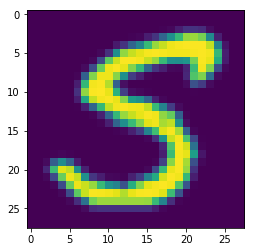

training set name:  train_S_34080.png
training set label:  S
IF measure:  2.58432758251e-11


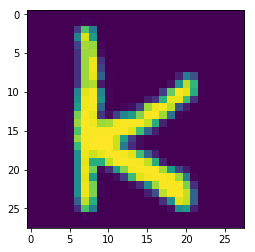

training set name:  train_K_12534.png
training set label:  K
IF measure:  1.7266597671e-10


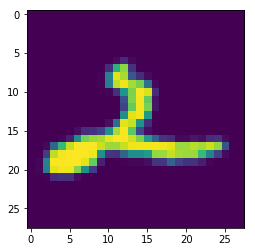

training set name:  train_2_9013.png
training set label:  2
IF measure:  1.85191182169e-10


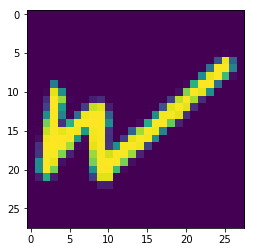

training set name:  train_W_107736.png
training set label:  W
IF measure:  2.02717983613e-10


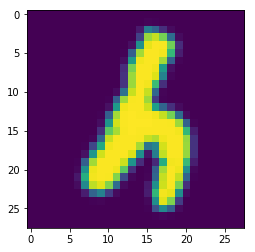

training set name:  train_h_24065.png
training set label:  h
IF measure:  -2.06902626789e-10


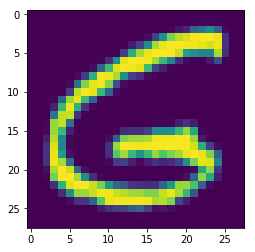

testfile name:  train_G_51896.png
ground truth label:  G
network prediction:  G
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 10743.381306937308, time: 14.664040565490723 

Recursion depth: 1, norm: 19702.19678265599, time: 14.669636726379395 

Recursion depth: 2, norm: 27181.170124049113, time: 14.775480031967163 

Recursion depth: 3, norm: 33424.55780560156, time: 14.920073986053467 

Recursion depth: 4, norm: 38636.637441035164, time: 14.830915927886963 

Recursion depth: 5, norm: 42987.86178097255, time: 14.720555305480957 

Recursion depth: 6, norm: 46620.385822620556, time: 14.866056203842163 

Recursion depth: 7, norm: 49652.75105923135, time: 14.873703479766846 

Recursion depth: 8, norm: 52184.25485479313, time: 14.647032022476196 

Recursion depth: 9, norm: 54297.6799987808, time: 14.83186674118042 

Recursion depth: 10, norm: 56061.91483975552, time: 14.763224840164185 

Recursion depth: 11, norm: 57534.73231014462, time: 14.8835608959

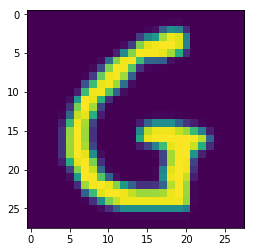

training set name:  train_G_12654.png
training set label:  5
IF measure:  0.00554881487174
train_G_12654.png


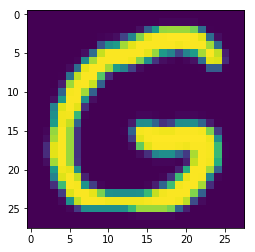

training set name:  train_G_93059.png
training set label:  r
IF measure:  0.0052959509326
train_G_93059.png


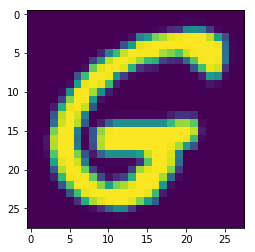

training set name:  train_G_80541.png
training set label:  9
IF measure:  0.00514905572149
train_G_80541.png


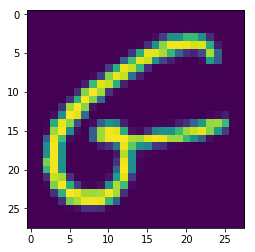

training set name:  train_G_59140.png
training set label:  h
IF measure:  0.00505741738998
train_G_59140.png


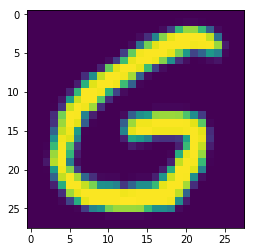

training set name:  train_G_45015.png
training set label:  4
IF measure:  0.00499524697926
train_G_45015.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



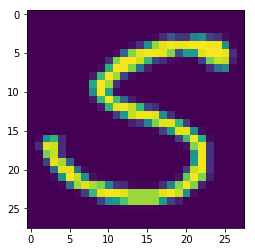

training set name:  train_S_110507.png
training set label:  G
IF measure:  -0.0045159572458
train_S_110507.png


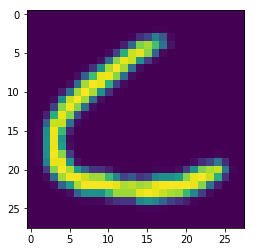

training set name:  train_C_27943.png
training set label:  G
IF measure:  -0.00378389176219
train_C_27943.png


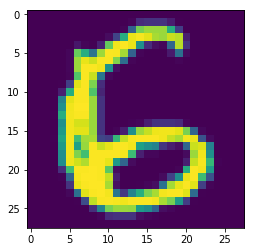

training set name:  train_G_57764.png
training set label:  G
IF measure:  -0.00372128140525
train_G_57764.png


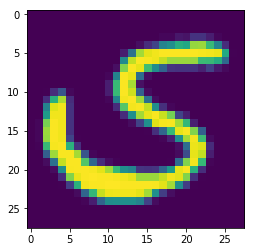

training set name:  train_G_2769.png
training set label:  G
IF measure:  -0.0036701918758
train_G_2769.png


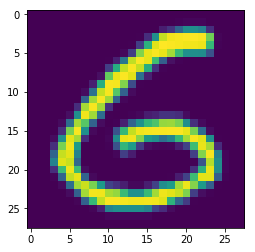

training set name:  train_G_16547.png
training set label:  G
IF measure:  -0.00364267851312
train_G_16547.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



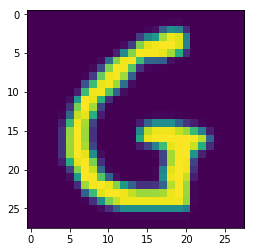

training set name:  train_G_12654.png
training set label:  5
IF measure:  0.00554881487174


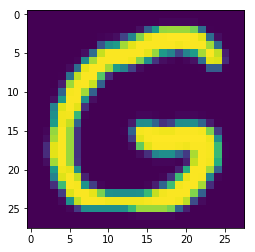

training set name:  train_G_93059.png
training set label:  r
IF measure:  0.0052959509326


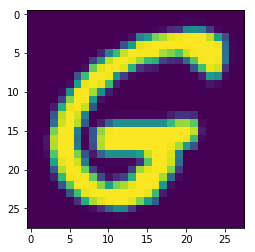

training set name:  train_G_80541.png
training set label:  9
IF measure:  0.00514905572149


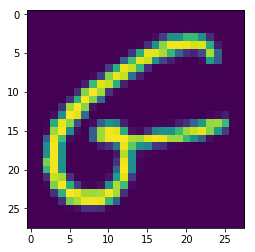

training set name:  train_G_59140.png
training set label:  h
IF measure:  0.00505741738998


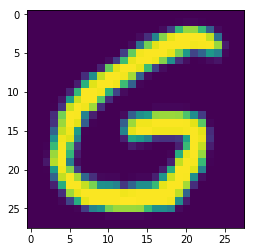

training set name:  train_G_45015.png
training set label:  4
IF measure:  0.00499524697926

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



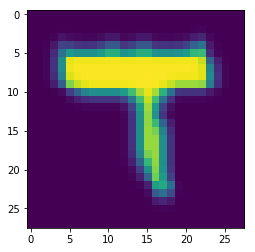

training set name:  train_T_56897.png
training set label:  T
IF measure:  -1.04397736161e-10


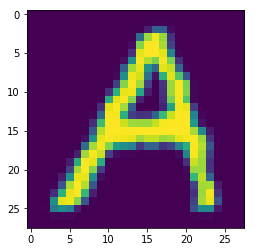

training set name:  train_A_112297.png
training set label:  A
IF measure:  -1.17565413354e-10


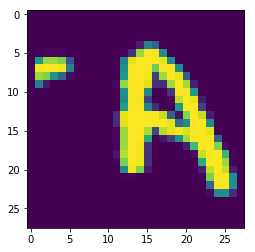

training set name:  train_A_47643.png
training set label:  A
IF measure:  -2.19248856107e-10


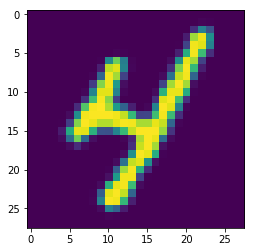

training set name:  train_4_69783.png
training set label:  H
IF measure:  3.34343153006e-10


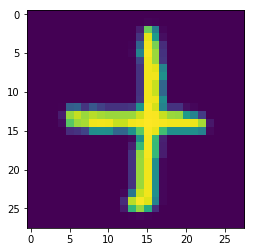

training set name:  train_t_55533.png
training set label:  t
IF measure:  -4.25966036281e-10


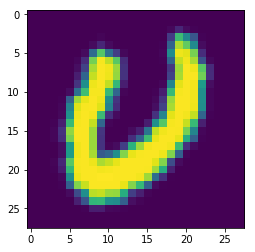

testfile name:  train_U_27159.png
ground truth label:  U
network prediction:  U
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 15930.528355566239, time: 14.815179586410522 

Recursion depth: 1, norm: 29217.56133945816, time: 14.877584218978882 

Recursion depth: 2, norm: 40309.71465106148, time: 14.63672137260437 

Recursion depth: 3, norm: 49569.5198937815, time: 14.643480062484741 

Recursion depth: 4, norm: 57299.618205534316, time: 14.809901237487793 

Recursion depth: 5, norm: 63753.059087388116, time: 14.785072803497314 

Recursion depth: 6, norm: 69140.40261670451, time: 15.02581262588501 

Recursion depth: 7, norm: 73637.76190922697, time: 14.994786500930786 

Recursion depth: 8, norm: 77392.45281679604, time: 15.106606721878052 

Recursion depth: 9, norm: 80526.72132900979, time: 14.861857652664185 

Recursion depth: 10, norm: 83143.23885921211, time: 14.952508449554443 

Recursion depth: 11, norm: 85327.77517315214, time: 15.044010400772

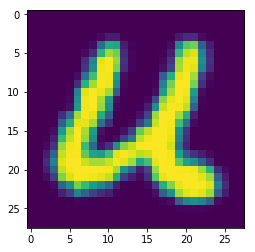

training set name:  train_U_58148.png
training set label:  0
IF measure:  0.00738257790605
train_U_58148.png


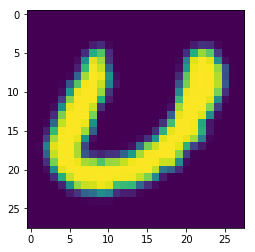

training set name:  train_U_59888.png
training set label:  Q
IF measure:  0.00712704969742
train_U_59888.png


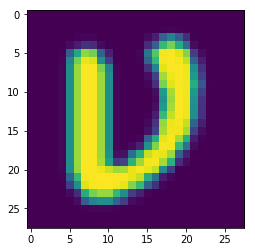

training set name:  train_V_29886.png
training set label:  V
IF measure:  0.00586837964489
train_V_29886.png


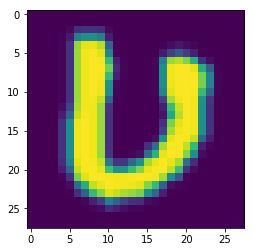

training set name:  train_V_45700.png
training set label:  V
IF measure:  0.00569289117946
train_V_45700.png


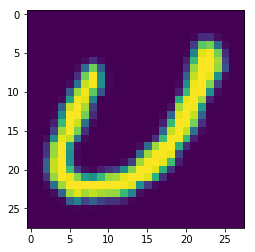

training set name:  train_U_100834.png
training set label:  A
IF measure:  0.00549161680941
train_U_100834.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



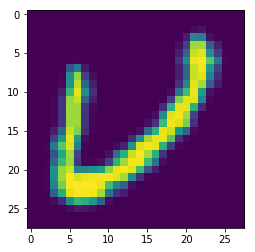

training set name:  train_U_4937.png
training set label:  U
IF measure:  -0.00756993454927
train_U_4937.png


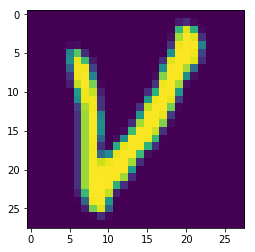

training set name:  train_V_56948.png
training set label:  U
IF measure:  -0.0075228984897
train_V_56948.png


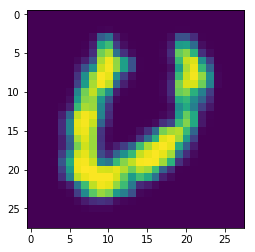

training set name:  train_U_69520.png
training set label:  U
IF measure:  -0.00750721569127
train_U_69520.png


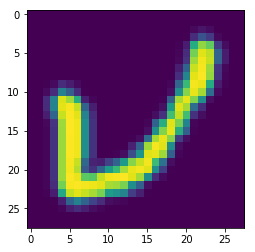

training set name:  train_U_112517.png
training set label:  U
IF measure:  -0.00747836109594
train_U_112517.png


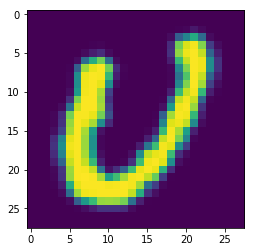

training set name:  train_U_7651.png
training set label:  U
IF measure:  -0.00743949629683
train_U_7651.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



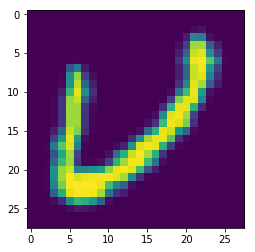

training set name:  train_U_4937.png
training set label:  U
IF measure:  -0.00756993454927


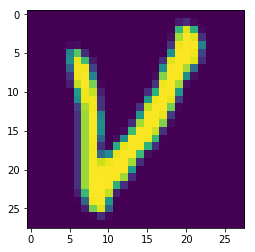

training set name:  train_V_56948.png
training set label:  U
IF measure:  -0.0075228984897


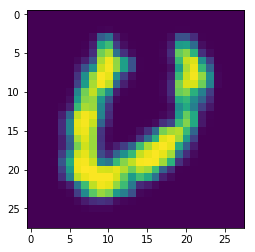

training set name:  train_U_69520.png
training set label:  U
IF measure:  -0.00750721569127


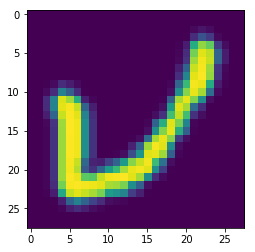

training set name:  train_U_112517.png
training set label:  U
IF measure:  -0.00747836109594


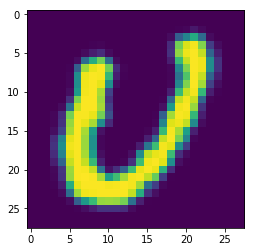

training set name:  train_U_7651.png
training set label:  U
IF measure:  -0.00743949629683

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



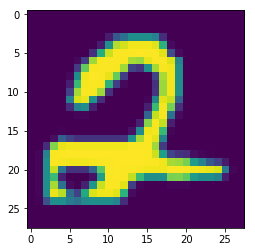

training set name:  train_2_34206.png
training set label:  2
IF measure:  1.80834638044e-11


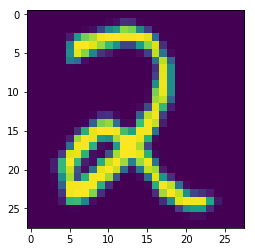

training set name:  train_2_21337.png
training set label:  2
IF measure:  -9.0271541857e-11


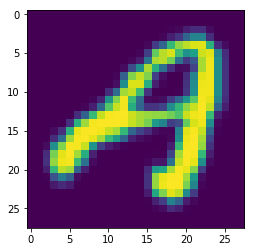

training set name:  train_A_24543.png
training set label:  A
IF measure:  1.67546984954e-10


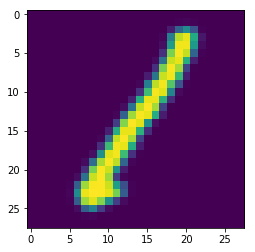

training set name:  train_1_6283.png
training set label:  1
IF measure:  -2.42017185173e-10


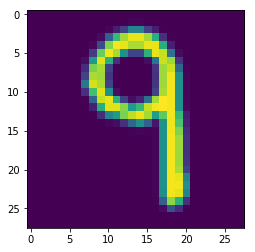

training set name:  train_9_101640.png
training set label:  9
IF measure:  -2.84453820939e-10


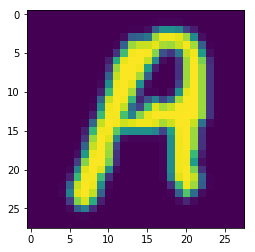

testfile name:  train_A_49768.png
ground truth label:  A
network prediction:  A
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 6280.072992957566, time: 14.911612749099731 

Recursion depth: 1, norm: 11511.67126428109, time: 14.84345269203186 

Recursion depth: 2, norm: 15878.902248738734, time: 14.856520891189575 

Recursion depth: 3, norm: 19524.72424741256, time: 14.720004320144653 

Recursion depth: 4, norm: 22568.434515933975, time: 14.890971660614014 

Recursion depth: 5, norm: 25109.2472607205, time: 14.80737018585205 

Recursion depth: 6, norm: 27230.39688932205, time: 14.683166742324829 

Recursion depth: 7, norm: 29001.186831317784, time: 14.776133060455322 

Recursion depth: 8, norm: 30479.66151181801, time: 14.810488939285278 

Recursion depth: 9, norm: 31713.969508719656, time: 14.654204368591309 

Recursion depth: 10, norm: 32744.102163595813, time: 14.642989158630371 

Recursion depth: 11, norm: 33604.042902231275, time: 14.786349534

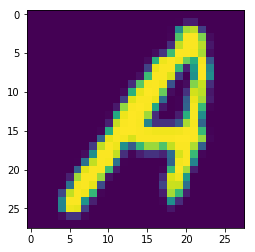

training set name:  train_A_14064.png
training set label:  G
IF measure:  0.00298731924292
train_A_14064.png


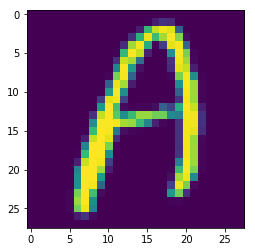

training set name:  train_A_90865.png
training set label:  g
IF measure:  0.00281308233632
train_A_90865.png


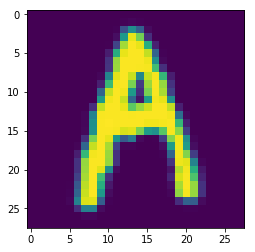

training set name:  train_A_94042.png
training set label:  R
IF measure:  0.00250542353152
train_A_94042.png


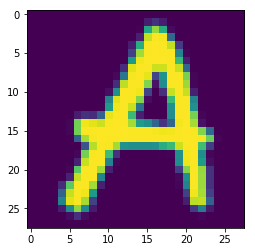

training set name:  train_A_45976.png
training set label:  h
IF measure:  0.00246037149155
train_A_45976.png


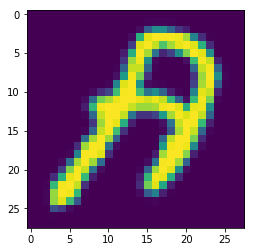

training set name:  train_A_78840.png
training set label:  L
IF measure:  0.00244956064362
train_A_78840.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



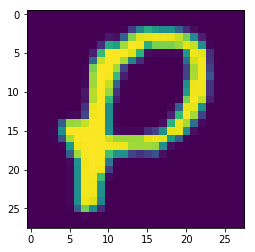

training set name:  train_P_12580.png
training set label:  A
IF measure:  -0.00215646179248
train_P_12580.png


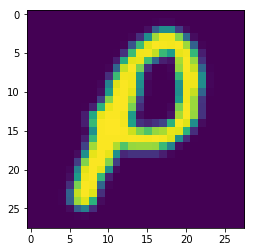

training set name:  train_P_92834.png
training set label:  A
IF measure:  -0.00214163716486
train_P_92834.png


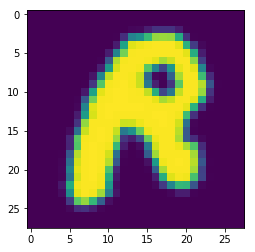

training set name:  train_R_10737.png
training set label:  A
IF measure:  -0.00211239764533
train_R_10737.png


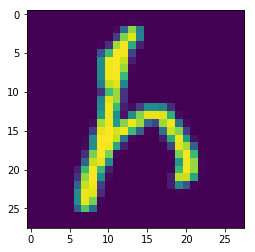

training set name:  train_h_60283.png
training set label:  A
IF measure:  -0.00202464183911
train_h_60283.png


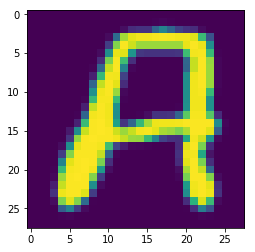

training set name:  train_A_36122.png
training set label:  A
IF measure:  -0.00201905455625
train_A_36122.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



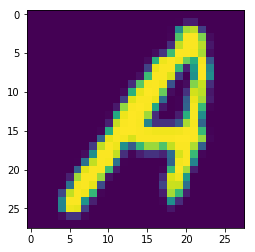

training set name:  train_A_14064.png
training set label:  G
IF measure:  0.00298731924292


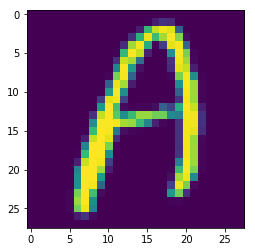

training set name:  train_A_90865.png
training set label:  g
IF measure:  0.00281308233632


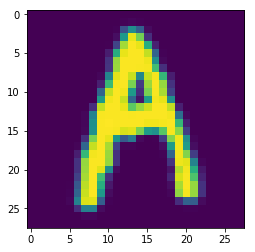

training set name:  train_A_94042.png
training set label:  R
IF measure:  0.00250542353152


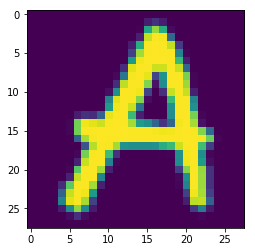

training set name:  train_A_45976.png
training set label:  h
IF measure:  0.00246037149155


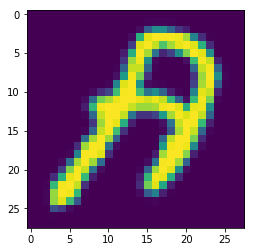

training set name:  train_A_78840.png
training set label:  L
IF measure:  0.00244956064362

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



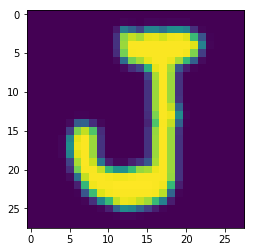

training set name:  train_J_29098.png
training set label:  3
IF measure:  1.39404251736e-11


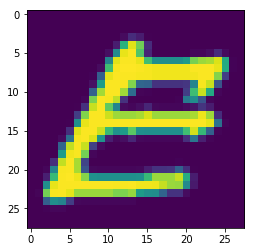

training set name:  train_E_86453.png
training set label:  E
IF measure:  -2.09646591655e-11


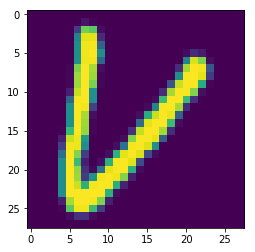

training set name:  train_V_22568.png
training set label:  V
IF measure:  2.58883474154e-11


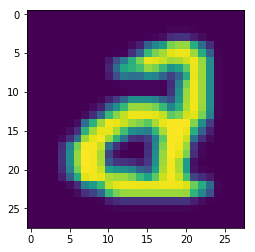

training set name:  train_a_67900.png
training set label:  a
IF measure:  8.03778037036e-11


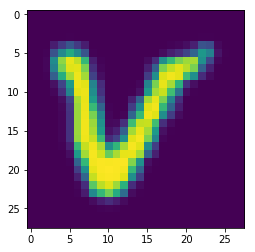

training set name:  train_V_13577.png
training set label:  V
IF measure:  1.15405202179e-10


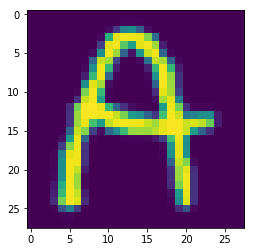

testfile name:  train_A_62497.png
ground truth label:  A
network prediction:  A
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 13123.297462194858, time: 14.765301942825317 

Recursion depth: 1, norm: 24067.86006794123, time: 14.668564319610596 

Recursion depth: 2, norm: 33204.62794174933, time: 14.696263551712036 

Recursion depth: 3, norm: 40832.36689808711, time: 15.023253202438354 

Recursion depth: 4, norm: 47200.03927434807, time: 14.879577159881592 

Recursion depth: 5, norm: 52516.01398145141, time: 14.68065857887268 

Recursion depth: 6, norm: 56953.74510073943, time: 14.636951208114624 

Recursion depth: 7, norm: 60658.5811241905, time: 14.807228803634644 

Recursion depth: 8, norm: 63751.49694713058, time: 14.606382846832275 

Recursion depth: 9, norm: 66333.57673154675, time: 14.667185544967651 

Recursion depth: 10, norm: 68489.32721234747, time: 14.756492137908936 

Recursion depth: 11, norm: 70288.7245794089, time: 14.79858231544494

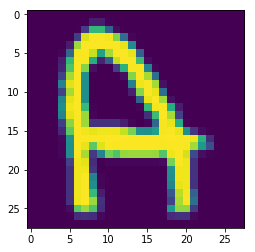

training set name:  train_A_61698.png
training set label:  t
IF measure:  0.00620390635433
train_A_61698.png


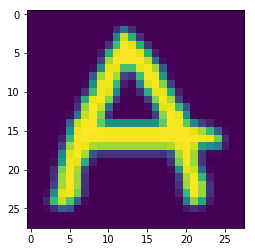

training set name:  train_A_40059.png
training set label:  U
IF measure:  0.00568348900118
train_A_40059.png


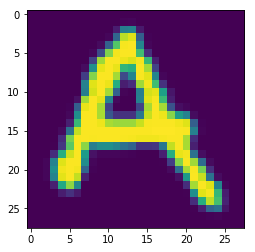

training set name:  train_A_67926.png
training set label:  P
IF measure:  0.0055177335885
train_A_67926.png


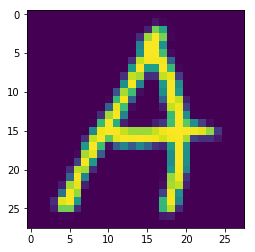

training set name:  train_A_48868.png
training set label:  E
IF measure:  0.00516178314673
train_A_48868.png


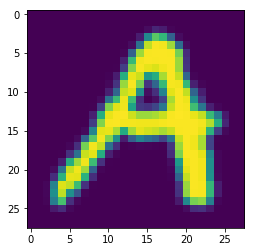

training set name:  train_A_8823.png
training set label:  R
IF measure:  0.00501167882789
train_A_8823.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



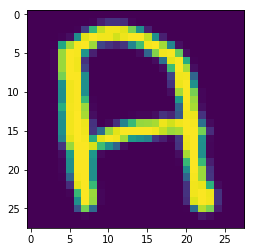

training set name:  train_A_100262.png
training set label:  A
IF measure:  -0.0049403924997
train_A_100262.png


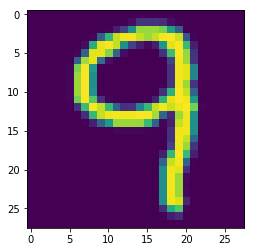

training set name:  train_q_51383.png
training set label:  A
IF measure:  -0.0045830808395
train_q_51383.png


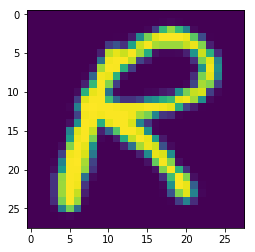

training set name:  train_R_11366.png
training set label:  A
IF measure:  -0.004575827015
train_R_11366.png


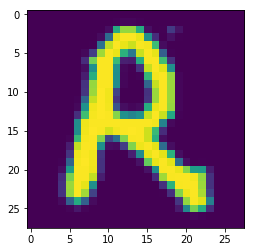

training set name:  train_R_97786.png
training set label:  A
IF measure:  -0.00443282527123
train_R_97786.png


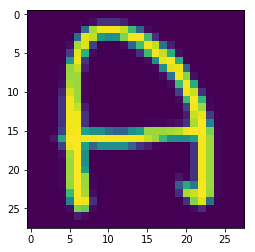

training set name:  train_A_23010.png
training set label:  A
IF measure:  -0.0040456129172
train_A_23010.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



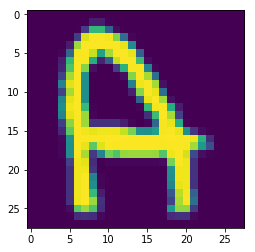

training set name:  train_A_61698.png
training set label:  t
IF measure:  0.00620390635433


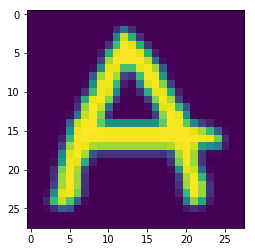

training set name:  train_A_40059.png
training set label:  U
IF measure:  0.00568348900118


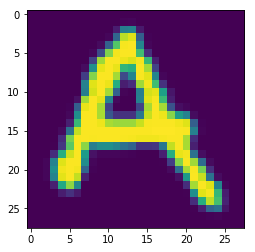

training set name:  train_A_67926.png
training set label:  P
IF measure:  0.0055177335885


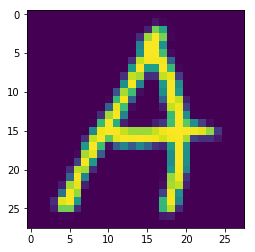

training set name:  train_A_48868.png
training set label:  E
IF measure:  0.00516178314673


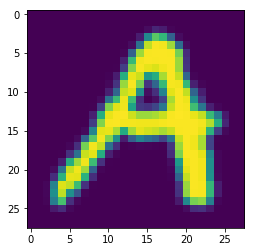

training set name:  train_A_8823.png
training set label:  R
IF measure:  0.00501167882789

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



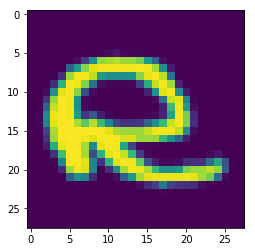

training set name:  train_R_88951.png
training set label:  F
IF measure:  -1.0795315091e-10


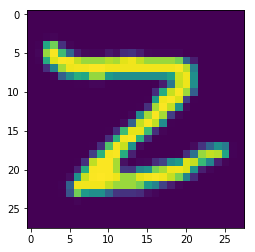

training set name:  train_Z_89980.png
training set label:  Z
IF measure:  1.87110796518e-10


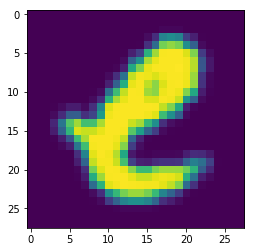

training set name:  train_e_43492.png
training set label:  e
IF measure:  -2.4629116524e-10


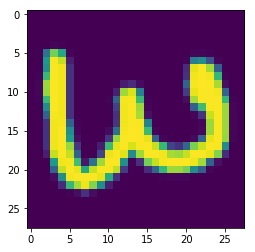

training set name:  train_W_44120.png
training set label:  W
IF measure:  5.0798310743e-10


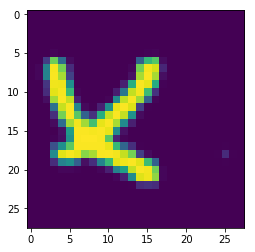

training set name:  train_X_93289.png
training set label:  X
IF measure:  5.54418939757e-10


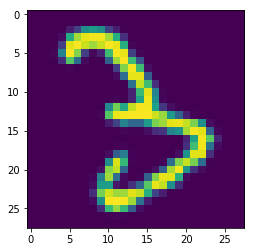

testfile name:  train_3_57272.png
ground truth label:  3
network prediction:  2
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 28900.820697689538, time: 14.867407321929932 

Recursion depth: 1, norm: 53010.92241227274, time: 14.666334390640259 

Recursion depth: 2, norm: 73138.44236104567, time: 14.885597705841064 

Recursion depth: 3, norm: 89941.40413624862, time: 14.887701749801636 

Recursion depth: 4, norm: 103968.82510637504, time: 14.666463851928711 

Recursion depth: 5, norm: 115679.15193326757, time: 14.894738674163818 

Recursion depth: 6, norm: 125455.35060729773, time: 14.842116117477417 

Recursion depth: 7, norm: 133616.7334430834, time: 14.772741079330444 

Recursion depth: 8, norm: 140429.93111156893, time: 14.727953910827637 

Recursion depth: 9, norm: 146117.97469168535, time: 14.793894529342651 

Recursion depth: 10, norm: 150866.74419500143, time: 14.734580516815186 

Recursion depth: 11, norm: 154830.87216701973, time: 14.7414

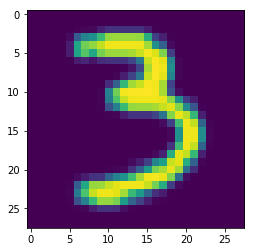

training set name:  train_3_29354.png
training set label:  4
IF measure:  0.0106770234592
train_3_29354.png


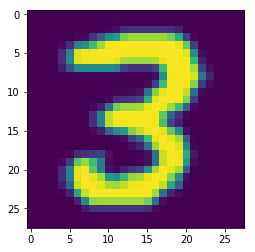

training set name:  train_3_14224.png
training set label:  t
IF measure:  0.00993254905474
train_3_14224.png


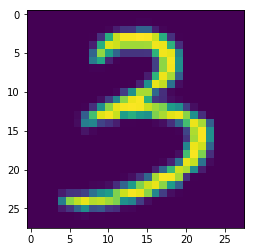

training set name:  train_3_74770.png
training set label:  T
IF measure:  0.00947960722954
train_3_74770.png


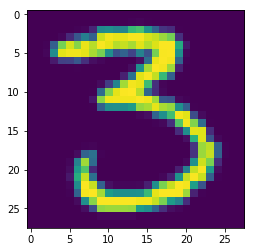

training set name:  train_3_112341.png
training set label:  d
IF measure:  0.00913698495703
train_3_112341.png


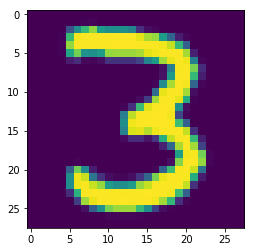

training set name:  train_3_84230.png
training set label:  A
IF measure:  0.00883838632639
train_3_84230.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



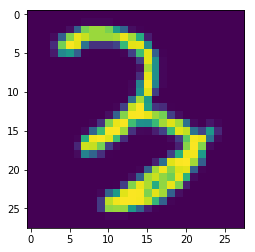

training set name:  train_3_21617.png
training set label:  3
IF measure:  -0.0135042277317
train_3_21617.png


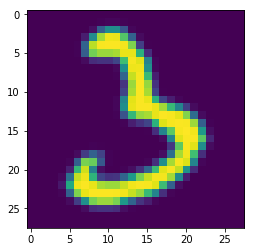

training set name:  train_3_76479.png
training set label:  3
IF measure:  -0.012043965238
train_3_76479.png


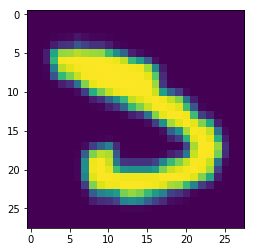

training set name:  train_J_90935.png
training set label:  3
IF measure:  -0.0114700068502
train_J_90935.png


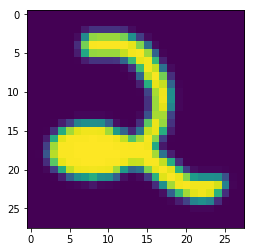

training set name:  train_2_76337.png
training set label:  3
IF measure:  -0.0111550641504
train_2_76337.png


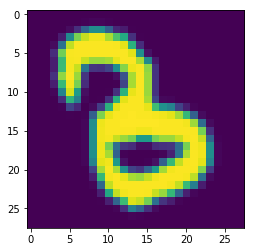

training set name:  train_3_54995.png
training set label:  3
IF measure:  -0.0111456735971
train_3_54995.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



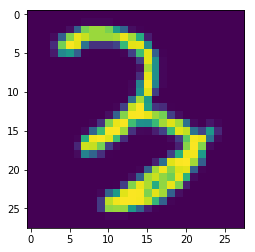

training set name:  train_3_21617.png
training set label:  3
IF measure:  -0.0135042277317


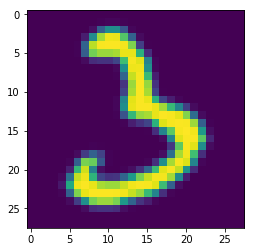

training set name:  train_3_76479.png
training set label:  3
IF measure:  -0.012043965238


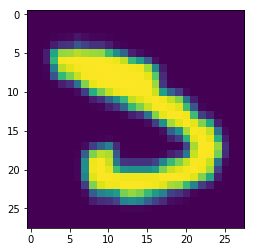

training set name:  train_J_90935.png
training set label:  3
IF measure:  -0.0114700068502


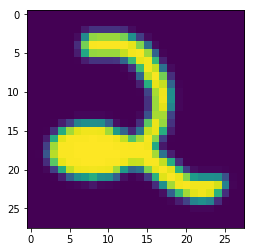

training set name:  train_2_76337.png
training set label:  3
IF measure:  -0.0111550641504


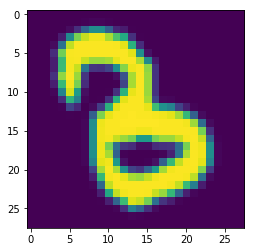

training set name:  train_3_54995.png
training set label:  3
IF measure:  -0.0111456735971

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



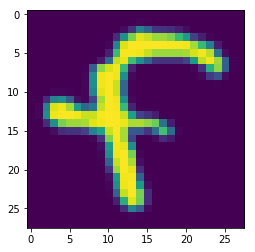

training set name:  train_F_65740.png
training set label:  T
IF measure:  2.34512886336e-10


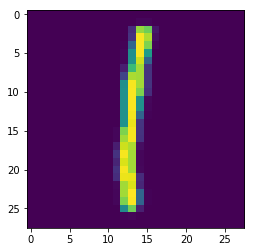

training set name:  train_L_65597.png
training set label:  L
IF measure:  -6.19909008602e-10


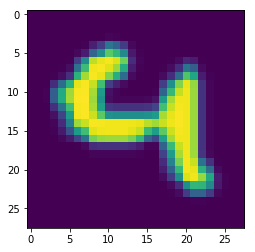

training set name:  train_4_80089.png
training set label:  4
IF measure:  7.1725461315e-10


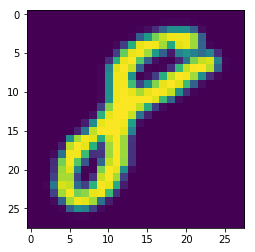

training set name:  train_8_40085.png
training set label:  8
IF measure:  -7.81866148814e-10


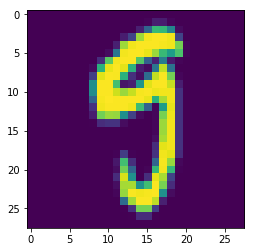

training set name:  train_g_106359.png
training set label:  g
IF measure:  8.22927576988e-10


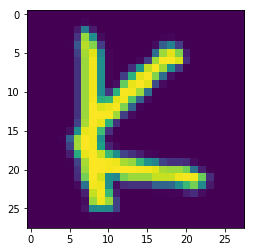

testfile name:  train_K_10613.png
ground truth label:  K
network prediction:  K
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 5115.20439703415, time: 14.649810552597046 

Recursion depth: 1, norm: 9374.5311303586, time: 14.917019605636597 

Recursion depth: 2, norm: 12930.347687224037, time: 14.883591890335083 

Recursion depth: 3, norm: 15898.69448649794, time: 14.649698495864868 

Recursion depth: 4, norm: 18376.84770472074, time: 14.749820470809937 

Recursion depth: 5, norm: 20445.361132632264, time: 14.717729806900024 

Recursion depth: 6, norm: 22172.156966846956, time: 14.72409725189209 

Recursion depth: 7, norm: 23613.99940448462, time: 15.037993907928467 

Recursion depth: 8, norm: 24817.353522157635, time: 15.02612042427063 

Recursion depth: 9, norm: 25821.881791418687, time: 14.717256307601929 

Recursion depth: 10, norm: 26660.73599884294, time: 14.76845908164978 

Recursion depth: 11, norm: 27361.12374451203, time: 14.7239284515380

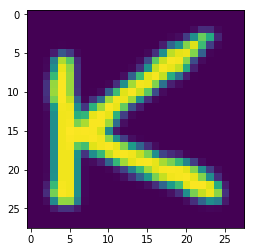

training set name:  train_K_39375.png
training set label:  b
IF measure:  0.00267671167467
train_K_39375.png


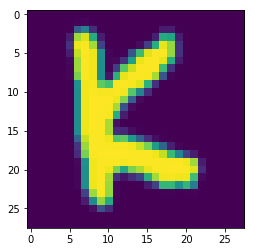

training set name:  train_K_103053.png
training set label:  N
IF measure:  0.00250356482831
train_K_103053.png


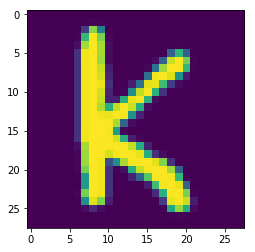

training set name:  train_K_35737.png
training set label:  L
IF measure:  0.00247732268594
train_K_35737.png


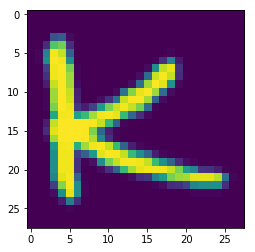

training set name:  train_K_29661.png
training set label:  9
IF measure:  0.00245288245393
train_K_29661.png


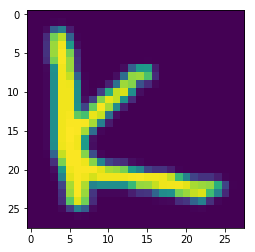

training set name:  train_K_42312.png
training set label:  W
IF measure:  0.00230432168204
train_K_42312.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



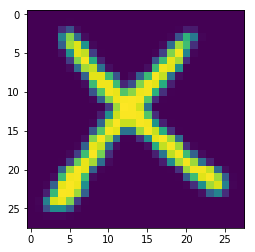

training set name:  train_X_6677.png
training set label:  K
IF measure:  -0.00197761154516
train_X_6677.png


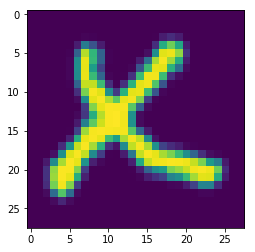

training set name:  train_K_2412.png
training set label:  K
IF measure:  -0.00196690049273
train_K_2412.png


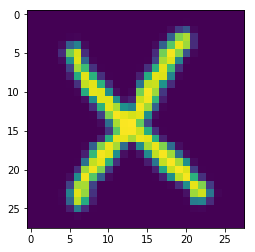

training set name:  train_X_73548.png
training set label:  K
IF measure:  -0.00184551006949
train_X_73548.png


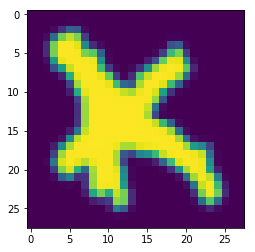

training set name:  train_K_77881.png
training set label:  K
IF measure:  -0.0017962745807
train_K_77881.png


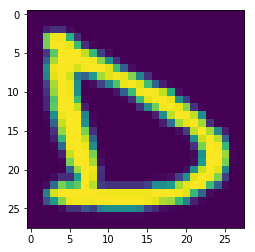

training set name:  train_D_60860.png
training set label:  K
IF measure:  -0.00178346069966
train_D_60860.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



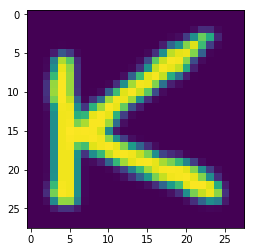

training set name:  train_K_39375.png
training set label:  b
IF measure:  0.00267671167467


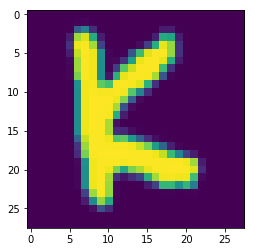

training set name:  train_K_103053.png
training set label:  N
IF measure:  0.00250356482831


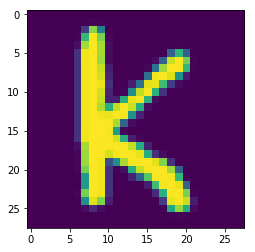

training set name:  train_K_35737.png
training set label:  L
IF measure:  0.00247732268594


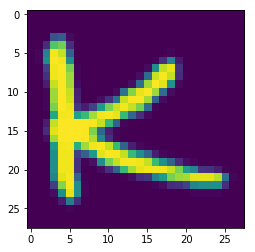

training set name:  train_K_29661.png
training set label:  9
IF measure:  0.00245288245393


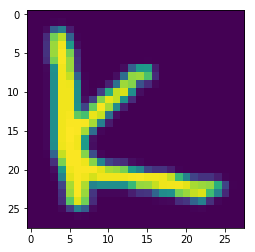

training set name:  train_K_42312.png
training set label:  W
IF measure:  0.00230432168204

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



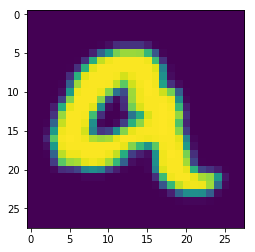

training set name:  train_a_42129.png
training set label:  a
IF measure:  6.71516705126e-11


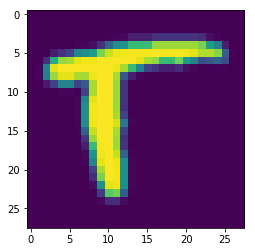

training set name:  train_T_7267.png
training set label:  T
IF measure:  -1.01619262099e-10


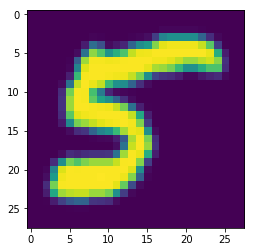

training set name:  train_5_96210.png
training set label:  5
IF measure:  -1.05785038097e-10


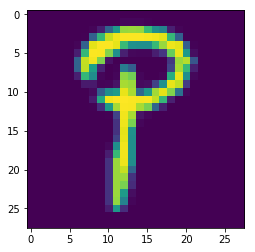

training set name:  train_P_9753.png
training set label:  P
IF measure:  -1.7282237674e-10


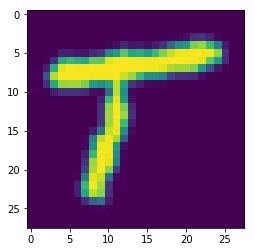

training set name:  train_T_49982.png
training set label:  T
IF measure:  -1.89915394364e-10


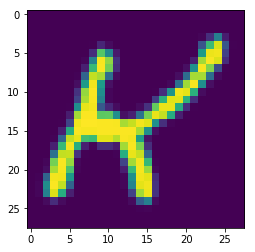

testfile name:  train_K_8218.png
ground truth label:  K
network prediction:  K
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 19755.832618178865, time: 14.541303157806396 

Recursion depth: 1, norm: 36235.12719033838, time: 14.649410963058472 

Recursion depth: 2, norm: 49992.213628724225, time: 14.681875467300415 

Recursion depth: 3, norm: 61476.857007332444, time: 14.772671461105347 

Recursion depth: 4, norm: 71064.64761046803, time: 14.653126239776611 

Recursion depth: 5, norm: 79068.91336043515, time: 14.670861721038818 

Recursion depth: 6, norm: 85750.98498559651, time: 14.978717803955078 

Recursion depth: 7, norm: 91329.36803131839, time: 14.622312545776367 

Recursion depth: 8, norm: 95986.5099792674, time: 14.711712837219238 

Recursion depth: 9, norm: 99874.28444799993, time: 14.85104513168335 

Recursion depth: 10, norm: 103120.04966057764, time: 14.793665170669556 

Recursion depth: 11, norm: 105829.76863812942, time: 14.8388702869

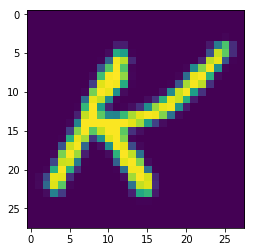

training set name:  train_K_14036.png
training set label:  a
IF measure:  0.0119082890609
train_K_14036.png


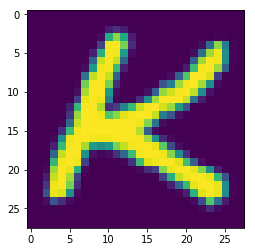

training set name:  train_K_57587.png
training set label:  U
IF measure:  0.0106160013388
train_K_57587.png


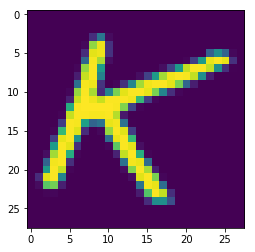

training set name:  train_K_387.png
training set label:  H
IF measure:  0.00988083212828
train_K_387.png


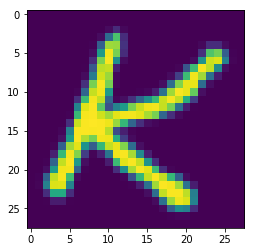

training set name:  train_K_62148.png
training set label:  n
IF measure:  0.00968311060722
train_K_62148.png


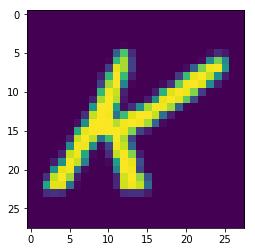

training set name:  train_K_76379.png
training set label:  O
IF measure:  0.0093106173613
train_K_76379.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



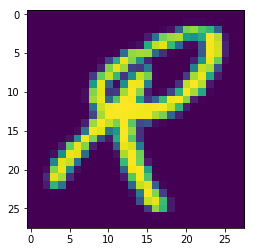

training set name:  train_R_27201.png
training set label:  K
IF measure:  -0.00813501627838
train_R_27201.png


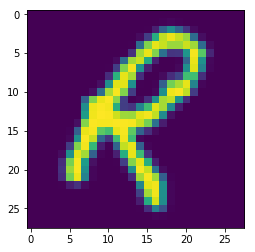

training set name:  train_R_6874.png
training set label:  K
IF measure:  -0.00784863008992
train_R_6874.png


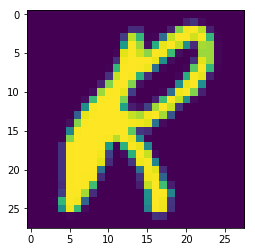

training set name:  train_R_104913.png
training set label:  K
IF measure:  -0.00760742209799
train_R_104913.png


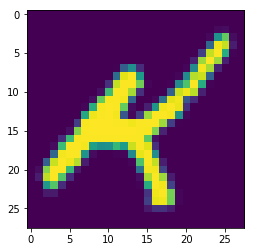

training set name:  train_K_81768.png
training set label:  K
IF measure:  -0.00708687459218
train_K_81768.png


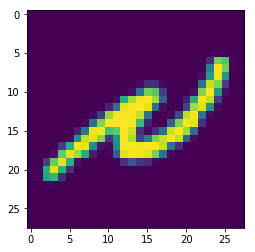

training set name:  train_N_76211.png
training set label:  K
IF measure:  -0.0068936640542
train_N_76211.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



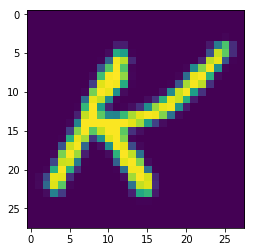

training set name:  train_K_14036.png
training set label:  a
IF measure:  0.0119082890609


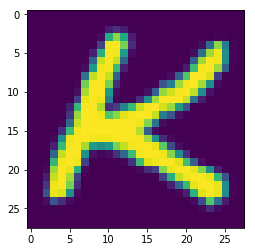

training set name:  train_K_57587.png
training set label:  U
IF measure:  0.0106160013388


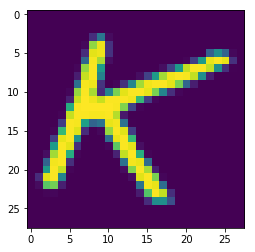

training set name:  train_K_387.png
training set label:  H
IF measure:  0.00988083212828


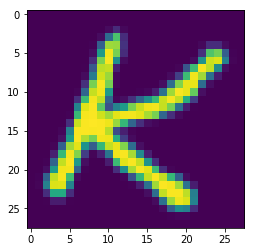

training set name:  train_K_62148.png
training set label:  n
IF measure:  0.00968311060722


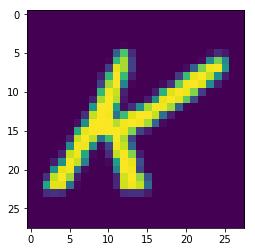

training set name:  train_K_76379.png
training set label:  O
IF measure:  0.0093106173613

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



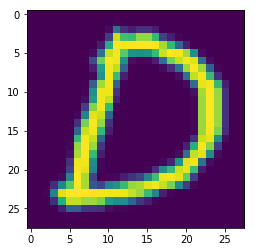

training set name:  train_D_70216.png
training set label:  D
IF measure:  4.93849979035e-10


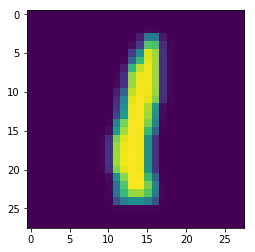

training set name:  train_I_20424.png
training set label:  I
IF measure:  -1.13672292257e-09


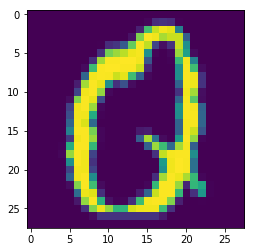

training set name:  train_Q_47445.png
training set label:  Q
IF measure:  1.27611782134e-09


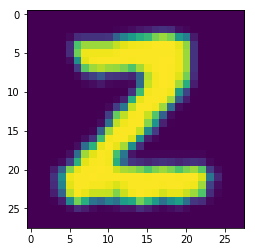

training set name:  train_Z_35651.png
training set label:  Z
IF measure:  2.48076871008e-09


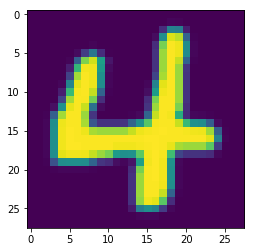

training set name:  train_4_2479.png
training set label:  4
IF measure:  2.48654593653e-09


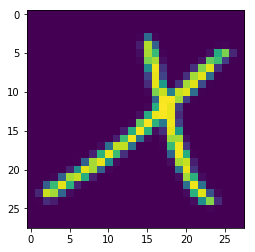

testfile name:  train_X_31386.png
ground truth label:  X
network prediction:  X
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 19635.13520611712, time: 14.841410398483276 

Recursion depth: 1, norm: 36014.303363386054, time: 14.667099237442017 

Recursion depth: 2, norm: 49687.67156951511, time: 14.826956510543823 

Recursion depth: 3, norm: 61102.41730079097, time: 14.877172946929932 

Recursion depth: 4, norm: 70631.84326491841, time: 14.908260822296143 

Recursion depth: 5, norm: 78587.02329901546, time: 14.775905847549438 

Recursion depth: 6, norm: 85228.3161044497, time: 14.619935750961304 

Recursion depth: 7, norm: 90772.76105748904, time: 14.835484504699707 

Recursion depth: 8, norm: 95401.26760164143, time: 14.911765098571777 

Recursion depth: 9, norm: 99265.16401034151, time: 14.798920631408691 

Recursion depth: 10, norm: 102490.85477251129, time: 14.86591649055481 

Recursion depth: 11, norm: 105183.63049448331, time: 14.77520179748

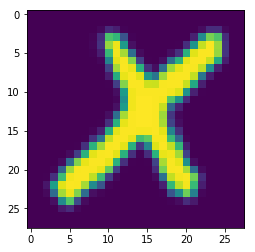

training set name:  train_X_7053.png
training set label:  9
IF measure:  0.00988266611247
train_X_7053.png


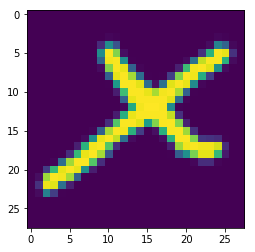

training set name:  train_X_56963.png
training set label:  9
IF measure:  0.00898620956016
train_X_56963.png


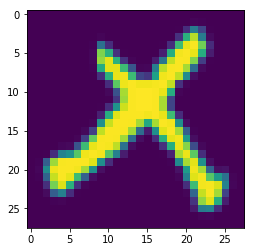

training set name:  train_X_60625.png
training set label:  g
IF measure:  0.00888314712661
train_X_60625.png


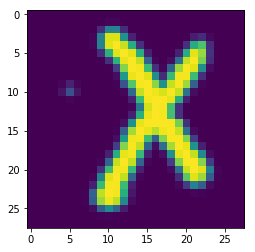

training set name:  train_X_77523.png
training set label:  Y
IF measure:  0.00887392178072
train_X_77523.png


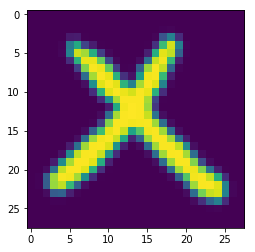

training set name:  train_X_19421.png
training set label:  4
IF measure:  0.00879239193197
train_X_19421.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



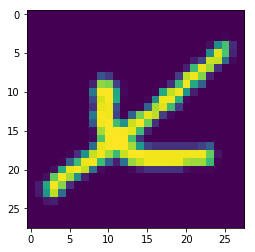

training set name:  train_X_98661.png
training set label:  X
IF measure:  -0.00596332145815
train_X_98661.png


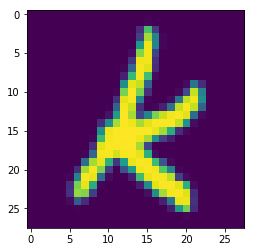

training set name:  train_K_31371.png
training set label:  X
IF measure:  -0.00579628859851
train_K_31371.png


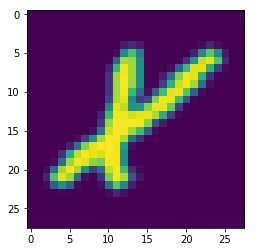

training set name:  train_X_83505.png
training set label:  X
IF measure:  -0.00579583773799
train_X_83505.png


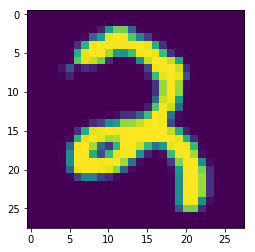

training set name:  train_2_108127.png
training set label:  X
IF measure:  -0.00576359957245
train_2_108127.png


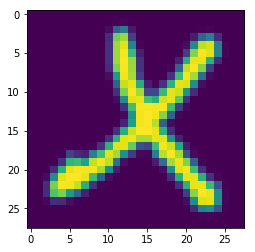

training set name:  train_X_21502.png
training set label:  X
IF measure:  -0.00550458558062
train_X_21502.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



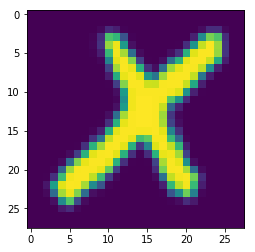

training set name:  train_X_7053.png
training set label:  9
IF measure:  0.00988266611247


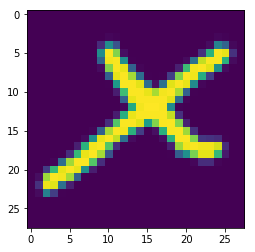

training set name:  train_X_56963.png
training set label:  9
IF measure:  0.00898620956016


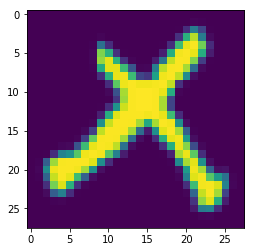

training set name:  train_X_60625.png
training set label:  g
IF measure:  0.00888314712661


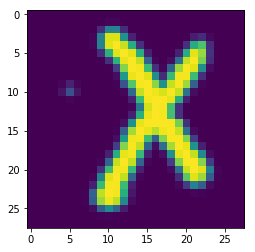

training set name:  train_X_77523.png
training set label:  Y
IF measure:  0.00887392178072


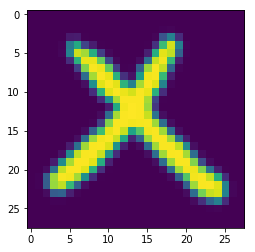

training set name:  train_X_19421.png
training set label:  4
IF measure:  0.00879239193197

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



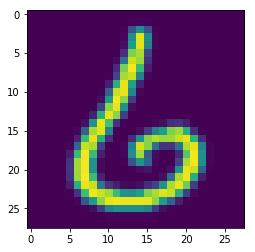

training set name:  train_6_19340.png
training set label:  r
IF measure:  1.11378914287e-10


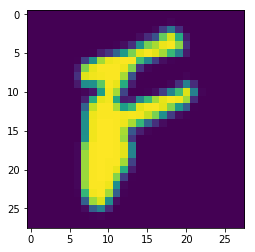

training set name:  train_F_10101.png
training set label:  F
IF measure:  -1.80567594919e-10


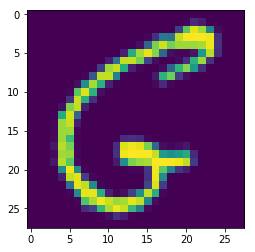

training set name:  train_G_21638.png
training set label:  G
IF measure:  4.99217771613e-10


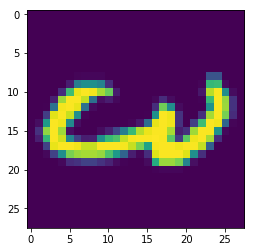

training set name:  train_W_50068.png
training set label:  W
IF measure:  -8.14947244754e-10


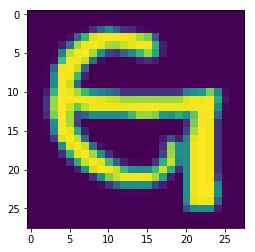

training set name:  train_G_106783.png
training set label:  G
IF measure:  8.68832548223e-10


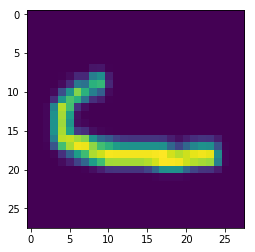

testfile name:  train_C_17405.png
ground truth label:  C
network prediction:  C
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 26484.80850884144, time: 14.733389616012573 

Recursion depth: 1, norm: 48579.01103871918, time: 14.920185327529907 

Recursion depth: 2, norm: 67023.67111700164, time: 14.923035144805908 

Recursion depth: 3, norm: 82421.70580617705, time: 14.687349319458008 

Recursion depth: 4, norm: 95276.19537953853, time: 14.789739847183228 

Recursion depth: 5, norm: 106007.60524603883, time: 14.811180114746094 

Recursion depth: 6, norm: 114966.07755333744, time: 14.752292394638062 

Recursion depth: 7, norm: 122445.08739839258, time: 14.697430849075317 

Recursion depth: 8, norm: 128688.45892309069, time: 14.876681804656982 

Recursion depth: 9, norm: 133900.8300646415, time: 14.939255237579346 

Recursion depth: 10, norm: 138252.12116998422, time: 14.741058826446533 

Recursion depth: 11, norm: 141884.68616450473, time: 14.820769

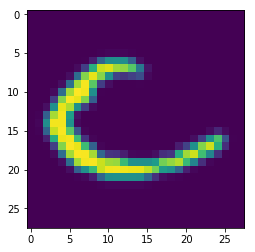

training set name:  train_C_78777.png
training set label:  H
IF measure:  0.00990072909399
train_C_78777.png


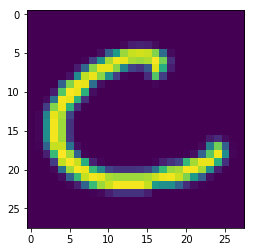

training set name:  train_C_21417.png
training set label:  K
IF measure:  0.00983267594525
train_C_21417.png


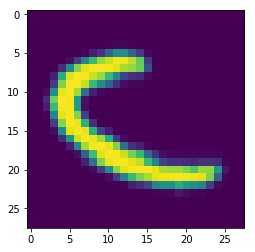

training set name:  train_C_21035.png
training set label:  L
IF measure:  0.00977555383393
train_C_21035.png


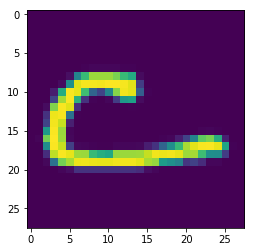

training set name:  train_C_27955.png
training set label:  e
IF measure:  0.00971124805246
train_C_27955.png


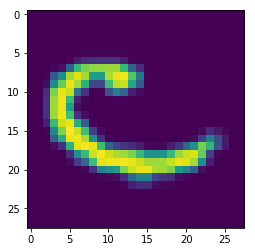

training set name:  train_C_30845.png
training set label:  f
IF measure:  0.00964279523555
train_C_30845.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



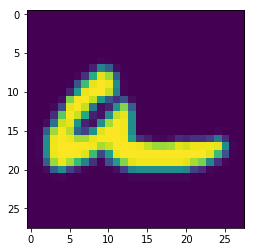

training set name:  train_a_41572.png
training set label:  C
IF measure:  -0.013730464231
train_a_41572.png


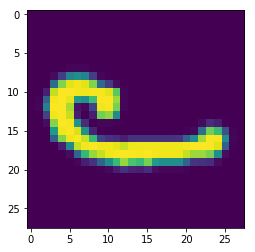

training set name:  train_C_112192.png
training set label:  C
IF measure:  -0.0132034126643
train_C_112192.png


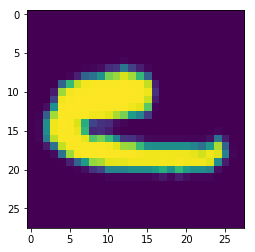

training set name:  train_C_51936.png
training set label:  C
IF measure:  -0.0124880083275
train_C_51936.png


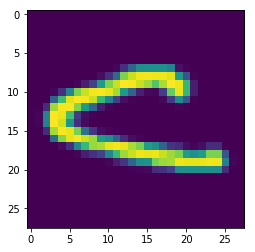

training set name:  train_C_72595.png
training set label:  C
IF measure:  -0.0123626773345
train_C_72595.png


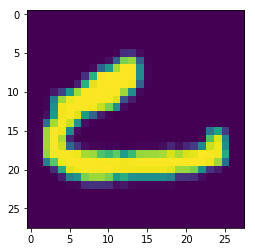

training set name:  train_C_106368.png
training set label:  C
IF measure:  -0.0121738102208
train_C_106368.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



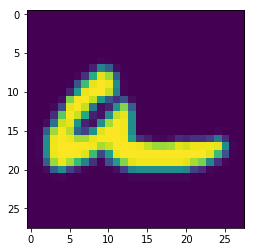

training set name:  train_a_41572.png
training set label:  C
IF measure:  -0.013730464231


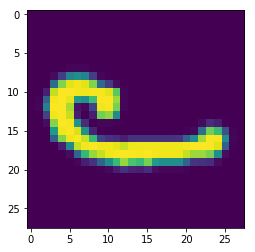

training set name:  train_C_112192.png
training set label:  C
IF measure:  -0.0132034126643


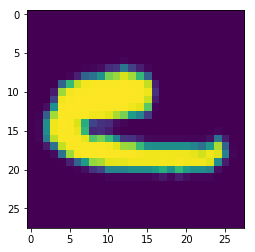

training set name:  train_C_51936.png
training set label:  C
IF measure:  -0.0124880083275


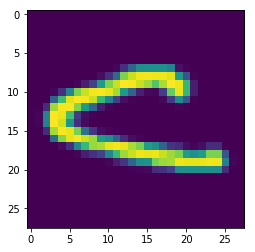

training set name:  train_C_72595.png
training set label:  C
IF measure:  -0.0123626773345


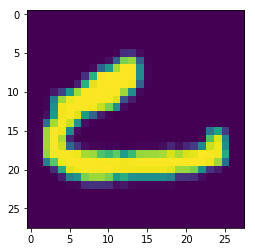

training set name:  train_C_106368.png
training set label:  C
IF measure:  -0.0121738102208

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



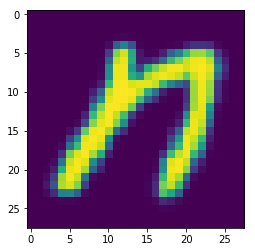

training set name:  train_n_6053.png
training set label:  n
IF measure:  -1.3649386869e-10


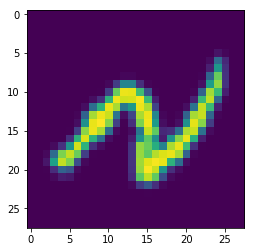

training set name:  train_N_48157.png
training set label:  N
IF measure:  2.16597775806e-10


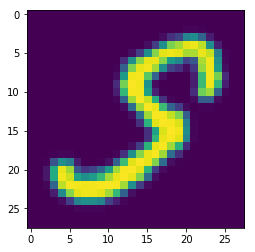

training set name:  train_S_80121.png
training set label:  S
IF measure:  2.53325477852e-10


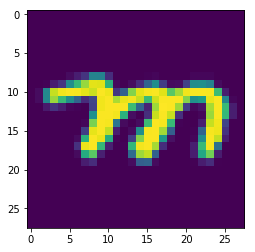

training set name:  train_M_106524.png
training set label:  M
IF measure:  -2.53747731731e-10


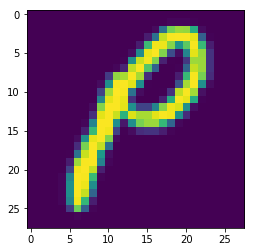

training set name:  train_P_47559.png
training set label:  D
IF measure:  2.6953036745e-10


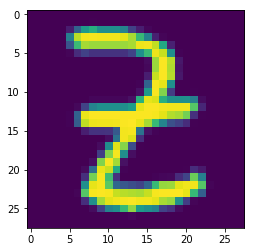

testfile name:  train_B_86016.png
ground truth label:  B
network prediction:  Z
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 38320.820688628264, time: 14.995229005813599 

Recursion depth: 1, norm: 70290.45867683608, time: 14.735506772994995 

Recursion depth: 2, norm: 96979.06446238796, time: 14.791231155395508 

Recursion depth: 3, norm: 119259.04556887917, time: 15.092586040496826 

Recursion depth: 4, norm: 137858.98926076601, time: 14.876334190368652 

Recursion depth: 5, norm: 153386.7364018154, time: 14.897323369979858 

Recursion depth: 6, norm: 166349.88434020625, time: 14.862934112548828 

Recursion depth: 7, norm: 177172.0055652134, time: 14.858983993530273 

Recursion depth: 8, norm: 186206.55260221107, time: 14.81093955039978 

Recursion depth: 9, norm: 193748.63876683108, time: 14.769384622573853 

Recursion depth: 10, norm: 200045.04832662066, time: 14.86053991317749 

Recursion depth: 11, norm: 205301.54588799374, time: 15.098921

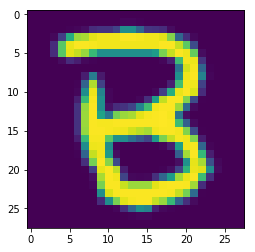

training set name:  train_B_39672.png
training set label:  F
IF measure:  0.0111415897437
train_B_39672.png


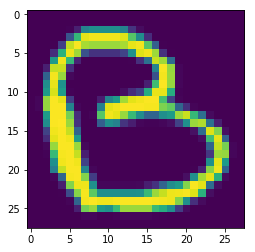

training set name:  train_B_27719.png
training set label:  a
IF measure:  0.0109393046627
train_B_27719.png


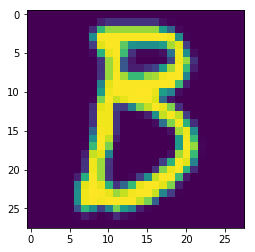

training set name:  train_B_75479.png
training set label:  Z
IF measure:  0.0107717471977
train_B_75479.png


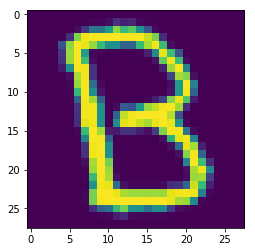

training set name:  train_B_18011.png
training set label:  7
IF measure:  0.0104375230611
train_B_18011.png


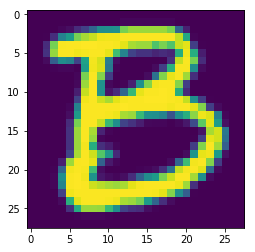

training set name:  train_B_22151.png
training set label:  N
IF measure:  0.0100654388573
train_B_22151.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



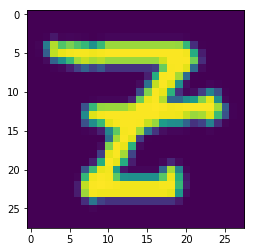

training set name:  train_B_30387.png
training set label:  B
IF measure:  -0.0199136856811
train_B_30387.png


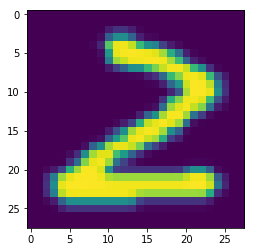

training set name:  train_Z_79407.png
training set label:  B
IF measure:  -0.0145684958455
train_Z_79407.png


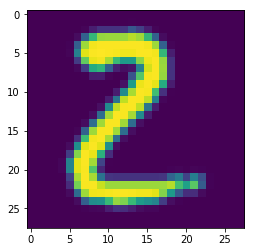

training set name:  train_2_29687.png
training set label:  B
IF measure:  -0.0138744601544
train_2_29687.png


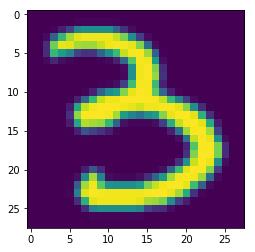

training set name:  train_3_73666.png
training set label:  B
IF measure:  -0.0137872576925
train_3_73666.png


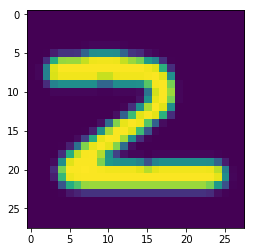

training set name:  train_2_102371.png
training set label:  B
IF measure:  -0.0133550575122
train_2_102371.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



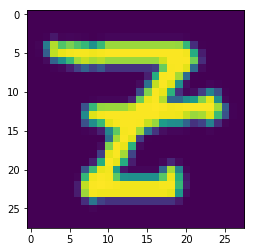

training set name:  train_B_30387.png
training set label:  B
IF measure:  -0.0199136856811


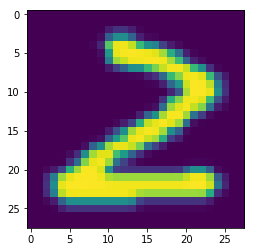

training set name:  train_Z_79407.png
training set label:  B
IF measure:  -0.0145684958455


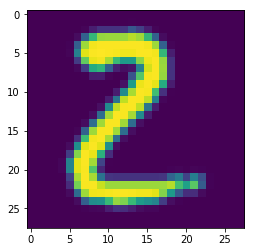

training set name:  train_2_29687.png
training set label:  B
IF measure:  -0.0138744601544


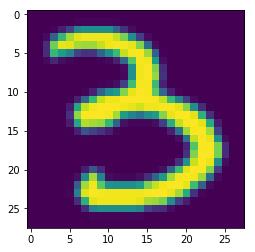

training set name:  train_3_73666.png
training set label:  B
IF measure:  -0.0137872576925


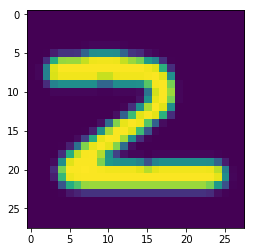

training set name:  train_2_102371.png
training set label:  B
IF measure:  -0.0133550575122

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



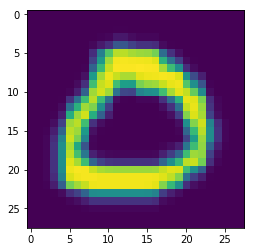

training set name:  train_O_95307.png
training set label:  1
IF measure:  -2.33759489307e-11


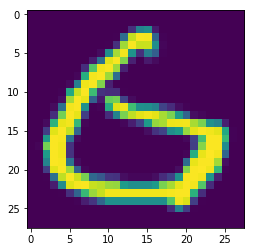

training set name:  train_G_54269.png
training set label:  G
IF measure:  1.37185342676e-10


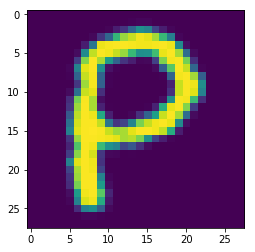

training set name:  train_P_84041.png
training set label:  P
IF measure:  -1.63920616718e-10


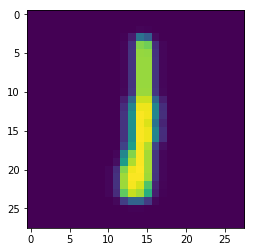

training set name:  train_I_10253.png
training set label:  I
IF measure:  -2.99377274429e-10


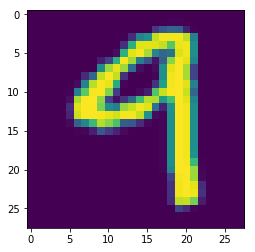

training set name:  train_9_105581.png
training set label:  9
IF measure:  5.05085625019e-10


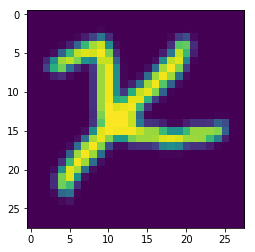

testfile name:  train_X_70841.png
ground truth label:  X
network prediction:  X
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 19635.68258776608, time: 14.641946792602539 

Recursion depth: 1, norm: 36014.877877066305, time: 14.786604881286621 

Recursion depth: 2, norm: 49688.32751260602, time: 14.827661037445068 

Recursion depth: 3, norm: 61103.19429866167, time: 14.751556396484375 

Recursion depth: 4, norm: 70632.8022628297, time: 14.676973104476929 

Recursion depth: 5, norm: 78588.10591304513, time: 14.843025207519531 

Recursion depth: 6, norm: 85229.29297489215, time: 14.771904468536377 

Recursion depth: 7, norm: 90773.59621057216, time: 14.927535772323608 

Recursion depth: 8, norm: 95402.148026132, time: 15.051843404769897 

Recursion depth: 9, norm: 99265.92364452164, time: 15.031316757202148 

Recursion depth: 10, norm: 102491.68011111926, time: 14.967926263809204 

Recursion depth: 11, norm: 105184.5453571959, time: 14.9063553810119

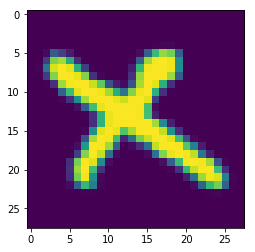

training set name:  train_X_71353.png
training set label:  Y
IF measure:  0.0100131081404
train_X_71353.png


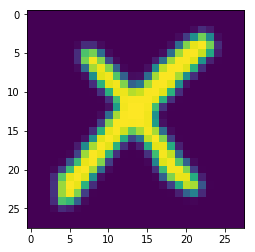

training set name:  train_X_96374.png
training set label:  C
IF measure:  0.00859685462523
train_X_96374.png


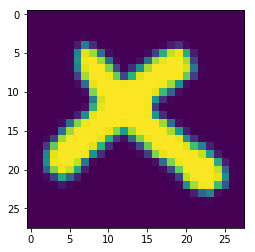

training set name:  train_X_47020.png
training set label:  r
IF measure:  0.0085175540219
train_X_47020.png


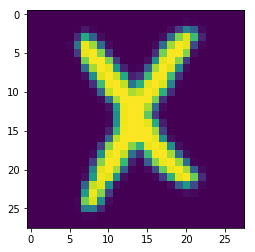

training set name:  train_X_97658.png
training set label:  Y
IF measure:  0.00841960838818
train_X_97658.png


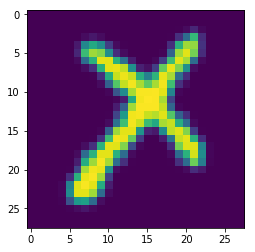

training set name:  train_X_61309.png
training set label:  Q
IF measure:  0.00835784726532
train_X_61309.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



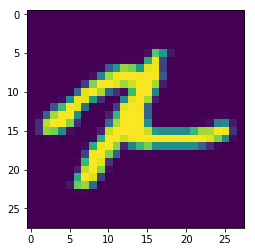

training set name:  train_X_71690.png
training set label:  X
IF measure:  -0.00657167834699
train_X_71690.png


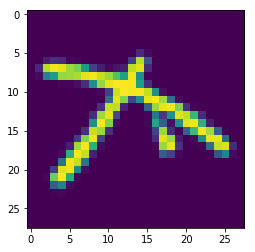

training set name:  train_X_53987.png
training set label:  X
IF measure:  -0.00652112046138
train_X_53987.png


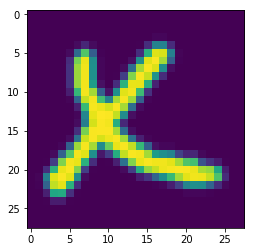

training set name:  train_X_50403.png
training set label:  X
IF measure:  -0.00647706585996
train_X_50403.png


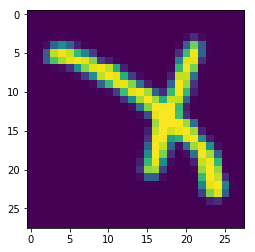

training set name:  train_X_6996.png
training set label:  X
IF measure:  -0.00612394429268
train_X_6996.png


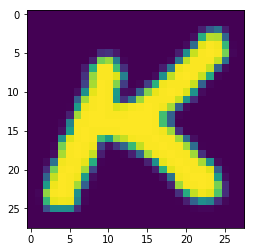

training set name:  train_K_62675.png
training set label:  X
IF measure:  -0.00595506434428
train_K_62675.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



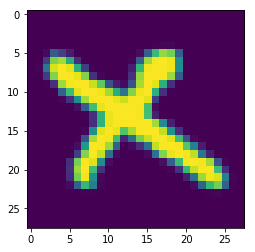

training set name:  train_X_71353.png
training set label:  Y
IF measure:  0.0100131081404


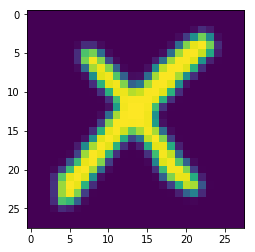

training set name:  train_X_96374.png
training set label:  C
IF measure:  0.00859685462523


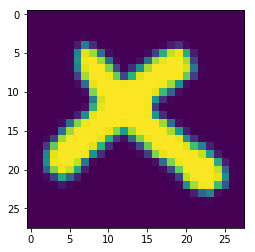

training set name:  train_X_47020.png
training set label:  r
IF measure:  0.0085175540219


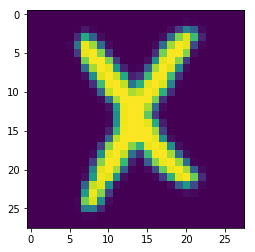

training set name:  train_X_97658.png
training set label:  Y
IF measure:  0.00841960838818


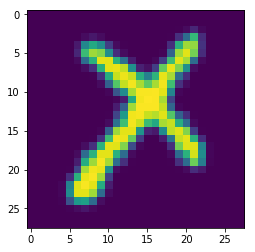

training set name:  train_X_61309.png
training set label:  Q
IF measure:  0.00835784726532

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



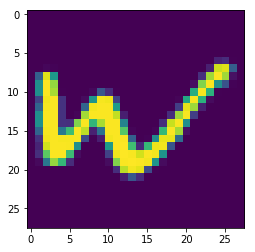

training set name:  train_W_72441.png
training set label:  W
IF measure:  -3.97239105912e-10


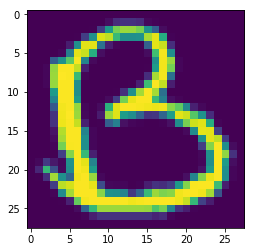

training set name:  train_B_74132.png
training set label:  B
IF measure:  -4.50875507772e-10


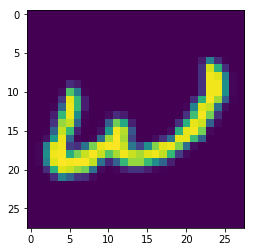

training set name:  train_W_28264.png
training set label:  W
IF measure:  4.8796035581e-10


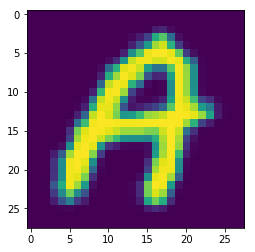

training set name:  train_A_63119.png
training set label:  8
IF measure:  5.89939545599e-10


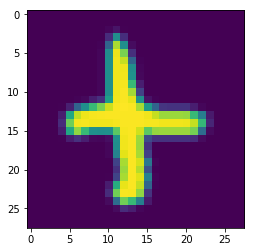

training set name:  train_t_59837.png
training set label:  t
IF measure:  8.50162105569e-10


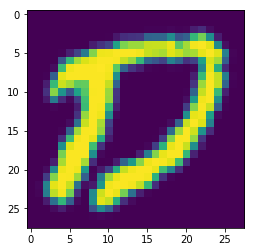

testfile name:  train_D_77654.png
ground truth label:  D
network prediction:  D
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 15492.767528350123, time: 14.839013576507568 

Recursion depth: 1, norm: 28415.276503141755, time: 14.768355369567871 

Recursion depth: 2, norm: 39202.98363645298, time: 14.971137762069702 

Recursion depth: 3, norm: 48208.74996305131, time: 14.796927452087402 

Recursion depth: 4, norm: 55727.00423493084, time: 14.69167685508728 

Recursion depth: 5, norm: 62003.237911418786, time: 14.716414213180542 

Recursion depth: 6, norm: 67242.71638995557, time: 14.86247992515564 

Recursion depth: 7, norm: 71617.00974628862, time: 14.892995357513428 

Recursion depth: 8, norm: 75268.75540355373, time: 14.852112531661987 

Recursion depth: 9, norm: 78317.45844318494, time: 14.827742576599121 

Recursion depth: 10, norm: 80862.37090266398, time: 14.860877513885498 

Recursion depth: 11, norm: 82986.9068528283, time: 14.953733921051

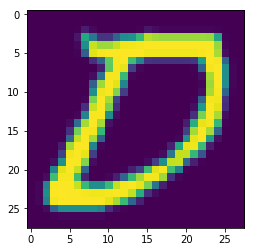

training set name:  train_D_54181.png
training set label:  8
IF measure:  0.00961800055935
train_D_54181.png


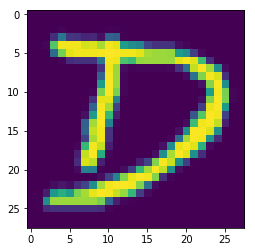

training set name:  train_D_54971.png
training set label:  6
IF measure:  0.00852377284186
train_D_54971.png


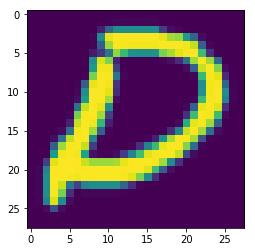

training set name:  train_D_40274.png
training set label:  2
IF measure:  0.00845359874797
train_D_40274.png


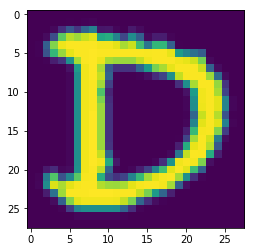

training set name:  train_D_19001.png
training set label:  Y
IF measure:  0.00813819003549
train_D_19001.png


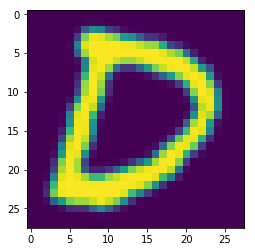

training set name:  train_D_103366.png
training set label:  0
IF measure:  0.00791682159224
train_D_103366.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



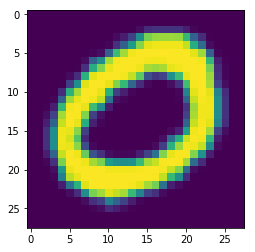

training set name:  train_0_49412.png
training set label:  D
IF measure:  -0.00575354049603
train_0_49412.png


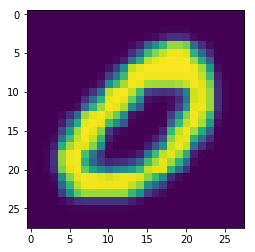

training set name:  train_O_78256.png
training set label:  D
IF measure:  -0.00565446444807
train_O_78256.png


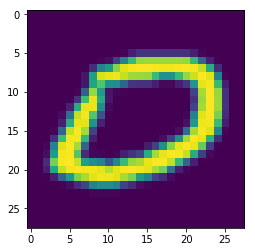

training set name:  train_D_43210.png
training set label:  D
IF measure:  -0.00552997244324
train_D_43210.png


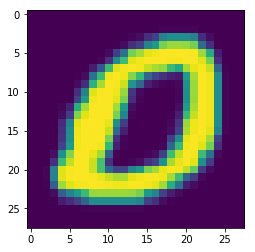

training set name:  train_D_97641.png
training set label:  D
IF measure:  -0.00551716718057
train_D_97641.png


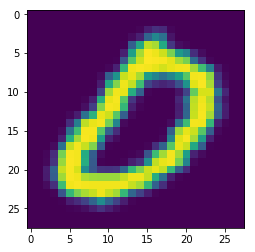

training set name:  train_D_47671.png
training set label:  D
IF measure:  -0.00532206372748
train_D_47671.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



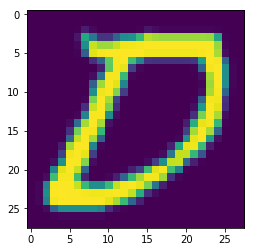

training set name:  train_D_54181.png
training set label:  8
IF measure:  0.00961800055935


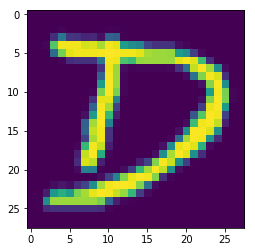

training set name:  train_D_54971.png
training set label:  6
IF measure:  0.00852377284186


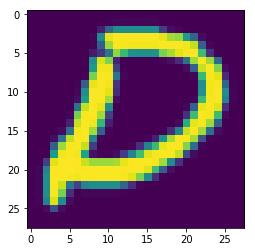

training set name:  train_D_40274.png
training set label:  2
IF measure:  0.00845359874797


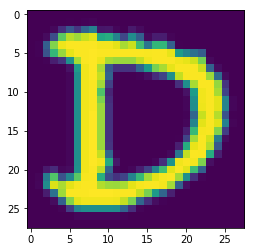

training set name:  train_D_19001.png
training set label:  Y
IF measure:  0.00813819003549


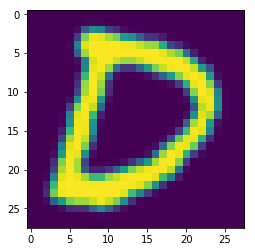

training set name:  train_D_103366.png
training set label:  0
IF measure:  0.00791682159224

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



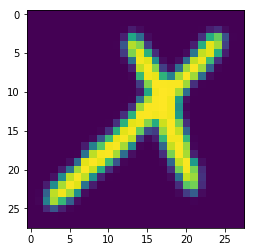

training set name:  train_X_66468.png
training set label:  X
IF measure:  -1.1105833353e-11


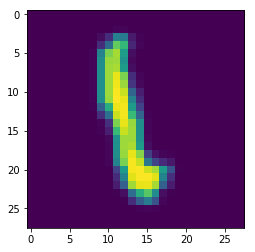

training set name:  train_I_22165.png
training set label:  I
IF measure:  -1.99108386201e-10


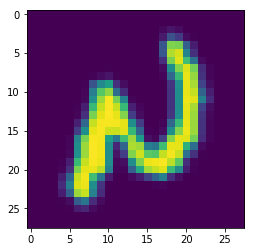

training set name:  train_N_96329.png
training set label:  N
IF measure:  2.59064728062e-10


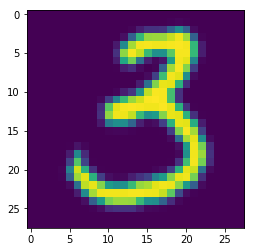

training set name:  train_3_75062.png
training set label:  3
IF measure:  2.63015547245e-10


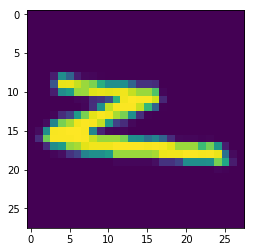

training set name:  train_Z_67501.png
training set label:  Z
IF measure:  -4.57766099258e-10


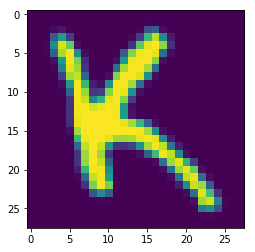

testfile name:  train_K_14327.png
ground truth label:  K
network prediction:  K
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 19359.0928716327, time: 14.664237260818481 

Recursion depth: 1, norm: 35507.50336548601, time: 14.75493597984314 

Recursion depth: 2, norm: 48988.51453146952, time: 15.241215944290161 

Recursion depth: 3, norm: 60242.959256663344, time: 14.669504404067993 

Recursion depth: 4, norm: 69638.22145919582, time: 14.777072429656982 

Recursion depth: 5, norm: 77481.52342332977, time: 14.822683095932007 

Recursion depth: 6, norm: 84029.30325190135, time: 14.976582288742065 

Recursion depth: 7, norm: 89495.73774767153, time: 15.067337036132812 

Recursion depth: 8, norm: 94059.24761553221, time: 14.804565906524658 

Recursion depth: 9, norm: 97868.88686911689, time: 14.748584508895874 

Recursion depth: 10, norm: 101049.23612774121, time: 14.883437871932983 

Recursion depth: 11, norm: 103704.31014186441, time: 14.90388011932

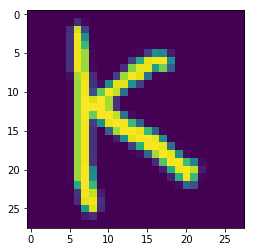

training set name:  train_K_82276.png
training set label:  W
IF measure:  0.0103890241989
train_K_82276.png


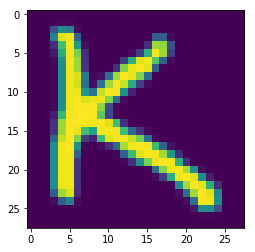

training set name:  train_K_96969.png
training set label:  r
IF measure:  0.00970948308389
train_K_96969.png


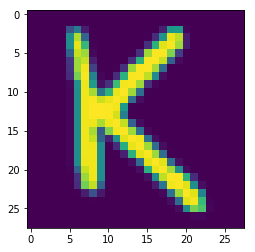

training set name:  train_K_57769.png
training set label:  S
IF measure:  0.00892719357466
train_K_57769.png


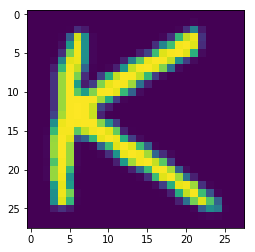

training set name:  train_K_10284.png
training set label:  6
IF measure:  0.00838809650629
train_K_10284.png


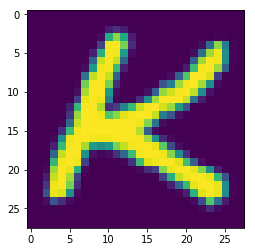

training set name:  train_K_57587.png
training set label:  U
IF measure:  0.0082127949289
train_K_57587.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



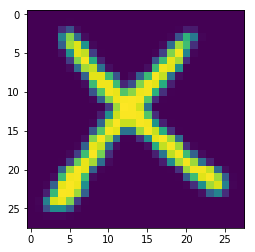

training set name:  train_X_6677.png
training set label:  K
IF measure:  -0.00993086956706
train_X_6677.png


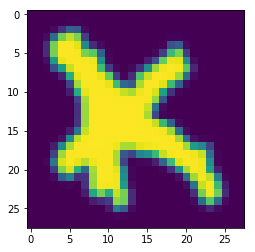

training set name:  train_K_77881.png
training set label:  K
IF measure:  -0.00820467432974
train_K_77881.png


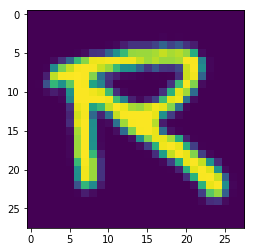

training set name:  train_R_67414.png
training set label:  K
IF measure:  -0.0079455321615
train_R_67414.png


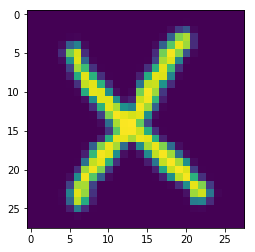

training set name:  train_X_73548.png
training set label:  K
IF measure:  -0.00726454289141
train_X_73548.png


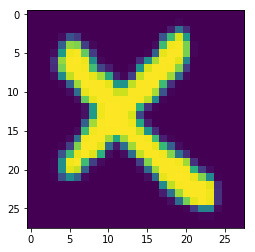

training set name:  train_X_28586.png
training set label:  K
IF measure:  -0.0070493264137
train_X_28586.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



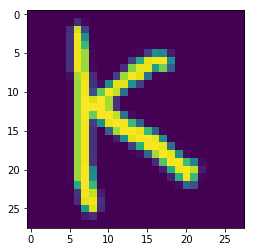

training set name:  train_K_82276.png
training set label:  W
IF measure:  0.0103890241989


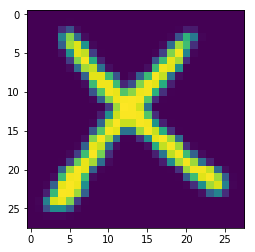

training set name:  train_X_6677.png
training set label:  K
IF measure:  -0.00993086956706


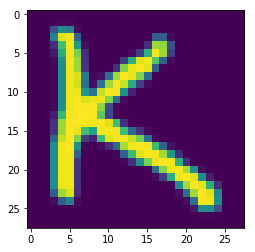

training set name:  train_K_96969.png
training set label:  r
IF measure:  0.00970948308389


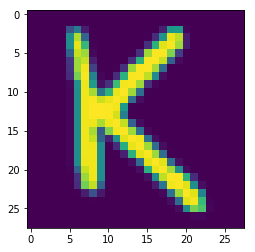

training set name:  train_K_57769.png
training set label:  S
IF measure:  0.00892719357466


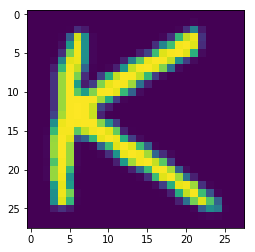

training set name:  train_K_10284.png
training set label:  6
IF measure:  0.00838809650629

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



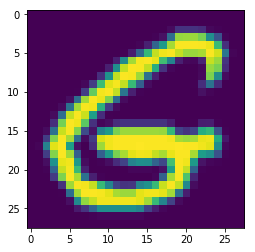

training set name:  train_G_15081.png
training set label:  G
IF measure:  -4.2887887851e-10


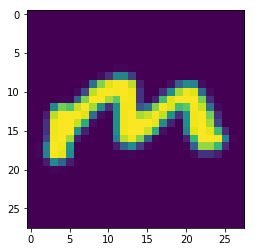

training set name:  train_M_18929.png
training set label:  M
IF measure:  6.56375875952e-10


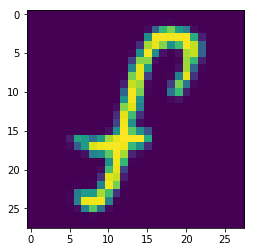

training set name:  train_f_108177.png
training set label:  f
IF measure:  -9.44524761005e-10


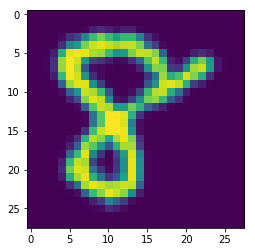

training set name:  train_8_58633.png
training set label:  8
IF measure:  -1.00283361127e-09


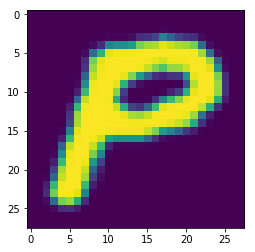

training set name:  train_P_19735.png
training set label:  P
IF measure:  -1.44826936511e-09


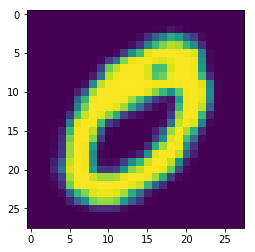

testfile name:  train_O_76548.png
ground truth label:  O
network prediction:  0
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 18716.914677972436, time: 14.73640251159668 

Recursion depth: 1, norm: 34328.88633133909, time: 14.795010089874268 

Recursion depth: 2, norm: 47362.1324636043, time: 14.745574951171875 

Recursion depth: 3, norm: 58242.5122097253, time: 14.928040266036987 

Recursion depth: 4, norm: 67325.69793919704, time: 14.942251205444336 

Recursion depth: 5, norm: 74908.66245635414, time: 14.823732614517212 

Recursion depth: 6, norm: 81238.94563569865, time: 14.776366949081421 

Recursion depth: 7, norm: 86523.56668561461, time: 14.980803966522217 

Recursion depth: 8, norm: 90935.1130862001, time: 14.787818670272827 

Recursion depth: 9, norm: 94617.9196981206, time: 14.733769655227661 

Recursion depth: 10, norm: 97692.35118472684, time: 14.747802257537842 

Recursion depth: 11, norm: 100258.9678881645, time: 14.817288160324097 

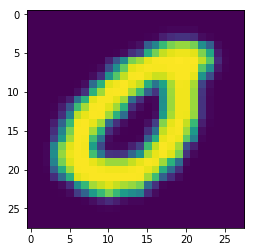

training set name:  train_0_47455.png
training set label:  0
IF measure:  0.0115125486508
train_0_47455.png


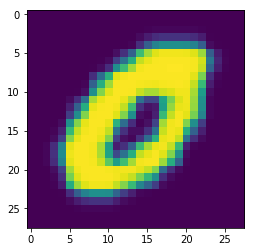

training set name:  train_0_104029.png
training set label:  0
IF measure:  0.0113596065512
train_0_104029.png


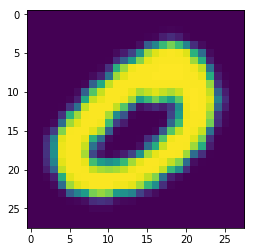

training set name:  train_0_45230.png
training set label:  0
IF measure:  0.0112265040741
train_0_45230.png


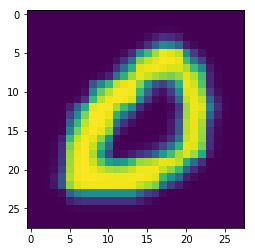

training set name:  train_0_78197.png
training set label:  0
IF measure:  0.0108565054147
train_0_78197.png


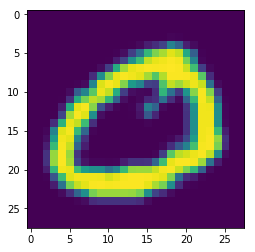

training set name:  train_0_65417.png
training set label:  0
IF measure:  0.00966582966717
train_0_65417.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



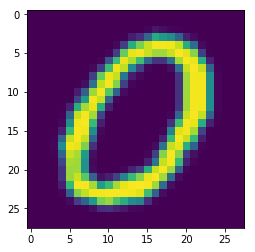

training set name:  train_O_61088.png
training set label:  O
IF measure:  -0.0124845916973
train_O_61088.png


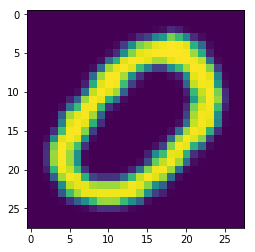

training set name:  train_0_5355.png
training set label:  O
IF measure:  -0.0120082593979
train_0_5355.png


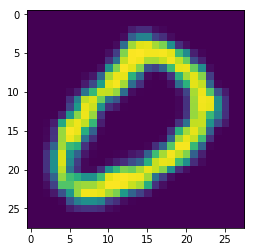

training set name:  train_O_51191.png
training set label:  O
IF measure:  -0.0118161058701
train_O_51191.png


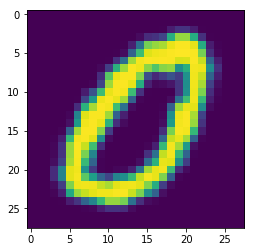

training set name:  train_O_49448.png
training set label:  O
IF measure:  -0.0114629489574
train_O_49448.png


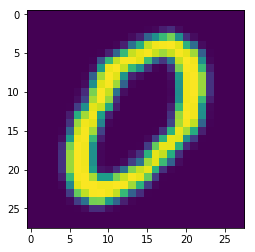

training set name:  train_O_39736.png
training set label:  O
IF measure:  -0.0112631499767
train_O_39736.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



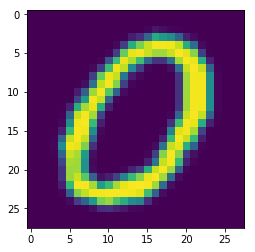

training set name:  train_O_61088.png
training set label:  O
IF measure:  -0.0124845916973


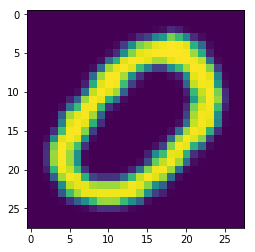

training set name:  train_0_5355.png
training set label:  O
IF measure:  -0.0120082593979


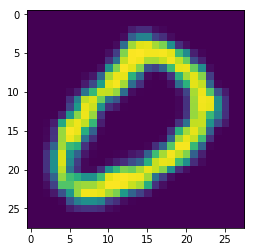

training set name:  train_O_51191.png
training set label:  O
IF measure:  -0.0118161058701


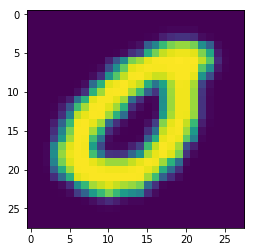

training set name:  train_0_47455.png
training set label:  0
IF measure:  0.0115125486508


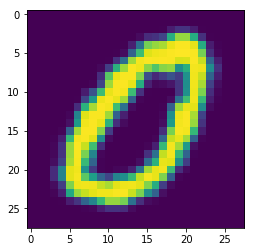

training set name:  train_O_49448.png
training set label:  O
IF measure:  -0.0114629489574

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



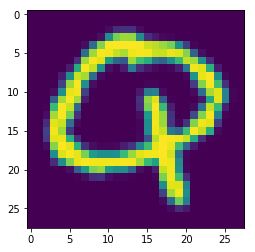

training set name:  train_Q_76666.png
training set label:  Q
IF measure:  4.15348008154e-11


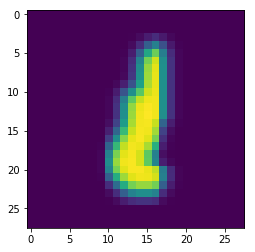

training set name:  train_I_65267.png
training set label:  I
IF measure:  -4.86560314497e-11


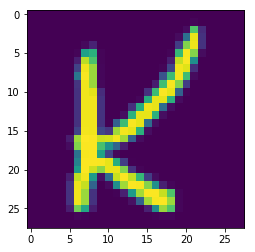

training set name:  train_K_87245.png
training set label:  K
IF measure:  1.38793809857e-10


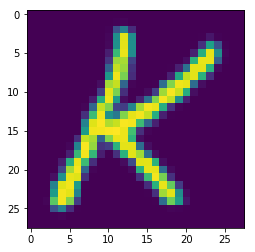

training set name:  train_K_85553.png
training set label:  K
IF measure:  -1.64529849162e-10


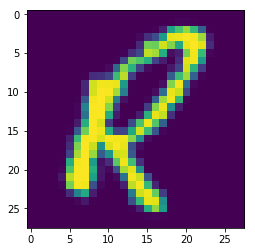

training set name:  train_R_6529.png
training set label:  R
IF measure:  -1.74272367695e-10


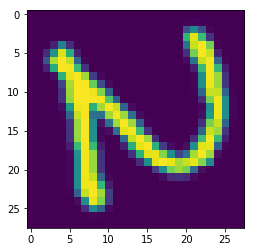

testfile name:  train_N_62932.png
ground truth label:  N
network prediction:  N
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 18554.082165388834, time: 14.951622247695923 

Recursion depth: 1, norm: 34030.137665016875, time: 15.117975234985352 

Recursion depth: 2, norm: 46949.97477368864, time: 14.994495391845703 

Recursion depth: 3, norm: 57735.74963573262, time: 14.696706771850586 

Recursion depth: 4, norm: 66739.8023034231, time: 14.887457609176636 

Recursion depth: 5, norm: 74256.92535043448, time: 14.973069429397583 

Recursion depth: 6, norm: 80532.22285830685, time: 14.873186349868774 

Recursion depth: 7, norm: 85770.87723405888, time: 14.717989683151245 

Recursion depth: 8, norm: 90144.15537349052, time: 14.70702338218689 

Recursion depth: 9, norm: 93795.3203896655, time: 14.833727836608887 

Recursion depth: 10, norm: 96843.02243837704, time: 15.100005388259888 

Recursion depth: 11, norm: 99387.60558037406, time: 15.0458836555480

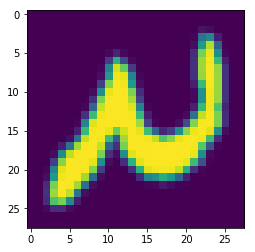

training set name:  train_N_106888.png
training set label:  W
IF measure:  0.010530959688
train_N_106888.png


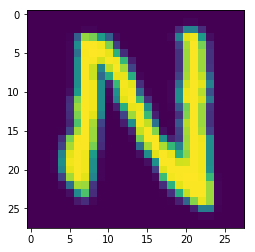

training set name:  train_N_47320.png
training set label:  W
IF measure:  0.00978151995768
train_N_47320.png


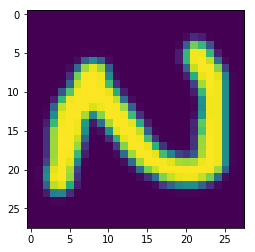

training set name:  train_n_66956.png
training set label:  b
IF measure:  0.00840636136156
train_n_66956.png


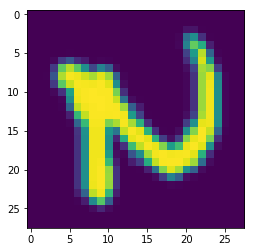

training set name:  train_N_28675.png
training set label:  g
IF measure:  0.00797848687738
train_N_28675.png


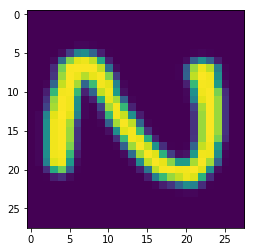

training set name:  train_N_19529.png
training set label:  n
IF measure:  0.0076638930999
train_N_19529.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



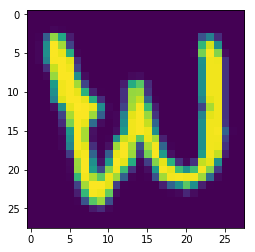

training set name:  train_W_46990.png
training set label:  N
IF measure:  -0.0138390495211
train_W_46990.png


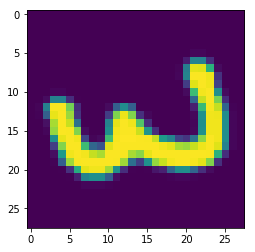

training set name:  train_W_69865.png
training set label:  N
IF measure:  -0.0104489851452
train_W_69865.png


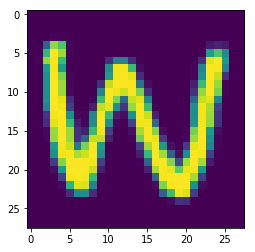

training set name:  train_W_27482.png
training set label:  N
IF measure:  -0.00932536245661
train_W_27482.png


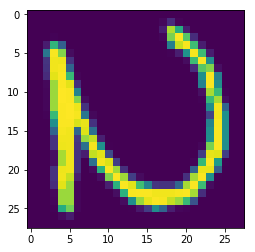

training set name:  train_N_33995.png
training set label:  N
IF measure:  -0.00869529193915
train_N_33995.png


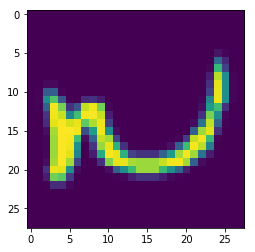

training set name:  train_N_14073.png
training set label:  N
IF measure:  -0.00856777321257
train_N_14073.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



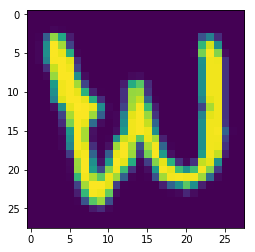

training set name:  train_W_46990.png
training set label:  N
IF measure:  -0.0138390495211


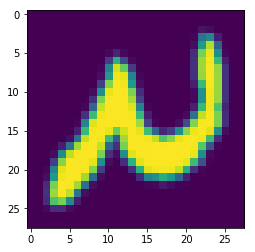

training set name:  train_N_106888.png
training set label:  W
IF measure:  0.010530959688


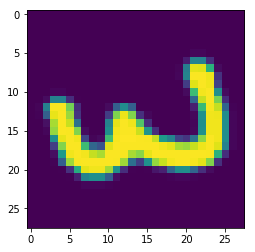

training set name:  train_W_69865.png
training set label:  N
IF measure:  -0.0104489851452


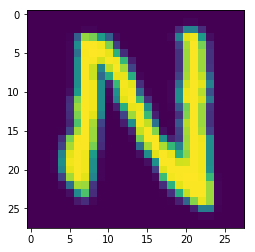

training set name:  train_N_47320.png
training set label:  W
IF measure:  0.00978151995768


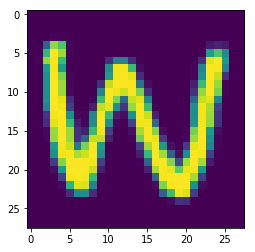

training set name:  train_W_27482.png
training set label:  N
IF measure:  -0.00932536245661

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



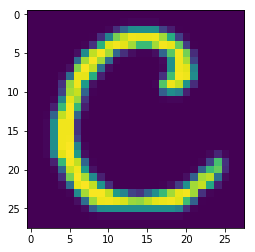

training set name:  train_C_50407.png
training set label:  0
IF measure:  -1.11203465664e-12


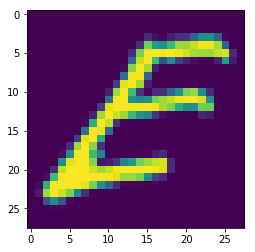

training set name:  train_E_19517.png
training set label:  E
IF measure:  -2.40812346581e-10


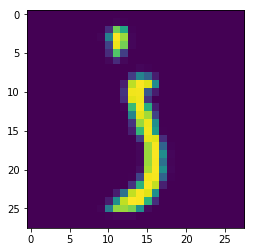

training set name:  train_J_16791.png
training set label:  5
IF measure:  -5.69944207826e-10


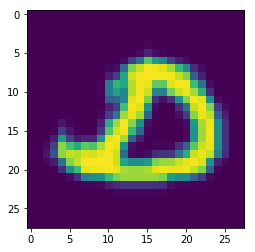

training set name:  train_D_91521.png
training set label:  D
IF measure:  -6.28846567884e-10


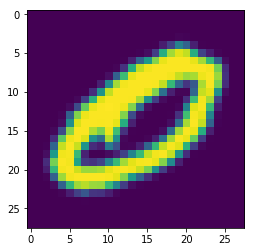

training set name:  train_O_23766.png
training set label:  O
IF measure:  1.13816007336e-09


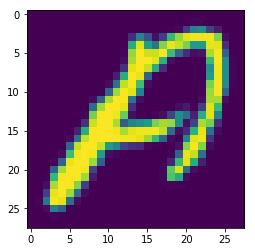

testfile name:  train_A_35525.png
ground truth label:  A
network prediction:  A
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]))
Recursion depth: 0, norm: 12795.515610947454, time: 14.853143453598022 

Recursion depth: 1, norm: 23466.683585457915, time: 14.709508419036865 

Recursion depth: 2, norm: 32374.675345862543, time: 14.887639045715332 

Recursion depth: 3, norm: 39811.30885188278, time: 14.67246699333191 

Recursion depth: 4, norm: 46019.58135131175, time: 14.792811632156372 

Recursion depth: 5, norm: 51202.44287629253, time: 14.636736392974854 

Recursion depth: 6, norm: 55529.26927756208, time: 14.775346994400024 

Recursion depth: 7, norm: 59141.69289511419, time: 14.753183364868164 

Recursion depth: 8, norm: 62157.00958862162, time: 14.95067834854126 

Recursion depth: 9, norm: 64674.439734720545, time: 14.721316814422607 

Recursion depth: 10, norm: 66776.08433413866, time: 14.705679655075073 

Recursion depth: 11, norm: 68530.51579406067, time: 14.8621871471

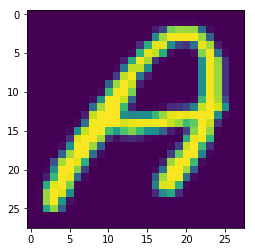

training set name:  train_A_53367.png
training set label:  X
IF measure:  0.00592964851951
train_A_53367.png


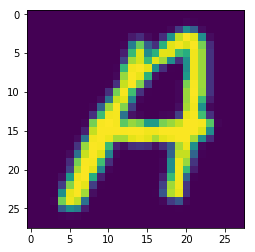

training set name:  train_A_31325.png
training set label:  t
IF measure:  0.00566508377645
train_A_31325.png


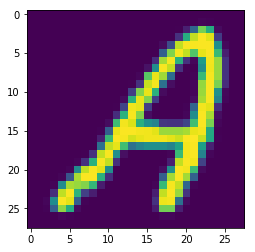

training set name:  train_A_106251.png
training set label:  r
IF measure:  0.00504960928984
train_A_106251.png


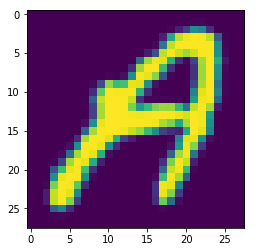

training set name:  train_A_91277.png
training set label:  M
IF measure:  0.00499498218774
train_A_91277.png


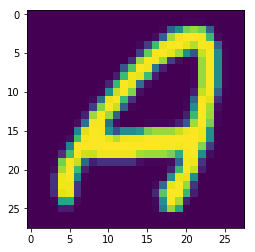

training set name:  train_A_65579.png
training set label:  4
IF measure:  0.00495908120317
train_A_65579.png

## SHOW 5-MOST ADVANTAGEOUS EXAMPLES ##



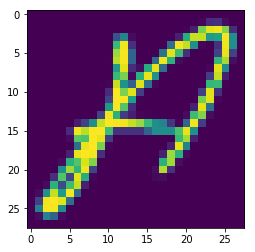

training set name:  train_A_12502.png
training set label:  A
IF measure:  -0.00461018166326
train_A_12502.png


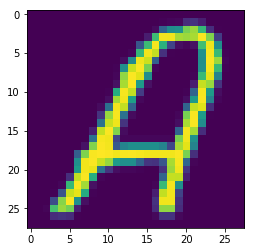

training set name:  train_A_51333.png
training set label:  A
IF measure:  -0.00460321537833
train_A_51333.png


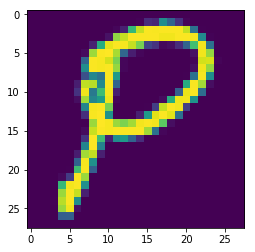

training set name:  train_P_56014.png
training set label:  A
IF measure:  -0.00447076886417
train_P_56014.png


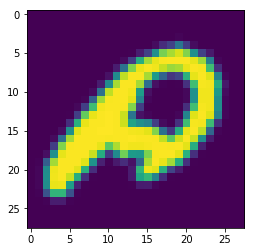

training set name:  train_A_56178.png
training set label:  A
IF measure:  -0.00432194545337
train_A_56178.png


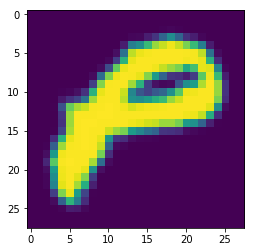

training set name:  train_P_17338.png
training set label:  A
IF measure:  -0.00431176997351
train_P_17338.png

## SHOW 5-MOST INFLUENTIAL EXAMPLES ##



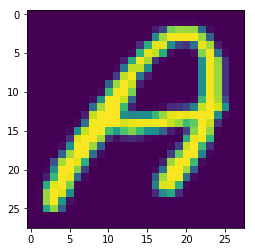

training set name:  train_A_53367.png
training set label:  X
IF measure:  0.00592964851951


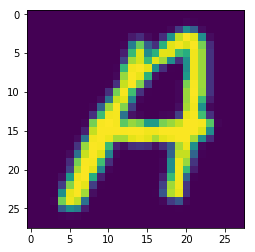

training set name:  train_A_31325.png
training set label:  t
IF measure:  0.00566508377645


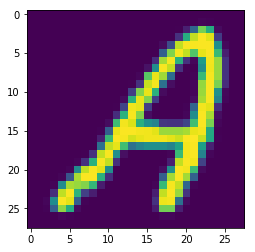

training set name:  train_A_106251.png
training set label:  r
IF measure:  0.00504960928984


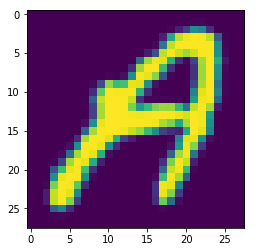

training set name:  train_A_91277.png
training set label:  M
IF measure:  0.00499498218774


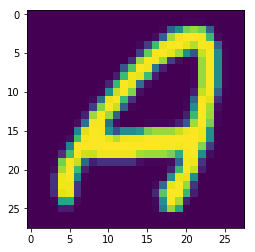

training set name:  train_A_65579.png
training set label:  4
IF measure:  0.00495908120317

## SHOW 5-MOST NEGLIGIBLE EXAMPLES ##



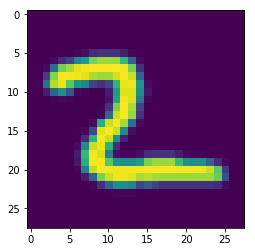

training set name:  train_2_29326.png
training set label:  n
IF measure:  7.67120079043e-12


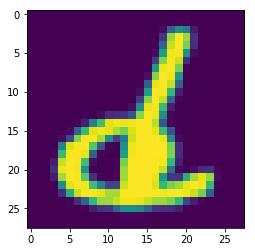

training set name:  train_d_71517.png
training set label:  d
IF measure:  -9.58117191574e-11


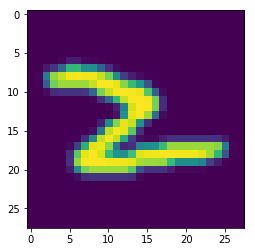

training set name:  train_Z_71873.png
training set label:  Z
IF measure:  3.56923777846e-10


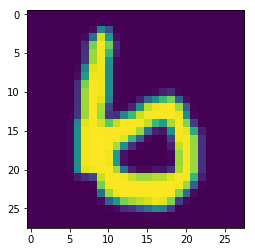

training set name:  train_b_71302.png
training set label:  b
IF measure:  3.66470892088e-10


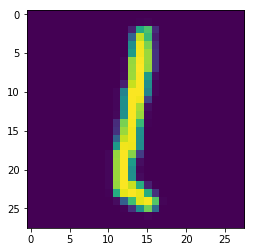

training set name:  train_L_88609.png
training set label:  L
IF measure:  5.54851110998e-10


In [38]:
# DO THIS FOR SEVERAL EXAMPLES

# vec v.s. freeze v.s. se

# restore trainval_list, test_list
file_dir = './compare/result_net_nn_if_nn/train_e_99502'

trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

test_list = list(np.load(file_dir+'/test_list.npy'))
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# FIXME
# network trained with noisy dataset, influence value with noisy dataset
train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict) # noisy dataset
save_dir = './compare/result_net_ns_if_ns' 
restore_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.3.dnn'

# # network trained with non-noisy dataset, influence value with non-noisy dataset
# train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset
# save_dir = './compare/result_net_nn_if_nn'
# restore_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network

for idx_test in range(0, 30):
    # Set a single test image

    # # Re-sample a test instance
    # test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=100)
    # test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)
    
    # Restore weights
    net.logits.restore(restore_dir)

    params = net.logits.parameters

    name_test = test_list[idx_test]
    img_test, lb_test = test_set.__getitem__(idx_test)
    show_image_from_data(img_test)
    v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)
    
    lb_true = anno_dict['classes'][str(np.argmax(lb_test))]
    lb_pred = anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))]
    print('testfile name: ', name_test)
    print('ground truth label: ', lb_true)
    print('network prediction: ', lb_pred)

    save_path = os.path.join(save_dir, name_test.split('.')[0])
    
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)
        
    scipy.misc.imsave(save_path+'/test_reference_true_{}_pred_{}.png'.format(lb_true,lb_pred), np.squeeze(img_test))

    np.save(save_path+'/trainval_list', trainval_list)
    np.save(save_path+'/test_list', test_list)

    # CALCULATE IF WITH FREEZED NETWORK

    params = net.loss.parameters
    p_ftex = net.d['dense1'].parameters
    p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
    print(p_logreg)
    v_logreg = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=p_logreg)

    # Calculate influence functions

#     # CG-FREEZE (1885 sec)
#     t1 = time.time()
#     ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':50})
#     IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
#     print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))
#     np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)
#     #IF_cg_logreg = np.load(save_path+'/if_cg_logreg.npy')
#     visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path=save_path+'/cg-frz')
    
#     # VECTOR-FREEZE (175 sec)
#     t1 = time.time()
#     IF_v_logreg = IF_val(net, v_logreg, train_set)
#     print('V_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_logreg),min(IF_v_logreg)]))
#     np.save(save_path+'/if_v_logreg.npy', IF_v_logreg)
#     #IF_v_logreg = np.load(save_path+'/if_v_logreg.npy')
#     visualize_topk_samples(IF_v_logreg, train_set, num_sample=5, save_path=save_path+'/vec-frz')

#     # Vector-FULL (1688 sec)
#     t1 = time.time()
#     IF_v = IF_val(net, v_test, train_set)
#     print('V takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v),min(IF_v)]))
#     np.save(save_path+'/if_v.npy', IF_v)
#     #IF_v = np.load(save_path+'/if_v.npy')
#     visualize_topk_samples(IF_v, train_set, num_sample=5, save_path=save_path+'/v')
    
#     # VECTOR-FREEZE-cosine-similarity (178 sec)
#     t1 = time.time()
#     IF_v_cos = IF_val(net, v_logreg, train_set, cosine=True)
#     print('V_cos takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_v_cos),min(IF_v_cos)]))
#     np.save(save_path+'/if_v_cos.npy', IF_v_cos)
#     #IF_v_cos = np.load(save_path+'/if_v_cos.npy')
#     visualize_topk_samples(IF_v_cos, train_set, num_sample=5, save_path=save_path+'/vec-cos')

#     # CG-FULL (1epoch, more than 3 hours, did it stuck at line search as it happened in ncg?)
#     t1 = time.time()
#     ihvp_cg = get_inverse_hvp_cg(net, net.loss, v_test, train_set,**{'damping':0.1, 'maxiter':100})
#     IF_cg = IF_val(net, ihvp_cg, train_set)
#     print('CG takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg),min(IF_cg)]))
#     np.save(save_path+'/if_cg.npy', IF_cg)
#     visualize_topk_samples(IF_cg, train_set, num_sample=5, save_path=save_path+'/cg')
    
#     # SE-FULL (? sec: diverge)
#     t1 = time.time()
#     ihvp_se = get_inverse_hvp_se(net, net.loss, v_test, train_set,**{'scale':1e5, 'damping':0.1, 'batch_size':50, 'recursion_depth':100})
#     IF_se = IF_val(net, ihvp_se, train_set)
#     print('SE takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se),min(IF_se)]))
#     np.save(save_path+'/if_se.npy', IF_se)
#     visualize_topk_samples(IF_se, train_set, num_sample=5, save_path=save_path+'/se')
    
    # SE-FREEZE (1065 sec)
    t1 = time.time()
    ihvp_se_logreg = get_inverse_hvp_se(net, net.loss, v_logreg, train_set,**{'scale':1e3, 'damping':0.1, 'batch_size':50, 'tolerance':0, 'recursion_depth':65})
    IF_se_logreg = IF_val(net, ihvp_se_logreg, train_set)
    print('SE_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_se_logreg),min(IF_se_logreg)]))
    np.save(save_path+'/if_se_logreg.npy', IF_se_logreg)
    #IF_se_logreg = np.load(save_path+'/if_se_logreg.npy')
    visualize_topk_samples(IF_se_logreg, train_set, num_sample=5, save_path=save_path+'/se-frz')
    

figures for ppts
=====================


In [ ]:
def find_idx(filename, filename_list):
    i = 0
    for fn in filename_list:
        if fn == filename:
            break
        i += 1
        
    return i

filename = 'train_e_99502.png'
fidx = find_idx(filename, test_list)

In [ ]:
fig_sample = []
for i in range(20):
    img, lb = train_set[i]
    fig_sample.append(img)
#print(fig_sample[1].shape)
fig_sample = np.concatenate(fig_sample, axis=1)
show_image_from_data(fig_sample)
scipy.misc.imsave('./images/image_samples_total.png', np.squeeze(fig_sample))

In [ ]:
# visualize image samples

# FIXME #
num_sample = 10
filename = 'train_e_99502.png'
file_dir = './compare/result_net_nn_if_nn/train_e_99502'

sample_idx = find_idx(filename, test_list)
img_test, lb_test = test_set[0]
show_image_from_data(img_test)
mask = [anno_dict['images'][exmp]['class'][0] == np.argmax(lb_test) for exmp in trainval_list]
mask_inv = [not e for e in mask]
#len(mask_e)

fig_sample = np.empty((1,28,0))

# data with same label w.r.t test sample (set A)
cnt = 0
for i in range(len(trainval_list)):
    if mask[i]:
        img, lb = train_set[i]
        fig_sample = np.concatenate((fig_sample, img), axis=2)
        cnt += 1
        if cnt == num_sample:
            break

print(fig_sample.shape)
scipy.misc.imsave('./images/image_samples.png', np.squeeze(fig_sample))
show_image_from_data(fig_sample)

# data with the others (set B)
fig_sample = np.empty((1,28,0))
cnt = 0
for i in range(len(trainval_list)):
    if mask_inv[i]:
        img, lb = train_set[i]
        fig_sample = np.concatenate((fig_sample, img), axis=2)
        cnt += 1
        if cnt == num_sample:
            break

print(fig_sample.shape)
scipy.misc.imsave('./images/image_samples2.png', np.squeeze(fig_sample))
show_image_from_data(fig_sample)

# data somewhat similar to each other (A n B)
IF_cg_logreg = np.load(file_dir+'/if_cg_logreg.npy')
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path='./images/all') # show all
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, mask=mask, save_path='./images/masked') # masked
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, mask=mask_inv, save_path='./images/masked_inv') # masked

# idx_sort_mask = list(filter(lambda idx: mask[idx], np.argsort(IF_cg_logreg)))

# for idx in idx_sort_mask:
#     show_image_from_data(train_set[idx][0])
#     print(IF_cg_logreg[idx])

    #show top bot inf neg
#     break
# for fige in mask_e[0:5]:
#     idx = find_idx(mask_e, trainval_list)
#     print(fige,idx)
#     show_image_from_data(train_set[idx])

In [ ]:
file_dir = './compare/result_net_nn_if_nn/train_e_99502'
restore_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network
net.logits.restore(restore_dir)

trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

test_list = list(np.load(file_dir+'/test_list.npy'))
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

IF_cg_logreg = np.load(file_dir+'/if_cg_logreg.npy')
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path='/tmp')

# # influence function w.r.t. label mask

# # mask_n = ['n' in exmp for exmp in trainval_list]
# # train_n_77228.png
# # anno_dict['classes'][str(np.argmax(lb_test))]

# mask_n = [anno_dict['images'][exmp]['class'][0] == np.argmax(lb_test) for exmp in trainval_list]
# # mask_n = [noisy_anno_dict['images'][exmp]['class'][0] == np.argmax(lb_test) for exmp in trainval_list]
# print(np.sum(mask_n))

# IF_msk_n = [e[0]*e[1] for e in zip(mask_n, IF_cg_logreg)]
# IF_msk_not_n = [(1-e[0])*e[1] for e in zip(mask_n, IF_cg_logreg)]

# print('show n examples only')
# visualize_topk_samples(IF_msk_n, train_set, num_sample=5, verbose='ADV')
# print('show non-n examples only')
# visualize_topk_samples(IF_msk_not_n, train_set, num_sample=5, verbose='DIS')


In [43]:
# axis change

# file_dir = './compare/result_net_nn_if_nn/train_e_99502'
# restore_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network
# net.logits.restore(restore_dir)

# trainval_list = list(np.load(file_dir+'/trainval_list.npy'))
# train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset

# test_list = list(np.load(file_dir+'/test_list.npy'))
# test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# IF_cg_logreg = np.load(file_dir+'/if_cg_logreg.npy')
# visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path='/tmp')

import glob

for dr in glob.glob('compare/*/*'):
    dr_se = dr+'/if_se_logreg.npy'
    if os.path.isfile(dr_se):
        print(dr_se)
        np.load(dr_se)

compare/result_net_ns_if_ns/train_C_17405/if_se_logreg.npy
compare/result_net_ns_if_ns/train_A_35525/if_se_logreg.npy
compare/result_net_ns_if_ns/train_X_70841/if_se_logreg.npy
compare/result_net_ns_if_ns/train_Q_53658/if_se_logreg.npy
compare/result_net_ns_if_ns/train_Q_78871/if_se_logreg.npy
compare/result_net_ns_if_ns/train_N_111767/if_se_logreg.npy
compare/result_net_ns_if_ns/train_O_39312/if_se_logreg.npy
compare/result_net_ns_if_ns/train_3_57272/if_se_logreg.npy
compare/result_net_ns_if_ns/train_O_76548/if_se_logreg.npy
compare/result_net_ns_if_ns/train_A_23922/if_se_logreg.npy
compare/result_net_ns_if_ns/train_T_73395/if_se_logreg.npy
compare/result_net_ns_if_ns/train_A_62497/if_se_logreg.npy
compare/result_net_ns_if_ns/train_G_51896/if_se_logreg.npy
compare/result_net_ns_if_ns/train_X_31386/if_se_logreg.npy
compare/result_net_ns_if_ns/train_N_62932/if_se_logreg.npy
compare/result_net_ns_if_ns/train_F_50837/if_se_logreg.npy
compare/result_net_ns_if_ns/train_D_77654/if_se_logreg.

border 2
======================

In [ ]:
# emnist network
from models.nn import VGG as ConvNet
tt_list, _ = dataset.read_data_subset(root_dir, mode='validation1')
tt_set = dataset.LazyDataset(root_dir, tt_list, anno_dict)

hp_d = dict() # hyperparameters for a network
net = ConvNet(train_set.__getitem__(0)[0].shape, len(anno_dict['classes']), **hp_d)
net.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.3.dnn')

# emnist network: SANITY CHECK
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = net.predict(tt_set, **hp_d)
total_time = time.time() - start_time

print('Test error rate: {}'.format(test_score))
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(tt_list)))
print('Confusion matrix: \n{}'.format(confusion_matrix))

In [ ]:
# Set a single test image

# # Re-sample a test instance
# test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=100)
# test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

params = net.logits.parameters

idx_test = 0

name_test = test_list[idx_test]
img_test, lb_test = test_set.__getitem__(idx_test)
show_image_from_data(img_test)
v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)

print('testfile name: ', name_test)
print('ground truth label: ', anno_dict['classes'][str(np.argmax(lb_test))])
print('network prediction: ', anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))])

save_path = os.path.join('./result', name_test.split('.')[0])
if not os.path.exists(save_path):
    # make folder
    os.makedirs(save_path)

np.save(save_path+'/trainval_list', trainval_list)
np.save(save_path+'/test_list', test_list)

In [ ]:
# CALCULATE IF WITH FREEZED NETWORK

params = net.loss.parameters
p_ftex = net.d['dense1'].parameters
p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
print(p_logreg)
v_logreg = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=p_logreg)

# Calculate influence functions

# the solution which is converged properly can be found within 10 iterations, otherwise does not converge
t1 = time.time()
#ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':10})
IF_cg_logreg = np.load(save_path+'/if_cg_logreg.npy')
#IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))

#np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)

# t1 = time.time()
# ihvp_ncg_logreg = get_inverse_hvp_ncg(net, net.loss, v_logreg, train_set,**{'damping':0.1, 'maxiter':3})
# IF_ncg_logreg = IF_val(net, ihvp_ncg_logreg, train_set)
# print('NCG_logreg takes {} sec, and its value {}'.format(time.time()-t1, IF_ncg_logreg))

# Restore weights
net.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn')

In [ ]:
test_list[0]#'train_n_77228.png'

In [ ]:
# Visualization
show_image_from_data(img_test)
print('ground truth label: ', anno_dict['classes'][str(np.argmax(lb_test))])
test_list[0]
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path=save_path)
# visualize_topk_samples(IF_ncg_logreg, num_sample=5)

In [ ]:
# influence function w.r.t. label mask

# mask_n = ['n' in exmp for exmp in trainval_list]
# train_n_77228.png
# anno_dict['classes'][str(np.argmax(lb_test))]

mask_n = [anno_dict['images'][exmp]['class'][0] == np.argmax(lb_test) for exmp in trainval_list]
# mask_n = [noisy_anno_dict['images'][exmp]['class'][0] == np.argmax(lb_test) for exmp in trainval_list]
print(np.sum(mask_n))

IF_msk_n = [e[0]*e[1] for e in zip(mask_n, IF_cg_logreg)]
IF_msk_not_n = [(1-e[0])*e[1] for e in zip(mask_n, IF_cg_logreg)]

print('show n examples only')
visualize_topk_samples(IF_msk_n, train_set, num_sample=5, verbose='ADV')
print('show non-n examples only')
visualize_topk_samples(IF_msk_not_n, train_set, num_sample=5, verbose='DIS')


In [ ]:
# influence function with training example

# Sample a train instance
params = net.logits.parameters

idx_train = 0

name_train = trainval_list[idx_train]
img_train, lb_train = train_set.__getitem__(idx_train)
show_image_from_data(img_train)
v_train = net.loss.grad({net.X:img_train, net.y:lb_train}, wrt=params)

print('trainfile name: ', name_train)
print('ground truth label: ', anno_dict['classes'][str(np.argmax(lb_train))])
print('network prediction: ', anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_train})))])

save_path = os.path.join('./result', name_train.split('.')[0])
if not os.path.exists(save_path):
    # make folder
    os.makedirs(save_path)

np.save(save_path+'/trainval_list', trainval_list)
np.save(save_path+'/test_list', test_list)

# CALCULATE IF WITH FREEZED NETWORK

params = net.loss.parameters
p_ftex = net.d['dense1'].parameters
p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
print(p_logreg)
v_logreg = net.loss.grad({net.X:img_train, net.y:lb_train}, wrt=p_logreg)

# Calculate influence functions

# the solution which is converged properly can be found within 10 iterations, otherwise does not converge
t1 = time.time()
ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':10})
IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))

np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)

# t1 = time.time()
# ihvp_ncg_logreg = get_inverse_hvp_ncg(net, net.loss, v_logreg, train_set,**{'damping':0.1, 'maxiter':3})
# IF_ncg_logreg = IF_val(net, ihvp_ncg_logreg, train_set)
# print('NCG_logreg takes {} sec, and its value {}'.format(time.time()-t1, IF_ncg_logreg))

# Restore weights
net.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn')

In [ ]:
visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5)
print('vector')
IF_vec = IF_val(net, v_test, train_set)
visualize_topk_samples(IF_vec, train_set, num_sample=5)

In [ ]:
# DO THIS FOR SEVERAL EXAMPLES

# FIXME
# # network trained with noisy dataset, influence value with noisy dataset
# train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict) # noisy dataset
# save_dir = './result_net_ns_if_ns' 
# restore_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.3.dnn'

# network trained with non-noisy dataset, influence value with non-noisy dataset
train_set = dataset.LazyDataset(root_dir, trainval_list, anno_dict) # non-noisy dataset
save_dir = './result_net_nn_if_nn'
restore_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.0.dnn' # non-noisy network

for idx_test in range(13, 14):
    # Set a single test image

    # # Re-sample a test instance
    # test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=100)
    # test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)
    
    # Restore weights
    net.logits.restore(restore_dir)

    params = net.logits.parameters

    name_test = test_list[idx_test]
    img_test, lb_test = test_set.__getitem__(idx_test)
    show_image_from_data(img_test)
    v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)
    
    lb_true = anno_dict['classes'][str(np.argmax(lb_test))]
    lb_pred = anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))]
    print('testfile name: ', name_test)
    print('ground truth label: ', lb_true)
    print('network prediction: ', lb_pred)

    save_path = os.path.join(save_dir, name_test.split('.')[0])
    if not os.path.exists(save_path):
        # make folder
        os.makedirs(save_path)
        
    scipy.misc.imsave(save_path+'/test_reference_true_{}_pred_{}.png'.format(lb_true,lb_pred), np.squeeze(img_test))

    np.save(save_path+'/trainval_list', trainval_list)
    np.save(save_path+'/test_list', test_list)

    # CALCULATE IF WITH FREEZED NETWORK

    params = net.loss.parameters
    p_ftex = net.d['dense1'].parameters
    p_logreg = tuple(set(params) - set(p_ftex)) # extract the weights of the last-layer (w,b)
    print(p_logreg)
    v_logreg = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=p_logreg)

    # Calculate influence functions

    # the solution which is converged properly can be found within 30 iterations, otherwise does not converge
    t1 = time.time()
    ihvp_cg_logreg = get_inverse_hvp_cg(net, net.loss, v_logreg, train_set,**{'damping':0.0, 'maxiter':30})
    IF_cg_logreg = IF_val(net, ihvp_cg_logreg, train_set)
    print('CG_logreg takes {} sec, and its max/min value {}'.format(time.time()-t1, [max(IF_cg_logreg),min(IF_cg_logreg)]))

    np.save(save_path+'/if_cg_logreg.npy', IF_cg_logreg)

    # otherwise, load
    IF_cg_logreg = np.load(save_path+'/if_cg_logreg.npy')

    # t1 = time.time()
    # ihvp_ncg_logreg = get_inverse_hvp_ncg(net, net.loss, v_logreg, train_set,**{'damping':0.1, 'maxiter':3})
    # IF_ncg_logreg = IF_val(net, ihvp_ncg_logreg, train_set)
    # print('NCG_logreg takes {} sec, and its value {}'.format(time.time()-t1, IF_ncg_logreg))
   
    visualize_topk_samples(IF_cg_logreg, train_set, num_sample=5, save_path=save_path)

In [ ]:
# RELABELING

import glob
import json
import numpy as np
import random
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import dataset28 as dataset
from models.nn import VGG as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

import time

def review(ratios, method):
    # ratios: the list of ratio which is the proportion of the data considered to be reviewed.  
    # reviewing is done by oracle. the label may or may not be changed. 
    #(i.e. if a single reviewed data has correct label, the label won't be changed, and vice versa)
    # method: the methodology of selecting data torch be reviewed. 
    # this can be 'random', 'influence', loss', 'entropy'
    t1 = time.time()

    # FIXME
    anno_dir = '/Data/emnist/balanced/original/annotation/'
    root_dir = '/Data/emnist/balanced/original/'
    #checkpt_dir = '/Data/github/interview/save/dropout_0.5_noaugmentation/model_fold_1_trainval_ratio_0.3.dnn'
    #checkpt_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn'
    checkpt_dir = '/Data/checkpts/noisy/model_fold_1_trainval_ratio_0.3.dnn'

    with open(anno_dir + 'annotation1.json', 'r') as fid:
        annotation = json.load(fid)

    with open(anno_dir + 'annotation1_wp_0.3.json', 'r') as fid:
        noisy_annotation = json.load(fid)

    #image_list = list(noisy_annotation['images'].keys())
    image_list = trainval_list
    num_image = len(image_list)

    ## sorting
    if method == 'random':
        # random policy
        image_list_random = image_list[:]
        random.shuffle(image_list_random)
        review_list = image_list_random
        #review_list_random = np.random.choice(image_list, int(num_image * ratio), replace=False)
        
    elif method == 'influence':
        # influence function
        save_path = './result_0.3/train_n_77228'
        IF_measure = np.load(save_path+'/if_cg_logreg.npy')
        argsort_abs = np.argsort(np.abs(IF_measure))[::-1]
        #review_list = image_list[argsort_abs]
        review_list = [image_list[idx] for idx in argsort_abs]
#         noisy_list = [noisy_annotation['images'][fname]['class'] for fname in review_list]
#         print(review_list[0:int(num_image * ratios[0])])
#         print(noisy_list[0:int(num_image * ratios[0])])

    elif method == 'influence-sum':
        # summation of influence function among several samples
        save_path = glob.glob('./result_0.3/*')
        IF_measures = []
        for pth in save_path:
            IF_measure = np.load(pth+'/if_cg_logreg.npy')
            IF_measures.append(np.abs(IF_measure))
        IF_measures = np.mean(IF_measures, axis=0)
        argsort_abs = np.argsort(IF_measures)[::-1]
        review_list = [image_list[idx] for idx in argsort_abs]
        
    else:
        # loss
        image_set = dataset.LazyDataset(root_dir, image_list, noisy_annotation)
        model = ConvNet(image_set.__getitem__(0)[0].shape, len(annotation['classes']))
        model.logits.restore(checkpt_dir)
        evaluator = Evaluator()
        
        # extract loss, entropy
        t1_measure = time.time()
        loss, entropy = network_based_measure(model, image_set)
        t2_measure = time.time()
        print('measure extraction takes {}'.format(t2_measure-t1_measure))
        # check data // filename[0] and __getitem__[0] and dataloader first instance
        # -> all of them are same. in other word, we can use an index information
        
        if method == 'loss':
            # loss ascending policy
            idx_loss = np.argsort(loss)[::-1]
            image_list_loss = [image_list[i] for i in idx_loss]
            review_list = image_list_loss
        
        elif method == 'entropy':
            # entropy ascending policy
            idx_entropy = np.argsort(entropy)[::-1]
            image_list_entropy = [image_list[i] for i in idx_entropy]
            review_list = image_list_entropy

    ## correcting
    corrected_list = []
    for ratio in ratios:
        print(ratio)
        num_corrected = 0
        review_list_ratio = review_list[0:int(num_image * ratio)]
        print(len(review_list_ratio))
        for fname in review_list_ratio:
            correct_class = annotation['images'][fname]['class']
            noisy_class = noisy_annotation['images'][fname]['class']
            if noisy_class != correct_class:
                num_corrected += 1
        #corrected_list.append(num_corrected/int(0.3*len(image_list)))
        corrected_list.append(num_corrected)

    return corrected_list
    #return [cr/int(0.3*len(image_list)) for cr in corrected_list]

def network_based_measure(model, data_set):
    # return loss and entropy
    batch_size = 256
    num_workers = 6
    dataloader = DataLoader(data_set, batch_size, shuffle=False, num_workers=num_workers)
    
    num_classes = len(dataset.anno_dict['classes'])

    loss = np.empty(0)
    entropy = np.empty(0)
    
    # prediction in batchwise
    for X, y in dataloader:
        X = X.numpy(); y = y.numpy()
        y_pred = model.pred.eval({model.X: X})
        loss_batch = -np.log(np.sum(y_pred * y, axis=1))
        entropy_batch = -np.sum(y_pred * np.log(y_pred), axis=1)
        loss = np.concatenate((loss,loss_batch), axis=0)
        entropy = np.concatenate((entropy, entropy_batch))

    return loss, entropy

# main code

#x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#x = [0.001]
#x = [0.1, 0.5, 0.9]
x = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rnd = review(x, 'random')
ls = review(x, 'loss')
etp = review(x, 'entropy')
inf1 = review(x, 'influence')
inf2 = review(x, 'influence-sum')
# vector
# vector frz
# vector cos

print(rnd)
print(ls)
print(etp)
print(inf1)
print(inf2)

# draw a graph
fig, ax = plt.subplots(1,1, figsize=(9,9))
_ = ax.plot(x, rnd, color='b', label='random')
_ = ax.plot(x, ls, color='g', label='loss')
_ = ax.plot(x, etp, color='r', label='entropy') 
_ = ax.plot(x, inf1, color='y', label='influence') 
_ = ax.plot(x, inf2, color='c', label='influence-sum') 
_ = ax.set_title('Recovery results')
_ = ax.set_ylabel('Ratio of corrected labeled: $Num_{corrected}/Num_{mislabeled}$')
_ = ax.set_xlabel('Ratio of reviewed data: $Num_{reviewed}/Num_{total}$')
_ = ax.set_xticks(x)
_ = plt.legend()
plt.savefig('./images/recovery_results.png', bbox_inches='tight')
plt.show()

# tsne
tsne.py 참고

# Retraining
bootstrapping 참고

그리고 SE도 돌려볼 것.
그리고 여러 z_test의 if에 대해서 summation을 한 후 sorting 보기
(그래서 전체적으로 성능을 나쁘게 하는 녀석이 있는지 찾기)

In [ ]:
[trainval_list]
